``Mission : Error Analysis & Model metadata``

- Why 0.80 vs 0.100???


# Data and dependencies

In [1]:
import warnings
import sys
import os
import time
import joblib
import random
from tqdm import tqdm
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from geopy.distance import geodesic

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

warnings.filterwarnings('ignore')

In [2]:
metadata = pd.read_csv('../data/metadata.csv')
sub_format = pd.read_csv('../data/submission_format.csv')
train_labels = pd.read_csv('../data/train_labels.csv')

In [3]:
def rmse(y_true, y_pred):
    return mse(y_true, y_pred, squared=False)

In [4]:
def dens_to_sev(x: float)-> int:
    """takes in density value in cells/ml and returns severity category"""
    if (x < 20_000) : return 1
    elif (x >= 20_000) and (x < 100_000) : return 2
    elif (x >= 100_000) and (x < 1_000_000) : return 3
    elif (x >= 1_000_000) and (x < 10_000_000) : return 4
    elif x > 10_000_000 : return 5

## Add date fts

In [5]:
metadata.date = pd.to_datetime(metadata.date)
metadata['year'] = metadata.date.dt.year
metadata['month'] = metadata.date.dt.month
metadata['week'] = metadata.date.dt.isocalendar().week


seasons = {
    1: 1,
    2: 1,
    3: 2,
    4: 2,
    5: 2,
    6: 3,
    7: 3,
    8: 3,
    9: 4,
    10: 4,
    11: 4,
    12: 1
}

metadata['season'] = metadata.month.map(seasons)


region = pd.concat((train_labels, sub_format[['region', 'uid']]), axis=0)

data = pd.merge(metadata, region, on='uid', how='left')
data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
0,aabm,39.080319,-86.430867,2018-05-14,train,2018,5,20,2,midwest,1.0,585.0
1,aabn,36.559700,-121.510000,2016-08-31,test,2016,8,35,3,west,NaN,NaN
2,aacd,35.875083,-78.878434,2020-11-19,train,2020,11,47,4,south,1.0,290.0
3,aaee,35.487000,-79.062133,2016-08-24,train,2016,8,34,3,south,1.0,1614.0
4,aaff,38.049471,-99.827001,2019-07-23,train,2019,7,30,3,midwest,3.0,111825.0
...,...,...,...,...,...,...,...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test,2014,12,49,1,west,NaN,NaN
23566,zzwo,39.792190,-99.971050,2017-06-19,train,2017,6,25,3,midwest,2.0,48510.0
23567,zzwq,35.794000,-79.012551,2015-03-24,train,2015,3,13,2,south,1.0,1271.0
23568,zzyb,35.742000,-79.238600,2016-11-21,train,2016,11,47,4,south,1.0,9682.0


In [6]:
test_data = data[data.split == 'test']
test_data.shape, data.shape

((6510, 12), (23570, 12))

In [7]:
train_data = data[data.split == 'train']
train_data.shape, data.shape

((17060, 12), (23570, 12))

In [8]:
train_data.severity.mean()

2.1459554513481827

In [9]:
dens_to_sev(train_data.density.mean())

4

# Utils

In [10]:
#  Utils
def get_data_by_date( date=None, data=train_data):
    return data[data.date == date]


def get_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).km

def analyize_matches(y_true, y_pred):
    print("Exact matches: ", sum(y_true == y_pred) / len(y_true))
    
    print("Missed by 1: ", sum(abs(y_true - y_pred) == 1) / len(y_true))
    print("Missed by 2: ", sum(abs(y_true - y_pred) == 2) / len(y_true))
    print("Missed by 3: ", sum(abs(y_true - y_pred) == 3) / len(y_true))
    print("Missed by 4: ", sum(abs(y_true - y_pred) == 4) / len(y_true))

# My Guess

In [11]:
te_data = test_data.sort_values(by='date')
te_data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
6865,howw,37.0062,-120.600,2013-01-08,test,2013,1,2,1,west,NaN,NaN
3661,eamn,36.9818,-120.221,2013-01-08,test,2013,1,2,1,west,NaN,NaN
7668,imsv,36.9836,-120.500,2013-01-08,test,2013,1,2,1,west,NaN,NaN
20182,wgxq,33.8011,-117.205,2013-01-25,test,2013,1,4,1,west,NaN,NaN
16095,rsos,33.8892,-117.562,2013-01-25,test,2013,1,4,1,west,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
12443,nsoi,36.7368,-121.734,2021-12-29,test,2021,12,52,1,west,NaN,NaN
14254,prfi,36.7518,-121.742,2021-12-29,test,2021,12,52,1,west,NaN,NaN
6864,howu,36.7085,-121.749,2021-12-29,test,2021,12,52,1,west,NaN,NaN
6540,hfvr,36.7962,-121.782,2021-12-29,test,2021,12,52,1,west,NaN,NaN


In [12]:
tr_data, val_data = train_test_split(train_data, test_size=0.15, random_state=144, shuffle=True)
tr_data.shape, val_data.shape

((14501, 12), (2559, 12))

## Guess Funcs

In [505]:
fill_2s = []
g_from_past = {}

n_times_called = {}

def make_guess1(row: pd.Series, date=None, tr_data=tr_data) -> pd.Series:

    dists = []
    region = row.region
    date = date
    uid = row.uid
    tr_data = tr_data

    if date is None:
        date = row.date

    rel_data = tr_data[(tr_data.date == date) & (tr_data.region == region)]
    
    # check if cur date is past '2013-01-04'
    if date < pd.to_datetime('2013-01-04'):
        print(f'No previous data for this date filling in 2s .. for {row.uid}')
        fill_2s.append(uid)
        return 2

    if rel_data.shape[0] == 0:
        # print(f'No data for this date, trying previous day.. for {row.uid}')
        if g_from_past.get(uid) is not None:
            g_from_past[uid] += 1
        return make_guess1(row, date=date - pd.Timedelta(days=1), tr_data=tr_data)

    for some_row in rel_data.itertuples():
        dist = get_distance(row.latitude, row.longitude, some_row.latitude, some_row.longitude)
        dists.append(dist)
    
    nearest = rel_data.iloc[np.argmin(dists)]
    return nearest.severity


def make_guess2(row: pd.Series, date=None, tr_data=tr_data, n_times_called=None) -> pd.Series:
    """modified version of make_guess1, Uses mean/mode of severity for the region instead of nearest severity."""
    dists = []
    region = row.region
    date = date
    uid = row.uid
    tr_data = tr_data
    
    if n_times_called is not None:
        if n_times_called.get(uid) is None:
            n_times_called[uid] = 1
        else:
            n_times_called[uid] += 1
        

    if date is None:
        date = row.date

    rel_data = tr_data[(tr_data.date == date) & (tr_data.region == region)]
    
    # check if cur date is past '2013-01-04'
    if date < pd.to_datetime('2013-01-04'):
        print(f'No previous data for this date filling in 2s .. for {row.uid}')
        fill_2s.append(uid)
        return 2

    if rel_data.shape[0] == 0:
        # print(f'No data for this date, trying previous day.. for {row.uid}')
        if g_from_past.get(uid) is not None:
            g_from_past[uid] += 1
        global count 
        count += 1
        return make_guess2(row, date=date - pd.Timedelta(days=1), tr_data=tr_data)

    severty_mode = rel_data.severity.mode()[0]
    severty_mean = np.round(rel_data.severity.mean())

    return severty_mean



def cv_loop(rand, splits=10, guess_func=make_guess1):
    # print("Random Number: ", rand)
    skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=rand)
    tscv = TimeSeriesSplit(n_splits=splits)
    rmses = []
    guess_train_preds = np.zeros((train_data.shape[0]))

    for fold, (train_idx, val_idx) in enumerate(tscv.split(train_data, train_data.severity)):
        print(f"Fold: {fold}")
        tr_data, val_data = train_data.iloc[train_idx], train_data.iloc[val_idx]

        val_data['guess1'] = 0

        temp = []
        for row in tqdm(val_data.itertuples(), total=val_data.shape[0]):
            uid_series = val_data[val_data.uid == row.uid]
            severity = guess_func(uid_series.iloc[0], date=row.date, tr_data=tr_data)
            val_data.loc[val_data.uid == row.uid, f'guess1'] = severity
            temp.append(severity)
        
        guess_train_preds[val_idx] = temp
        

                
        errror = rmse(val_data.severity, val_data.guess1)
        rmses.append(errror)
        print("RMSE: ", errror)

        print('Train Distribution: ')
        print(tr_data.severity.value_counts(normalize=True))
        print('Val Distribution: ')
        print(val_data.severity.value_counts(normalize=True))
        print('Predicted Distribution: ')
        print(val_data.guess1.value_counts(normalize=True))

    
    print('----------------------------------------------------')

    return rmses, guess_train_preds


In [122]:
tr_data.sort_values(by='date', inplace=True)
val_data.sort_values(by='date', inplace=True)

In [123]:
tr_data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
4387,evep,44.847993,-93.476318,2013-01-04,train,2013,1,1,1,midwest,1.0,115.0
6144,guny,44.878889,-93.490833,2013-01-04,train,2013,1,1,1,midwest,1.0,558.0
5317,fwbt,44.850500,-93.515700,2013-01-04,train,2013,1,1,1,midwest,1.0,476.0
13283,oqcg,37.114500,-120.890000,2013-01-08,train,2013,1,2,1,west,4.0,4500000.0
13827,pfly,37.803400,-120.841000,2013-01-08,train,2013,1,2,1,west,4.0,2881767.5
...,...,...,...,...,...,...,...,...,...,...,...,...
6718,hkvs,36.030000,-78.706429,2021-12-14,train,2021,12,50,1,south,2.0,31769.0
14516,pykd,36.030000,-78.706927,2021-12-14,train,2021,12,50,1,south,2.0,51737.0
17778,tobi,36.030000,-78.705932,2021-12-14,train,2021,12,50,1,south,1.0,4357.0
23159,zoaj,36.060000,-78.760000,2021-12-14,train,2021,12,50,1,south,2.0,48233.0


In [124]:
val_data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density,guess,guess2
13644,paev,44.822478,-93.367962,2013-01-04,train,2013,1,1,1,midwest,1.0,1884.0,1.0,1.0
5566,gdxr,44.877646,-93.557842,2013-01-04,train,2013,1,1,1,midwest,1.0,1416.0,1.0,1.0
1126,bgwz,37.413900,-121.014000,2013-01-08,train,2013,1,2,1,west,4.0,3740000.0,3.0,4.0
16227,rwkd,38.115600,-121.494000,2013-01-15,train,2013,1,3,1,west,4.0,1745249.0,3.0,4.0
13719,pceh,37.967400,-121.464000,2013-01-15,train,2013,1,3,1,west,3.0,985182.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6435,hdjp,35.686281,-79.200202,2021-12-02,train,2021,12,48,1,south,1.0,9958.0,1.0,2.0
549,aqae,35.658149,-79.252453,2021-12-02,train,2021,12,48,1,south,1.0,290.0,1.0,2.0
15266,quux,35.877009,-78.893845,2021-12-02,train,2021,12,48,1,south,1.0,16980.0,1.0,2.0
5806,gkeq,37.263900,-120.906000,2021-12-13,train,2021,12,50,1,west,4.0,6797500.0,4.0,4.0


In [125]:
for row in tqdm(val_data.itertuples(), total=val_data.shape[0]):
    val_data.loc[row.Index, 'guess'] = make_guess1(row)

100%|██████████| 2559/2559 [00:42<00:00, 60.57it/s] 


In [126]:
rmse(val_data.severity, val_data.guess)

0.8548416232611225

In [19]:
analyize_matches(val_data.severity, val_data.guess)

Exact matches:  0.6053145760062525
Missed by 1:  0.3028526768268855
Missed by 2:  0.08245408362641657
Missed by 3:  0.008206330597889801
Missed by 4:  0.0011723329425556857


In [20]:
# 0.08284486127393513 + 0.008206330597889801 + 0.0011723329425556857
# 91% preds < 1 offs, 99% preds < 2 offs, 88% preds == 2 offs

In [21]:
# what are the samples missing by 1

val_data[val_data.severity - val_data.guess == 1]

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density,guess
1126,bgwz,37.413900,-121.014000,2013-01-08,train,2013,1,2,1,west,4.0,3.740000e+06,3.0
16227,rwkd,38.115600,-121.494000,2013-01-15,train,2013,1,3,1,west,4.0,1.745249e+06,3.0
1178,bils,35.658042,-79.252651,2013-01-29,train,2013,1,5,1,south,2.0,5.184600e+04,1.0
629,ascv,35.794000,-79.004000,2013-02-12,train,2013,2,7,1,south,2.0,3.664900e+04,1.0
19900,vyle,32.384010,-104.145830,2013-03-28,train,2013,3,13,2,west,2.0,2.182287e+04,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8249,jdhb,39.077955,-96.880810,2021-09-20,train,2021,9,38,4,midwest,3.0,4.326020e+05,2.0
12915,ofvy,37.782398,-97.531050,2021-10-04,train,2021,10,40,4,midwest,3.0,1.587410e+05,2.0
376,aljv,39.211550,-97.005590,2021-10-11,train,2021,10,41,4,midwest,3.0,1.590030e+05,2.0
9495,klbq,35.876636,-78.890862,2021-10-12,train,2021,10,41,4,south,2.0,9.703900e+04,1.0


In [22]:
val_data[val_data.uid == 'bgwz']

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density,guess
1126,bgwz,37.4139,-121.014,2013-01-08,train,2013,1,2,1,west,4.0,3740000.0,3.0


In [23]:
some_data = tr_data[tr_data.date == '2013-01-08']
some_data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
14259,prgf,37.4918,-120.684,2013-01-08,train,2013,1,2,1,west,4.0,4529556.50
2107,cizy,37.1366,-120.762,2013-01-08,train,2013,1,2,1,west,4.0,4482500.00
13499,owaj,37.3772,-121.058,2013-01-08,train,2013,1,2,1,west,4.0,3755000.00
10819,lwjc,37.5150,-121.012,2013-01-08,train,2013,1,2,1,west,4.0,1054871.00
13840,pfsh,37.4419,-121.003,2013-01-08,train,2013,1,2,1,west,3.0,136538.00
5172,fryq,37.2583,-120.475,2013-01-08,train,2013,1,2,1,west,4.0,4135845.75
9919,kwua,37.6003,-121.224,2013-01-08,train,2013,1,2,1,west,2.0,86350.00
2366,cqge,37.1976,-120.488,2013-01-08,train,2013,1,2,1,west,4.0,3324651.50
20554,wrxx,37.3133,-120.892,2013-01-08,train,2013,1,2,1,west,4.0,4070390.00
16589,sgtc,37.3204,-120.983,2013-01-08,train,2013,1,2,1,west,4.0,4027500.00


In [24]:
# lets see bgwz

make_guess1(val_data[val_data.uid == 'bgwz'].iloc[0])

3.0

In [25]:
dists = []
for some_row in some_data.itertuples():
        dist = get_distance(37.4139, -121.014, some_row.latitude, some_row.longitude)
        dists.append(dist)

In [26]:
some_data.iloc[np.argmin(dists)]

uid                         pfsh
latitude                 37.4419
longitude               -121.003
date         2013-01-08 00:00:00
split                      train
year                        2013
month                          1
week                           2
season                         1
region                      west
severity                     3.0
density                 136538.0
Name: 13840, dtype: object

In [27]:
# Observations:

#  In this case the closest one is 3, but the actual value is 4
#  I guess it is far better if we search for the same location in the past or try mode of the region

In [28]:
# what are the samples missing by 2

val_data[val_data.severity - val_data.guess == 2]

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density,guess
10194,leit,35.657803,-79.253096,2013-03-13,train,2013,3,11,2,south,3.0,517495.0,1.0
12916,ofxt,35.976000,-78.712644,2013-05-14,train,2013,5,20,2,south,3.0,258059.0,1.0
12054,nhaw,35.859897,-78.756888,2013-06-04,train,2013,6,23,3,south,3.0,121991.0,1.0
2778,dbwj,39.628330,-99.580000,2013-06-24,train,2013,6,26,3,midwest,4.0,1204875.0,2.0
9775,ktdj,36.177000,-79.053877,2013-06-26,train,2013,6,26,3,south,3.0,613345.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14082,pmwk,35.892413,-79.017132,2021-07-12,train,2021,7,28,3,south,3.0,445365.0,1.0
23233,zqbi,35.790000,-79.037119,2021-07-12,train,2021,7,28,3,south,3.0,117925.0,1.0
2241,cnei,41.550878,-86.361626,2021-08-30,train,2021,8,35,3,midwest,4.0,1694159.0,2.0
11467,mpss,37.746680,-97.779360,2021-09-13,train,2021,9,37,4,midwest,3.0,136045.0,1.0


In [29]:
make_guess1(val_data[val_data.uid == 'leit'].iloc[0])


1.0

In [30]:
leit_date = '2013-03-13'

leit_data = tr_data[tr_data.date == leit_date]
leit_data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
4319,etfx,35.701531,-79.171876,2013-03-13,train,2013,3,11,2,south,1.0,1017.0
7443,igat,35.910270,-79.160055,2013-03-13,train,2013,3,11,2,south,1.0,3970.0
20379,wndy,35.910208,-79.159558,2013-03-13,train,2013,3,11,2,south,1.0,11909.0
831,ayfy,35.701504,-79.171926,2013-03-13,train,2013,3,11,2,south,1.0,218.0
4197,eqdu,35.657883,-79.252948,2013-03-13,train,2013,3,11,2,south,1.0,581.0
8679,jpte,35.794000,-79.004000,2013-03-13,train,2013,3,11,2,south,3.0,193734.0
19154,vcho,35.859275,-78.751916,2013-03-13,train,2013,3,11,2,south,1.0,871.0
15152,qrhs,35.859306,-78.752165,2013-03-13,train,2013,3,11,2,south,1.0,2324.0
18806,usoo,35.910301,-79.160303,2013-03-13,train,2013,3,11,2,south,1.0,9159.0


In [31]:
dists = []
for some_row in some_data.itertuples():
        dist = get_distance(37.4139, -121.014, some_row.latitude, some_row.longitude)
        dists.append(dist)

## With guess2

In [208]:
val_data_calls = {}
count = 0

In [209]:
for row in tqdm(val_data.itertuples(), total=val_data.shape[0]):
    val_data.loc[row.Index, 'guess2'] = make_guess2(row, n_times_called=val_data_calls)

  5%|▌         | 133/2559 [00:00<00:05, 467.89it/s]

No data for this date, trying previous day.. for vyle
No data for this date, trying previous day.. for veuv
No data for this date, trying previous day.. for zxjy


  7%|▋         | 180/2559 [00:00<00:05, 465.32it/s]

No data for this date, trying previous day.. for xdtz
No data for this date, trying previous day.. for xdtz
No data for this date, trying previous day.. for xdtz
No data for this date, trying previous day.. for xdtz
No data for this date, trying previous day.. for xdtz
No data for this date, trying previous day.. for xdtz
No data for this date, trying previous day.. for xdtz
No data for this date, trying previous day.. for xdtz
No data for this date, trying previous day.. for kxjx
No data for this date, trying previous day.. for kxjx
No data for this date, trying previous day.. for kxjx
No data for this date, trying previous day.. for kxjx
No data for this date, trying previous day.. for kxjx
No data for this date, trying previous day.. for kxjx
No data for this date, trying previous day.. for kxjx
No data for this date, trying previous day.. for hkyf
No data for this date, trying previous day.. for hkyf
No data for this date, trying previous day.. for hkyf
No data for this date, tryin

 19%|█▉        | 497/2559 [00:01<00:03, 532.48it/s]

No data for this date, trying previous day.. for msnp
No data for this date, trying previous day.. for opci
No data for this date, trying previous day.. for ltai


 24%|██▎       | 604/2559 [00:01<00:04, 472.29it/s]

No data for this date, trying previous day.. for reah
No data for this date, trying previous day.. for reah
No data for this date, trying previous day.. for reah
No data for this date, trying previous day.. for reah
No data for this date, trying previous day.. for reah
No data for this date, trying previous day.. for reah
No data for this date, trying previous day.. for reah
No data for this date, trying previous day.. for reah
No data for this date, trying previous day.. for reah
No data for this date, trying previous day.. for reah
No data for this date, trying previous day.. for reah
No data for this date, trying previous day.. for reah
No data for this date, trying previous day.. for reah
No data for this date, trying previous day.. for reah
No data for this date, trying previous day.. for reah
No data for this date, trying previous day.. for reah
No data for this date, trying previous day.. for reah
No data for this date, trying previous day.. for reah
No data for this date, tryin

 30%|██▉       | 763/2559 [00:01<00:03, 501.66it/s]

No data for this date, trying previous day.. for rbfi
No data for this date, trying previous day.. for wqrh
No data for this date, trying previous day.. for vmgb
No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, tryin

 32%|███▏      | 814/2559 [00:01<00:06, 264.77it/s]

No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, trying previous day.. for ipze
No data for this date, tryin

 33%|███▎      | 854/2559 [00:02<00:06, 274.91it/s]

No data for this date, trying previous day.. for kwhr
No data for this date, trying previous day.. for kwhr
No data for this date, trying previous day.. for kwhr
No data for this date, trying previous day.. for kwhr
No data for this date, trying previous day.. for kwhr
No data for this date, trying previous day.. for kwhr
No data for this date, trying previous day.. for kwhr
No data for this date, trying previous day.. for kwhr
No data for this date, trying previous day.. for kwhr
No data for this date, trying previous day.. for kwhr
No data for this date, trying previous day.. for kwhr
No data for this date, trying previous day.. for kwhr
No data for this date, trying previous day.. for kwhr
No data for this date, trying previous day.. for kwhr
No data for this date, trying previous day.. for wqqw
No data for this date, trying previous day.. for ckxf
No data for this date, trying previous day.. for ckxf
No data for this date, trying previous day.. for ckxf
No data for this date, tryin

 38%|███▊      | 975/2559 [00:02<00:05, 312.54it/s]

No data for this date, trying previous day.. for gpzd
No data for this date, trying previous day.. for gpzd
No data for this date, trying previous day.. for gpzd
No data for this date, trying previous day.. for gpzd
No data for this date, trying previous day.. for gpzd
No data for this date, trying previous day.. for gpzd
No data for this date, trying previous day.. for gpzd
No data for this date, trying previous day.. for gpzd
No data for this date, trying previous day.. for gpzd
No data for this date, trying previous day.. for gpzd
No data for this date, trying previous day.. for gpzd
No data for this date, trying previous day.. for gpzd
No data for this date, trying previous day.. for gpzd
No data for this date, trying previous day.. for gpzd
No data for this date, trying previous day.. for poau
No data for this date, trying previous day.. for qaqd


 42%|████▏     | 1067/2559 [00:02<00:04, 363.31it/s]

No data for this date, trying previous day.. for fqwk
No data for this date, trying previous day.. for fqwk
No data for this date, trying previous day.. for fqwk
No data for this date, trying previous day.. for fqwk
No data for this date, trying previous day.. for fqwk
No data for this date, trying previous day.. for fqwk
No data for this date, trying previous day.. for fqwk
No data for this date, trying previous day.. for fqwk
No data for this date, trying previous day.. for fqwk
No data for this date, trying previous day.. for fqwk
No data for this date, trying previous day.. for fqwk
No data for this date, trying previous day.. for fqwk
No data for this date, trying previous day.. for frrq
No data for this date, trying previous day.. for frrq
No data for this date, trying previous day.. for frrq
No data for this date, trying previous day.. for frrq
No data for this date, trying previous day.. for frrq
No data for this date, trying previous day.. for frrq
No data for this date, tryin

 47%|████▋     | 1191/2559 [00:03<00:03, 371.91it/s]

No data for this date, trying previous day.. for zafy
No data for this date, trying previous day.. for ygcr
No data for this date, trying previous day.. for ygcr
No data for this date, trying previous day.. for ygcr
No data for this date, trying previous day.. for ygcr
No data for this date, trying previous day.. for ygcr
No data for this date, trying previous day.. for ygcr
No data for this date, trying previous day.. for ldgb
No data for this date, trying previous day.. for ldgb
No data for this date, trying previous day.. for ldgb
No data for this date, trying previous day.. for ldgb
No data for this date, trying previous day.. for ldgb
No data for this date, trying previous day.. for ldgb
No data for this date, trying previous day.. for ldgb
No data for this date, trying previous day.. for ldgb
No data for this date, trying previous day.. for ldgb
No data for this date, trying previous day.. for ldgb
No data for this date, trying previous day.. for ldgb
No data for this date, tryin

 50%|█████     | 1280/2559 [00:03<00:03, 402.05it/s]

No data for this date, trying previous day.. for abdk
No data for this date, trying previous day.. for nute
No data for this date, trying previous day.. for bbsi
No data for this date, trying previous day.. for lmpf
No data for this date, trying previous day.. for hevf
No data for this date, trying previous day.. for mxos


 56%|█████▌    | 1429/2559 [00:03<00:02, 453.34it/s]

No data for this date, trying previous day.. for ojaz
No data for this date, trying previous day.. for jirh
No data for this date, trying previous day.. for zqah
No data for this date, trying previous day.. for wjjr
No data for this date, trying previous day.. for xabs
No data for this date, trying previous day.. for xabs
No data for this date, trying previous day.. for xabs
No data for this date, trying previous day.. for xabs
No data for this date, trying previous day.. for mghh
No data for this date, trying previous day.. for hefu
No data for this date, trying previous day.. for hefu
No data for this date, trying previous day.. for hefu
No data for this date, trying previous day.. for hefu
No data for this date, trying previous day.. for hefu
No data for this date, trying previous day.. for hefu
No data for this date, trying previous day.. for hefu
No data for this date, trying previous day.. for hefu
No data for this date, trying previous day.. for hefu
No data for this date, tryin

 62%|██████▏   | 1582/2559 [00:03<00:01, 490.80it/s]

No data for this date, trying previous day.. for tkdo
No data for this date, trying previous day.. for crcs
No data for this date, trying previous day.. for crcs


 66%|██████▌   | 1687/2559 [00:04<00:01, 469.98it/s]

No data for this date, trying previous day.. for bois
No data for this date, trying previous day.. for xwpr
No data for this date, trying previous day.. for uokp
No data for this date, trying previous day.. for xvok
No data for this date, trying previous day.. for xvok
No data for this date, trying previous day.. for xvok
No data for this date, trying previous day.. for xvok
No data for this date, trying previous day.. for akcy
No data for this date, trying previous day.. for yhdm
No data for this date, trying previous day.. for xkff


 68%|██████▊   | 1735/2559 [00:04<00:02, 403.57it/s]

No data for this date, trying previous day.. for dpre
No data for this date, trying previous day.. for dpre
No data for this date, trying previous day.. for dpre
No data for this date, trying previous day.. for dpre
No data for this date, trying previous day.. for dpre
No data for this date, trying previous day.. for dpre
No data for this date, trying previous day.. for dpre
No data for this date, trying previous day.. for dpre
No data for this date, trying previous day.. for dpre
No data for this date, trying previous day.. for dpre
No data for this date, trying previous day.. for dpre
No data for this date, trying previous day.. for dpre
No data for this date, trying previous day.. for dpre
No data for this date, trying previous day.. for qbua
No data for this date, trying previous day.. for qbua
No data for this date, trying previous day.. for qbua
No data for this date, trying previous day.. for pptw
No data for this date, trying previous day.. for pptw
No data for this date, tryin

 71%|███████   | 1816/2559 [00:04<00:02, 277.79it/s]

No data for this date, trying previous day.. for agqj
No data for this date, trying previous day.. for agqj
No data for this date, trying previous day.. for agqj
No data for this date, trying previous day.. for agqj
No data for this date, trying previous day.. for agqj
No data for this date, trying previous day.. for agqj
No data for this date, trying previous day.. for agqj
No data for this date, trying previous day.. for agqj
No data for this date, trying previous day.. for agqj
No data for this date, trying previous day.. for agqj
No data for this date, trying previous day.. for agqj
No data for this date, trying previous day.. for agqj
No data for this date, trying previous day.. for agqj
No data for this date, trying previous day.. for agqj
No data for this date, trying previous day.. for agqj
No data for this date, trying previous day.. for agqj
No data for this date, trying previous day.. for frxr
No data for this date, trying previous day.. for frxr
No data for this date, tryin

 74%|███████▍  | 1899/2559 [00:04<00:02, 314.78it/s]

No data for this date, trying previous day.. for egsc
No data for this date, trying previous day.. for egsc
No data for this date, trying previous day.. for egsc
No data for this date, trying previous day.. for egsc
No data for this date, trying previous day.. for egsc
No data for this date, trying previous day.. for egsc
No data for this date, trying previous day.. for egsc
No data for this date, trying previous day.. for egsc
No data for this date, trying previous day.. for egsc
No data for this date, trying previous day.. for egsc
No data for this date, trying previous day.. for egsc
No data for this date, trying previous day.. for egsc
No data for this date, trying previous day.. for egsc
No data for this date, trying previous day.. for egsc
No data for this date, trying previous day.. for egsc
No data for this date, trying previous day.. for egsc
No data for this date, trying previous day.. for egsc
No data for this date, trying previous day.. for egsc
No data for this date, tryin

 77%|███████▋  | 1982/2559 [00:05<00:01, 356.38it/s]

No data for this date, trying previous day.. for iqvz
No data for this date, trying previous day.. for iqvz
No data for this date, trying previous day.. for iqvz
No data for this date, trying previous day.. for iqvz
No data for this date, trying previous day.. for iqvz
No data for this date, trying previous day.. for iqvz
No data for this date, trying previous day.. for iqvz
No data for this date, trying previous day.. for qrsj
No data for this date, trying previous day.. for qrsj
No data for this date, trying previous day.. for qrsj
No data for this date, trying previous day.. for oesj
No data for this date, trying previous day.. for ylcj
No data for this date, trying previous day.. for ylcj
No data for this date, trying previous day.. for ylcj
No data for this date, trying previous day.. for ylcj
No data for this date, trying previous day.. for ylcj
No data for this date, trying previous day.. for ylcj
No data for this date, trying previous day.. for ylcj
No data for this date, tryin

 81%|████████  | 2072/2559 [00:05<00:01, 401.21it/s]

No data for this date, trying previous day.. for copu
No data for this date, trying previous day.. for copu
No data for this date, trying previous day.. for copu
No data for this date, trying previous day.. for copu
No data for this date, trying previous day.. for copu
No data for this date, trying previous day.. for cbnk
No data for this date, trying previous day.. for cbnk
No data for this date, trying previous day.. for cbnk
No data for this date, trying previous day.. for cbnk
No data for this date, trying previous day.. for cbnk
No data for this date, trying previous day.. for cbnk
No data for this date, trying previous day.. for cbnk


 85%|████████▍ | 2165/2559 [00:05<00:00, 427.50it/s]

No data for this date, trying previous day.. for tmsd
No data for this date, trying previous day.. for tmsd
No data for this date, trying previous day.. for tmsd
No data for this date, trying previous day.. for tmsd
No data for this date, trying previous day.. for tmsd
No data for this date, trying previous day.. for tmsd
No data for this date, trying previous day.. for tmsd
No data for this date, trying previous day.. for nnnd


 88%|████████▊ | 2264/2559 [00:05<00:00, 458.01it/s]

No data for this date, trying previous day.. for tgmt
No data for this date, trying previous day.. for lbby
No data for this date, trying previous day.. for lbby
No data for this date, trying previous day.. for lbby
No data for this date, trying previous day.. for lbby
No data for this date, trying previous day.. for aclb
No data for this date, trying previous day.. for aclb
No data for this date, trying previous day.. for aclb
No data for this date, trying previous day.. for aclb
No data for this date, trying previous day.. for aclb
No data for this date, trying previous day.. for aclb
No data for this date, trying previous day.. for aclb
No data for this date, trying previous day.. for aclb
No data for this date, trying previous day.. for aclb
No data for this date, trying previous day.. for aclb
No data for this date, trying previous day.. for aclb
No data for this date, trying previous day.. for aclb
No data for this date, trying previous day.. for aclb
No data for this date, tryin

 92%|█████████▏| 2356/2559 [00:05<00:00, 420.38it/s]

No data for this date, trying previous day.. for nrrp
No data for this date, trying previous day.. for gpdn


 98%|█████████▊| 2507/2559 [00:06<00:00, 461.56it/s]

No data for this date, trying previous day.. for lxjy
No data for this date, trying previous day.. for lxjy
No data for this date, trying previous day.. for lxjy
No data for this date, trying previous day.. for lxjy
No data for this date, trying previous day.. for lxjy
No data for this date, trying previous day.. for lxjy
No data for this date, trying previous day.. for htzk
No data for this date, trying previous day.. for qoyi
No data for this date, trying previous day.. for jvfg
No data for this date, trying previous day.. for fgio


100%|██████████| 2559/2559 [00:06<00:00, 400.20it/s]

No data for this date, trying previous day.. for gkeq
No data for this date, trying previous day.. for gkeq
No data for this date, trying previous day.. for gkeq
No data for this date, trying previous day.. for gkeq
No data for this date, trying previous day.. for gkeq
No data for this date, trying previous day.. for gkeq
No data for this date, trying previous day.. for gkeq
No data for this date, trying previous day.. for gkeq
No data for this date, trying previous day.. for gkeq
No data for this date, trying previous day.. for gkeq
No data for this date, trying previous day.. for gkeq
No data for this date, trying previous day.. for gkeq
No data for this date, trying previous day.. for gkeq
No data for this date, trying previous day.. for gkeq


In [211]:
count/val_data.shape[0]

0.28487690504103164

In [216]:
# this could be the reason! val data goes for previous dates about 1 in 4 samples. but the test data goes to previous date about 3 dates forward for every sample.!!

# Validate  val data only if it looks like test data

In [194]:
rmse(val_data.severity, val_data.guess2)
#  this is worse on first glance but..

0.7857663030948374

In [195]:
print(len(val_data_calls))

max(val_data_calls.values())

2559


1

In [129]:
analyize_matches(val_data.severity, val_data.guess2)

#  much better at exact matches and 1 offs but worse at 2 offs so missed by 2s should have spiked up the error!

Exact matches:  0.5607659241891364
Missed by 1:  0.3911684251660805
Missed by 2:  0.04181320828448613
Missed by 3:  0.005861664712778429
Missed by 4:  0.00039077764751856197


In [98]:
# 0.5592028135990621 + 0.39234075810863617 + 0.04181320828448613 + 0.0062524423602969914 + 0.00039077764751856197
# 0.5592028135990621 + 0.39234075810863617

# 95% preds <= 1 offs (thats why they are goood!)  4.8% >= 2 offs

0.04845642829230168

In [130]:
rmses, guess2_mean = cv_loop(rand=1859, splits=5,  guess_func=make_guess2)

Fold: 0


 12%|█▏        | 347/2843 [00:03<00:19, 131.06it/s]

No previous data for this date filling in 2s .. for evep


 35%|███▌      | 1009/2843 [00:11<00:22, 83.30it/s]

No previous data for this date filling in 2s .. for fvng
No previous data for this date filling in 2s .. for fwbt


 42%|████▏     | 1204/2843 [00:13<00:15, 108.99it/s]

No previous data for this date filling in 2s .. for gdxr


 49%|████▉     | 1399/2843 [00:15<00:25, 57.62it/s] 

No previous data for this date filling in 2s .. for gkvw


 58%|█████▊    | 1635/2843 [00:18<00:07, 156.57it/s]

No previous data for this date filling in 2s .. for guny


100%|██████████| 2843/2843 [00:29<00:00, 94.95it/s] 


RMSE:  0.9186005352544053
Train Distribution: 
1.0    0.437258
4.0    0.211248
2.0    0.184183
3.0    0.163796
5.0    0.003515
Name: severity, dtype: float64
Val Distribution: 
1.0    0.447415
4.0    0.206120
2.0    0.188533
3.0    0.154063
5.0    0.003869
Name: severity, dtype: float64
Predicted Distribution: 
2    0.347168
1    0.345762
4    0.212452
3    0.091453
5    0.003166
Name: guess1, dtype: float64
Fold: 1


 45%|████▍     | 1272/2843 [00:10<00:20, 78.23it/s] 

No previous data for this date filling in 2s .. for kmki


100%|██████████| 2843/2843 [00:28<00:00, 99.77it/s] 


RMSE:  0.8637377567389661
Train Distribution: 
1.0    0.442335
4.0    0.208685
2.0    0.186357
3.0    0.158931
5.0    0.003692
Name: severity, dtype: float64
Val Distribution: 
1.0    0.444953
4.0    0.212100
2.0    0.186423
3.0    0.153007
5.0    0.003517
Name: severity, dtype: float64
Predicted Distribution: 
2    0.371087
1    0.349279
4    0.221949
3    0.056630
5    0.001055
Name: guess1, dtype: float64
Fold: 2


100%|██████████| 2843/2843 [00:35<00:00, 79.06it/s] 


RMSE:  0.8151312611573267
Train Distribution: 
1.0    0.443207
4.0    0.209823
2.0    0.186379
3.0    0.156957
5.0    0.003634
Name: severity, dtype: float64
Val Distribution: 
1.0    0.451987
4.0    0.204010
2.0    0.185719
3.0    0.156877
5.0    0.001407
Name: severity, dtype: float64
Predicted Distribution: 
2    0.406964
1    0.320084
4    0.199085
3    0.073514
5    0.000352
Name: guess1, dtype: float64
Fold: 3


100%|██████████| 2843/2843 [00:22<00:00, 127.40it/s]


RMSE:  0.8493650770539654
Train Distribution: 
1.0    0.445402
4.0    0.208370
2.0    0.186214
3.0    0.156937
5.0    0.003077
Name: severity, dtype: float64
Val Distribution: 
1.0    0.429828
4.0    0.208934
2.0    0.198382
3.0    0.157580
5.0    0.005276
Name: severity, dtype: float64
Predicted Distribution: 
2    0.416110
1    0.301090
4    0.218079
3    0.064369
5    0.000352
Name: guess1, dtype: float64
Fold: 4


100%|██████████| 2843/2843 [00:23<00:00, 120.12it/s]

RMSE:  0.8001055153771268
Train Distribution: 
1.0    0.442287
4.0    0.208483
2.0    0.188647
3.0    0.157065
5.0    0.003517
Name: severity, dtype: float64
Val Distribution: 
1.0    0.425255
4.0    0.205065
2.0    0.195920
3.0    0.170946
5.0    0.002814
Name: severity, dtype: float64
Predicted Distribution: 
2    0.410482
1    0.310236
4    0.205065
3    0.073162
5    0.001055
Name: guess1, dtype: float64
----------------------------------------------------


In [131]:
np.mean(rmses), np.std(rmses)

(0.8493880291163581, 0.04146945508927233)

In [132]:
analyize_matches(train_data.severity, guess2_mean)

Exact matches:  0.45791324736225086
Missed by 1:  0.3899179366940211
Missed by 2:  0.0794841735052755
Missed by 3:  0.03622508792497069
Missed by 4:  0.03587338804220398


In [133]:
0.4587338804220399 + 0.3884525205158265

0.8471864009378665

In [46]:
#  Is there any difference between test and val sets?

te_data.region.value_counts(normalize=True)

west         0.366667
midwest      0.240399
south        0.232104
northeast    0.160829
Name: region, dtype: float64

In [50]:
val_data.region.value_counts(normalize=True)

south        0.579132
west         0.221180
midwest      0.130911
northeast    0.068777
Name: region, dtype: float64

In [51]:
train_data.region.value_counts(normalize=True)

south        0.583118
west         0.220926
midwest      0.128957
northeast    0.066999
Name: region, dtype: float64

In [52]:
test_data.date.value_counts(normalize=True)

2019-09-17    40
2014-07-30    38
2019-01-17    32
2019-08-27    30
2019-05-28    29
              ..
2020-01-17     1
2014-06-16     1
2018-05-23     1
2020-11-05     1
2013-11-21     1
Name: date, Length: 1278, dtype: int64

In [53]:
train_data.date.value_counts(normalize=True)

2016-08-10    0.008089
2015-07-07    0.006389
2015-06-22    0.006038
2015-08-24    0.005627
2015-06-10    0.005569
                ...   
2018-12-10    0.000059
2014-02-20    0.000059
2021-03-18    0.000059
2021-02-24    0.000059
2020-04-20    0.000059
Name: date, Length: 1255, dtype: float64

In [134]:
south = val_data[val_data.region == 'south']
west = val_data[val_data.region == 'west']
midwest = val_data[val_data.region == 'midwest']
northeast = val_data[val_data.region == 'northeast']

In [135]:
rmse(south.severity, south.guess2), rmse(south.severity, south.guess)

(0.8131842079168767, 0.9132404377632387)

In [136]:
rmse(west.severity, west.guess2), rmse(west.severity, west.guess)

(0.5670579955507383, 0.5763293130075913)

In [137]:
rmse(midwest.severity, midwest.guess2), rmse(midwest.severity, midwest.guess)

(0.9288092200038601, 0.9478963354115085)

In [138]:
rmse(northeast.severity, northeast.guess2), rmse(northeast.severity, northeast.guess)

(0.856127645538062, 0.9076693430779935)

In [139]:
rmse(val_data.guess2, val_data.guess)

0.6790564218619121

In [56]:
analyize_matches(val_data.guess2, val_data.guess)

Exact matches:  0.6228995701445877
Missed by 1:  0.3540445486518171
Missed by 2:  0.022274325908558032
Missed by 3:  0.0007815552950371239
Missed by 4:  0.0


In [142]:
rg = te_data.region.value_counts(normalize=True)
rg

west         0.366667
midwest      0.240399
south        0.232104
northeast    0.160829
Name: region, dtype: float64

In [143]:
0.8131842079168767 * rg['south']  + 0.5670579955507383 * rg['west'] + 0.9288092200038601 * rg['midwest'] + 0.856127645538062 * rg['northeast']

0.7576406832145016

In [114]:
west = train_data[train_data.region == 'west'].sample(366*2, random_state=42)
south = train_data[train_data.region == 'south'].sample(240*2, random_state=42)
midwest = train_data[train_data.region == 'midwest'].sample(232*2, random_state=42)
northeast = train_data[train_data.region == 'northeast'].sample(160*2, random_state=42)


new_val_data = pd.concat([west, south, midwest, northeast])
new_val_data.region.value_counts(normalize=True)

west         0.366733
south        0.240481
midwest      0.232465
northeast    0.160321
Name: region, dtype: float64

In [115]:
new_tr_data = train_data[~train_data.uid.isin(new_val_data.uid)]
new_tr_data.region.value_counts(normalize=True)

south        0.628518
west         0.201606
midwest      0.115242
northeast    0.054634
Name: region, dtype: float64

In [197]:
newval_calls = {}
for row in tqdm(new_val_data.itertuples(), total=new_val_data.shape[0]):
    new_val_data.loc[row.Index, 'guess2'] = make_guess2(row, tr_data=new_tr_data, n_times_called=newval_calls)
    

100%|██████████| 1996/1996 [00:05<00:00, 334.32it/s]


In [199]:
print(len(newval_calls))


max(newval_calls.values())

1996


1

In [198]:
rmse(new_val_data.severity, new_val_data.guess2)

0.7734315695558147

In [117]:
new_val_data.severity.value_counts(normalize=True)

4.0    0.342685
1.0    0.318136
3.0    0.166834
2.0    0.165832
5.0    0.006513
Name: severity, dtype: float64

In [118]:
new_val_data.guess2.value_counts(normalize=True)
#  4 1 2 3 5

4.0    0.334669
2.0    0.294088
1.0    0.233968
3.0    0.133267
5.0    0.004008
Name: guess2, dtype: float64

In [120]:
analyize_matches(new_val_data.severity, new_val_data.guess2)

Exact matches:  0.6277555110220441
Missed by 1:  0.31312625250501
Missed by 2:  0.04909819639278557
Missed by 3:  0.009519038076152305
Missed by 4:  0.000501002004008016


In [212]:
test_calls = {}
count = 0

In [213]:
for row in tqdm(test_data.itertuples(), total=test_data.shape[0]):
    test_data.loc[row.Index, 'guess1'] = make_guess2(row, tr_data=train_data, n_times_called=test_calls)

  1%|          | 34/6510 [00:00<00:36, 177.74it/s]

No data for this date, trying previous day.. for aabn
No data for this date, trying previous day.. for aabn
No data for this date, trying previous day.. for aabn
No data for this date, trying previous day.. for aabn
No data for this date, trying previous day.. for aabn
No data for this date, trying previous day.. for aabn
No data for this date, trying previous day.. for aabn
No data for this date, trying previous day.. for aabn
No data for this date, trying previous day.. for aair
No data for this date, trying previous day.. for aair
No data for this date, trying previous day.. for aair
No data for this date, trying previous day.. for aair
No data for this date, trying previous day.. for aair
No data for this date, trying previous day.. for aair
No data for this date, trying previous day.. for aair
No data for this date, trying previous day.. for aair
No data for this date, trying previous day.. for aair
No data for this date, trying previous day.. for aair
No data for this date, tryin

  1%|          | 53/6510 [00:00<01:15, 85.01it/s] 

No data for this date, trying previous day.. for afef
No data for this date, trying previous day.. for afef
No data for this date, trying previous day.. for afef
No data for this date, trying previous day.. for afef
No data for this date, trying previous day.. for afef
No data for this date, trying previous day.. for afef
No data for this date, trying previous day.. for afef
No data for this date, trying previous day.. for afef
No data for this date, trying previous day.. for afef
No data for this date, trying previous day.. for afef
No data for this date, trying previous day.. for afef
No data for this date, trying previous day.. for afef
No data for this date, trying previous day.. for afef
No data for this date, trying previous day.. for afef
No data for this date, trying previous day.. for afef
No data for this date, trying previous day.. for afef
No data for this date, trying previous day.. for afef
No data for this date, trying previous day.. for afef
No data for this date, tryin

  1%|          | 66/6510 [00:00<01:19, 80.80it/s]

No data for this date, trying previous day.. for aghh
No data for this date, trying previous day.. for aghh
No data for this date, trying previous day.. for aghh
No data for this date, trying previous day.. for agku
No data for this date, trying previous day.. for agku
No data for this date, trying previous day.. for agku
No data for this date, trying previous day.. for agku
No data for this date, trying previous day.. for agku
No data for this date, trying previous day.. for agku
No data for this date, trying previous day.. for agku
No data for this date, trying previous day.. for agku
No data for this date, trying previous day.. for agku
No data for this date, trying previous day.. for agku
No data for this date, trying previous day.. for agku
No data for this date, trying previous day.. for agku
No data for this date, trying previous day.. for agku
No data for this date, trying previous day.. for agku
No data for this date, trying previous day.. for agku
No data for this date, tryin

  1%|▏         | 89/6510 [00:00<01:12, 88.38it/s]

No data for this date, trying previous day.. for aids
No data for this date, trying previous day.. for aids
No data for this date, trying previous day.. for aids
No data for this date, trying previous day.. for aids
No data for this date, trying previous day.. for aids
No data for this date, trying previous day.. for aids
No data for this date, trying previous day.. for aihm
No data for this date, trying previous day.. for aihm
No data for this date, trying previous day.. for aihm
No data for this date, trying previous day.. for aihm
No data for this date, trying previous day.. for aipr
No data for this date, trying previous day.. for aiqi
No data for this date, trying previous day.. for aiqi
No data for this date, trying previous day.. for aiqi
No data for this date, trying previous day.. for aiqi
No data for this date, trying previous day.. for aiqi
No data for this date, trying previous day.. for aiqi
No data for this date, trying previous day.. for aiwo
No data for this date, tryin

  2%|▏         | 118/6510 [00:01<00:59, 107.60it/s]

No data for this date, trying previous day.. for aler
No data for this date, trying previous day.. for aler
No data for this date, trying previous day.. for aler
No data for this date, trying previous day.. for alez
No data for this date, trying previous day.. for alez
No data for this date, trying previous day.. for alez
No data for this date, trying previous day.. for alez
No data for this date, trying previous day.. for alez
No data for this date, trying previous day.. for alez
No data for this date, trying previous day.. for alhz
No data for this date, trying previous day.. for alhz
No data for this date, trying previous day.. for alhz
No data for this date, trying previous day.. for alhz
No data for this date, trying previous day.. for alhz
No data for this date, trying previous day.. for alhz
No data for this date, trying previous day.. for alhz
No data for this date, trying previous day.. for alhz
No data for this date, trying previous day.. for alhz
No data for this date, tryin

  2%|▏         | 146/6510 [00:01<00:59, 106.53it/s]

No data for this date, trying previous day.. for anxo
No data for this date, trying previous day.. for anxo
No data for this date, trying previous day.. for aoab
No data for this date, trying previous day.. for aoab
No data for this date, trying previous day.. for aoab
No data for this date, trying previous day.. for aoab
No data for this date, trying previous day.. for aoab
No data for this date, trying previous day.. for aoab
No data for this date, trying previous day.. for aoab
No data for this date, trying previous day.. for aoab
No data for this date, trying previous day.. for aoab
No data for this date, trying previous day.. for aoab
No data for this date, trying previous day.. for aoab
No data for this date, trying previous day.. for aoab
No data for this date, trying previous day.. for aoab
No data for this date, trying previous day.. for aoab
No data for this date, trying previous day.. for aoab
No data for this date, trying previous day.. for aogk
No data for this date, tryin

  3%|▎         | 171/6510 [00:01<00:58, 108.64it/s]

No data for this date, trying previous day.. for aqqd
No data for this date, trying previous day.. for aqqd
No data for this date, trying previous day.. for aqqd
No data for this date, trying previous day.. for aqqd
No data for this date, trying previous day.. for aqqd
No data for this date, trying previous day.. for aqqd
No data for this date, trying previous day.. for aqqd
No data for this date, trying previous day.. for aqvn
No data for this date, trying previous day.. for aqvn
No data for this date, trying previous day.. for aqvn
No data for this date, trying previous day.. for aqvn
No data for this date, trying previous day.. for aqvn
No data for this date, trying previous day.. for aqvn
No data for this date, trying previous day.. for aqvn
No data for this date, trying previous day.. for aqvn
No data for this date, trying previous day.. for aqvn
No data for this date, trying previous day.. for aqvn
No data for this date, trying previous day.. for aqvn
No data for this date, tryin

  3%|▎         | 205/6510 [00:01<00:47, 133.34it/s]

No data for this date, trying previous day.. for atgo
No data for this date, trying previous day.. for atgo
No data for this date, trying previous day.. for atgo
No data for this date, trying previous day.. for atgo
No data for this date, trying previous day.. for atgo
No data for this date, trying previous day.. for attw
No data for this date, trying previous day.. for atun
No data for this date, trying previous day.. for atun
No data for this date, trying previous day.. for atun
No data for this date, trying previous day.. for atun
No data for this date, trying previous day.. for atun
No data for this date, trying previous day.. for avof
No data for this date, trying previous day.. for avof
No data for this date, trying previous day.. for avof
No data for this date, trying previous day.. for avof
No data for this date, trying previous day.. for avof
No data for this date, trying previous day.. for avts
No data for this date, trying previous day.. for avts
No data for this date, tryin

  3%|▎         | 224/6510 [00:01<00:42, 148.12it/s]

No data for this date, trying previous day.. for ayjf
No data for this date, trying previous day.. for ayjf
No data for this date, trying previous day.. for aylk
No data for this date, trying previous day.. for ayna
No data for this date, trying previous day.. for ayna
No data for this date, trying previous day.. for ayna
No data for this date, trying previous day.. for ayna
No data for this date, trying previous day.. for ayna
No data for this date, trying previous day.. for ayna
No data for this date, trying previous day.. for ayna
No data for this date, trying previous day.. for ayna
No data for this date, trying previous day.. for ayna
No data for this date, trying previous day.. for ayna
No data for this date, trying previous day.. for ayna
No data for this date, trying previous day.. for ayna
No data for this date, trying previous day.. for ayna
No data for this date, trying previous day.. for ayna
No data for this date, trying previous day.. for ayna
No data for this date, tryin

  4%|▍         | 254/6510 [00:02<00:50, 124.39it/s]

No data for this date, trying previous day.. for azvh
No data for this date, trying previous day.. for azvj
No data for this date, trying previous day.. for azwc
No data for this date, trying previous day.. for azwc
No data for this date, trying previous day.. for azwc
No data for this date, trying previous day.. for azwc
No data for this date, trying previous day.. for azwc
No data for this date, trying previous day.. for azwc
No data for this date, trying previous day.. for azwc
No data for this date, trying previous day.. for azza
No data for this date, trying previous day.. for bams
No data for this date, trying previous day.. for bapu
No data for this date, trying previous day.. for barv
No data for this date, trying previous day.. for barv
No data for this date, trying previous day.. for batr
No data for this date, trying previous day.. for batr
No data for this date, trying previous day.. for batr
No data for this date, trying previous day.. for batr
No data for this date, tryin

  5%|▍         | 293/6510 [00:02<00:45, 137.89it/s]

No data for this date, trying previous day.. for befg
No data for this date, trying previous day.. for befg
No data for this date, trying previous day.. for befg
No data for this date, trying previous day.. for befg
No data for this date, trying previous day.. for befg
No data for this date, trying previous day.. for befg
No data for this date, trying previous day.. for befg
No data for this date, trying previous day.. for befg
No data for this date, trying previous day.. for befg
No data for this date, trying previous day.. for befg
No data for this date, trying previous day.. for befg
No data for this date, trying previous day.. for befg
No data for this date, trying previous day.. for befg
No data for this date, trying previous day.. for befg
No data for this date, trying previous day.. for befg
No data for this date, trying previous day.. for befg
No data for this date, trying previous day.. for befg
No data for this date, trying previous day.. for befg
No data for this date, tryin

  5%|▍         | 324/6510 [00:02<00:42, 144.19it/s]

No data for this date, trying previous day.. for bgci
No data for this date, trying previous day.. for bgci
No data for this date, trying previous day.. for bgci
No data for this date, trying previous day.. for bgnz
No data for this date, trying previous day.. for bgnz
No data for this date, trying previous day.. for bgva
No data for this date, trying previous day.. for bhfd
No data for this date, trying previous day.. for bhfd
No data for this date, trying previous day.. for bhfd
No data for this date, trying previous day.. for bhfd
No data for this date, trying previous day.. for bhfd
No data for this date, trying previous day.. for bhfm
No data for this date, trying previous day.. for bhfm
No data for this date, trying previous day.. for bhfm
No data for this date, trying previous day.. for bhfm
No data for this date, trying previous day.. for bhfm
No data for this date, trying previous day.. for bhfm
No data for this date, trying previous day.. for bhfm
No data for this date, tryin

  5%|▌         | 356/6510 [00:02<00:45, 136.22it/s]

No data for this date, trying previous day.. for bkpj
No data for this date, trying previous day.. for bkpj
No data for this date, trying previous day.. for bkpj
No data for this date, trying previous day.. for bkpj
No data for this date, trying previous day.. for bkpj
No data for this date, trying previous day.. for bkpj
No data for this date, trying previous day.. for bkpj
No data for this date, trying previous day.. for bkpj
No data for this date, trying previous day.. for bkpj
No data for this date, trying previous day.. for bkpj
No data for this date, trying previous day.. for bkpj
No data for this date, trying previous day.. for bkyh
No data for this date, trying previous day.. for bkzq
No data for this date, trying previous day.. for blif
No data for this date, trying previous day.. for blil
No data for this date, trying previous day.. for blil
No data for this date, trying previous day.. for blil
No data for this date, trying previous day.. for blil
No data for this date, tryin

  6%|▌         | 392/6510 [00:03<00:42, 145.32it/s]

No data for this date, trying previous day.. for bnzq
No data for this date, trying previous day.. for bnzq
No data for this date, trying previous day.. for bnzq
No data for this date, trying previous day.. for body
No data for this date, trying previous day.. for bofk
No data for this date, trying previous day.. for bofk
No data for this date, trying previous day.. for boqk
No data for this date, trying previous day.. for boqk
No data for this date, trying previous day.. for boqk
No data for this date, trying previous day.. for boqk
No data for this date, trying previous day.. for boqk
No data for this date, trying previous day.. for boqk
No data for this date, trying previous day.. for bovo
No data for this date, trying previous day.. for bovo
No data for this date, trying previous day.. for bovo
No data for this date, trying previous day.. for bovo
No data for this date, trying previous day.. for bovo
No data for this date, trying previous day.. for bovo
No data for this date, tryin

  6%|▋         | 410/6510 [00:03<00:42, 143.57it/s]

No data for this date, trying previous day.. for bqzc
No data for this date, trying previous day.. for bqze
No data for this date, trying previous day.. for bqze
No data for this date, trying previous day.. for bqze
No data for this date, trying previous day.. for bqze
No data for this date, trying previous day.. for bqze
No data for this date, trying previous day.. for bqze
No data for this date, trying previous day.. for brbn
No data for this date, trying previous day.. for brbn
No data for this date, trying previous day.. for brbn
No data for this date, trying previous day.. for brbn
No data for this date, trying previous day.. for brbn
No data for this date, trying previous day.. for brbx
No data for this date, trying previous day.. for brdy
No data for this date, trying previous day.. for brdy
No data for this date, trying previous day.. for brdy
No data for this date, trying previous day.. for brdy
No data for this date, trying previous day.. for brdy
No data for this date, tryin

  7%|▋         | 445/6510 [00:03<00:46, 130.76it/s]

No data for this date, trying previous day.. for btvc
No data for this date, trying previous day.. for btye
No data for this date, trying previous day.. for btzp
No data for this date, trying previous day.. for buus
No data for this date, trying previous day.. for bvac
No data for this date, trying previous day.. for bvac
No data for this date, trying previous day.. for bvac
No data for this date, trying previous day.. for bvac
No data for this date, trying previous day.. for bvac
No data for this date, trying previous day.. for bvac
No data for this date, trying previous day.. for bvac
No data for this date, trying previous day.. for bvoe
No data for this date, trying previous day.. for bvoe
No data for this date, trying previous day.. for bvoe
No data for this date, trying previous day.. for bvoe
No data for this date, trying previous day.. for bvoe
No data for this date, trying previous day.. for bvoe
No data for this date, trying previous day.. for bvsu
No data for this date, tryin

  7%|▋         | 459/6510 [00:03<00:49, 123.46it/s]

No data for this date, trying previous day.. for bwhw
No data for this date, trying previous day.. for bwhw
No data for this date, trying previous day.. for bwhw
No data for this date, trying previous day.. for bwhw
No data for this date, trying previous day.. for bwhw
No data for this date, trying previous day.. for bwhw
No data for this date, trying previous day.. for bwhw
No data for this date, trying previous day.. for bwhw
No data for this date, trying previous day.. for bwhw
No data for this date, trying previous day.. for bwhw
No data for this date, trying previous day.. for bwhw
No data for this date, trying previous day.. for bwhw
No data for this date, trying previous day.. for bwhw
No data for this date, trying previous day.. for bwhw
No data for this date, trying previous day.. for bwhw
No data for this date, trying previous day.. for bwkg
No data for this date, trying previous day.. for bwkg
No data for this date, trying previous day.. for bwkg
No data for this date, tryin

  8%|▊         | 493/6510 [00:04<00:51, 116.93it/s]

No data for this date, trying previous day.. for byry
No data for this date, trying previous day.. for byry
No data for this date, trying previous day.. for byry
No data for this date, trying previous day.. for byry
No data for this date, trying previous day.. for byry
No data for this date, trying previous day.. for byry
No data for this date, trying previous day.. for byuf
No data for this date, trying previous day.. for byuf
No data for this date, trying previous day.. for byuf
No data for this date, trying previous day.. for byuf
No data for this date, trying previous day.. for byuf
No data for this date, trying previous day.. for byuf
No data for this date, trying previous day.. for byuf
No data for this date, trying previous day.. for byuf
No data for this date, trying previous day.. for byur
No data for this date, trying previous day.. for byur
No data for this date, trying previous day.. for byur
No data for this date, trying previous day.. for byur
No data for this date, tryin

  8%|▊         | 506/6510 [00:04<00:56, 105.80it/s]

No data for this date, trying previous day.. for camd
No data for this date, trying previous day.. for camd
No data for this date, trying previous day.. for camd
No data for this date, trying previous day.. for camd
No data for this date, trying previous day.. for camd
No data for this date, trying previous day.. for camd
No data for this date, trying previous day.. for camd
No data for this date, trying previous day.. for camd
No data for this date, trying previous day.. for capf
No data for this date, trying previous day.. for capf
No data for this date, trying previous day.. for capf
No data for this date, trying previous day.. for capf
No data for this date, trying previous day.. for capf
No data for this date, trying previous day.. for capf
No data for this date, trying previous day.. for capf
No data for this date, trying previous day.. for capf
No data for this date, trying previous day.. for capf
No data for this date, trying previous day.. for capf
No data for this date, tryin

  8%|▊         | 524/6510 [00:04<00:53, 112.05it/s]

No data for this date, trying previous day.. for ccmc
No data for this date, trying previous day.. for ccmc
No data for this date, trying previous day.. for ccmc
No data for this date, trying previous day.. for ccmc
No data for this date, trying previous day.. for ccmc
No data for this date, trying previous day.. for ccmc
No data for this date, trying previous day.. for ccmc
No data for this date, trying previous day.. for ccrk
No data for this date, trying previous day.. for ccrk
No data for this date, trying previous day.. for ccrk
No data for this date, trying previous day.. for ccrk
No data for this date, trying previous day.. for ccrk
No data for this date, trying previous day.. for ccrk
No data for this date, trying previous day.. for ccrk
No data for this date, trying previous day.. for ccrk
No data for this date, trying previous day.. for ccrk
No data for this date, trying previous day.. for ccrk
No data for this date, trying previous day.. for ccrk
No data for this date, tryin

  8%|▊         | 547/6510 [00:04<00:58, 102.24it/s]

No data for this date, trying previous day.. for cecw
No data for this date, trying previous day.. for cecw
No data for this date, trying previous day.. for cecw
No data for this date, trying previous day.. for cecw
No data for this date, trying previous day.. for cezr
No data for this date, trying previous day.. for cezr
No data for this date, trying previous day.. for cezr
No data for this date, trying previous day.. for cezr
No data for this date, trying previous day.. for cezr
No data for this date, trying previous day.. for cezr
No data for this date, trying previous day.. for cezr
No data for this date, trying previous day.. for cezr
No data for this date, trying previous day.. for cezr
No data for this date, trying previous day.. for cezr
No data for this date, trying previous day.. for cezr
No data for this date, trying previous day.. for cezr
No data for this date, trying previous day.. for cezr
No data for this date, trying previous day.. for cezr
No data for this date, tryin

  9%|▉         | 571/6510 [00:04<01:02, 95.06it/s] 

No data for this date, trying previous day.. for cgrz
No data for this date, trying previous day.. for cgrz
No data for this date, trying previous day.. for cgrz
No data for this date, trying previous day.. for cgrz
No data for this date, trying previous day.. for cgrz
No data for this date, trying previous day.. for cgrz
No data for this date, trying previous day.. for cgrz
No data for this date, trying previous day.. for cgrz
No data for this date, trying previous day.. for cgrz
No data for this date, trying previous day.. for cgrz
No data for this date, trying previous day.. for cgrz
No data for this date, trying previous day.. for cgrz
No data for this date, trying previous day.. for cgvb
No data for this date, trying previous day.. for cgvb
No data for this date, trying previous day.. for cgvb
No data for this date, trying previous day.. for cgvb
No data for this date, trying previous day.. for cgvb
No data for this date, trying previous day.. for cgvb
No data for this date, tryin

  9%|▉         | 593/6510 [00:05<00:58, 100.66it/s]

No data for this date, trying previous day.. for ciou
No data for this date, trying previous day.. for ciou
No data for this date, trying previous day.. for ciou
No data for this date, trying previous day.. for ciou
No data for this date, trying previous day.. for ciou
No data for this date, trying previous day.. for cipg
No data for this date, trying previous day.. for cipg
No data for this date, trying previous day.. for cipg
No data for this date, trying previous day.. for cipg
No data for this date, trying previous day.. for cipg
No data for this date, trying previous day.. for cipg
No data for this date, trying previous day.. for cipt
No data for this date, trying previous day.. for ciua
No data for this date, trying previous day.. for ciua
No data for this date, trying previous day.. for ciua
No data for this date, trying previous day.. for ciua
No data for this date, trying previous day.. for ciua
No data for this date, trying previous day.. for ciua
No data for this date, tryin

  9%|▉         | 609/6510 [00:05<00:51, 115.23it/s]

No data for this date, trying previous day.. for clex
No data for this date, trying previous day.. for clex
No data for this date, trying previous day.. for clex
No data for this date, trying previous day.. for clex
No data for this date, trying previous day.. for clex
No data for this date, trying previous day.. for clex
No data for this date, trying previous day.. for clex
No data for this date, trying previous day.. for clex
No data for this date, trying previous day.. for clex
No data for this date, trying previous day.. for clex
No data for this date, trying previous day.. for clex
No data for this date, trying previous day.. for clex
No data for this date, trying previous day.. for clex
No data for this date, trying previous day.. for clex
No data for this date, trying previous day.. for clmh
No data for this date, trying previous day.. for clnt
No data for this date, trying previous day.. for clnt
No data for this date, trying previous day.. for clsy
No data for this date, tryin

 10%|▉         | 640/6510 [00:05<00:49, 118.45it/s]

No data for this date, trying previous day.. for cnsf
No data for this date, trying previous day.. for cnsl
No data for this date, trying previous day.. for cnsl
No data for this date, trying previous day.. for cnun
No data for this date, trying previous day.. for cnzt
No data for this date, trying previous day.. for cnzt
No data for this date, trying previous day.. for cnzt
No data for this date, trying previous day.. for cnzt
No data for this date, trying previous day.. for cnzt
No data for this date, trying previous day.. for cnzt
No data for this date, trying previous day.. for cnzt
No data for this date, trying previous day.. for cnzt
No data for this date, trying previous day.. for cnzt
No data for this date, trying previous day.. for cnzt
No data for this date, trying previous day.. for cnzt
No data for this date, trying previous day.. for cnzt
No data for this date, trying previous day.. for cnzt
No data for this date, trying previous day.. for cnzt
No data for this date, tryin

 10%|█         | 677/6510 [00:05<00:41, 139.41it/s]

No data for this date, trying previous day.. for crgm
No data for this date, trying previous day.. for crgm
No data for this date, trying previous day.. for crgm
No data for this date, trying previous day.. for crgm
No data for this date, trying previous day.. for crgm
No data for this date, trying previous day.. for crhn
No data for this date, trying previous day.. for crhn
No data for this date, trying previous day.. for crhn
No data for this date, trying previous day.. for crhn
No data for this date, trying previous day.. for crhn
No data for this date, trying previous day.. for crhn
No data for this date, trying previous day.. for crhn
No data for this date, trying previous day.. for crhn
No data for this date, trying previous day.. for crny
No data for this date, trying previous day.. for crny
No data for this date, trying previous day.. for crny
No data for this date, trying previous day.. for croa
No data for this date, trying previous day.. for croa
No data for this date, tryin

 11%|█         | 692/6510 [00:05<00:47, 121.79it/s]

No data for this date, trying previous day.. for ctnk
No data for this date, trying previous day.. for ctnk
No data for this date, trying previous day.. for ctnk
No data for this date, trying previous day.. for ctnk
No data for this date, trying previous day.. for ctnk
No data for this date, trying previous day.. for ctnk
No data for this date, trying previous day.. for ctnk
No data for this date, trying previous day.. for ctnk
No data for this date, trying previous day.. for ctnk
No data for this date, trying previous day.. for ctnk
No data for this date, trying previous day.. for ctnk
No data for this date, trying previous day.. for ctnk
No data for this date, trying previous day.. for ctnk
No data for this date, trying previous day.. for ctnk
No data for this date, trying previous day.. for ctnk
No data for this date, trying previous day.. for ctnk
No data for this date, trying previous day.. for ctnk
No data for this date, trying previous day.. for ctnk
No data for this date, tryin

 11%|█         | 718/6510 [00:06<00:59, 97.81it/s] 

No data for this date, trying previous day.. for cvmi
No data for this date, trying previous day.. for cvmi
No data for this date, trying previous day.. for cvmi
No data for this date, trying previous day.. for cvmi
No data for this date, trying previous day.. for cvmi
No data for this date, trying previous day.. for cvmi
No data for this date, trying previous day.. for cvmi
No data for this date, trying previous day.. for cvmi
No data for this date, trying previous day.. for cvmi
No data for this date, trying previous day.. for cvmi
No data for this date, trying previous day.. for cvmi
No data for this date, trying previous day.. for cvmi
No data for this date, trying previous day.. for cvmi
No data for this date, trying previous day.. for cvmi
No data for this date, trying previous day.. for cvmi
No data for this date, trying previous day.. for cvmi
No data for this date, trying previous day.. for cvmi
No data for this date, trying previous day.. for cvmi
No data for this date, tryin

 11%|█▏        | 733/6510 [00:06<00:53, 108.70it/s]

No data for this date, trying previous day.. for cyem
No data for this date, trying previous day.. for cymm
No data for this date, trying previous day.. for cymm
No data for this date, trying previous day.. for cymm
No data for this date, trying previous day.. for cymm
No data for this date, trying previous day.. for cymm
No data for this date, trying previous day.. for cymm
No data for this date, trying previous day.. for cymm
No data for this date, trying previous day.. for cymm
No data for this date, trying previous day.. for cymm
No data for this date, trying previous day.. for cymm
No data for this date, trying previous day.. for cymm
No data for this date, trying previous day.. for cymm
No data for this date, trying previous day.. for cymm
No data for this date, trying previous day.. for cymm
No data for this date, trying previous day.. for cymm
No data for this date, trying previous day.. for cymm
No data for this date, trying previous day.. for cywf
No data for this date, tryin

 12%|█▏        | 778/6510 [00:06<00:38, 147.12it/s]

No data for this date, trying previous day.. for dbuy
No data for this date, trying previous day.. for dbuy
No data for this date, trying previous day.. for dbuy
No data for this date, trying previous day.. for dbuy
No data for this date, trying previous day.. for dbuy
No data for this date, trying previous day.. for dbxj
No data for this date, trying previous day.. for dbxj
No data for this date, trying previous day.. for dbxj
No data for this date, trying previous day.. for dbxj
No data for this date, trying previous day.. for dbxj
No data for this date, trying previous day.. for dbxj
No data for this date, trying previous day.. for dcil
No data for this date, trying previous day.. for dcud
No data for this date, trying previous day.. for dcxg
No data for this date, trying previous day.. for dcxh
No data for this date, trying previous day.. for ddgf
No data for this date, trying previous day.. for ddgf
No data for this date, trying previous day.. for ddgf
No data for this date, tryin

 13%|█▎        | 816/6510 [00:06<00:34, 163.59it/s]

No data for this date, trying previous day.. for dffh
No data for this date, trying previous day.. for dffh
No data for this date, trying previous day.. for dffh
No data for this date, trying previous day.. for dffh
No data for this date, trying previous day.. for dffh
No data for this date, trying previous day.. for dffh
No data for this date, trying previous day.. for dfil
No data for this date, trying previous day.. for dfxn
No data for this date, trying previous day.. for dfxn
No data for this date, trying previous day.. for dfxn
No data for this date, trying previous day.. for dfxn
No data for this date, trying previous day.. for dfxn
No data for this date, trying previous day.. for dfxn
No data for this date, trying previous day.. for dfzt
No data for this date, trying previous day.. for dgek
No data for this date, trying previous day.. for dgek
No data for this date, trying previous day.. for dgek
No data for this date, trying previous day.. for dgek
No data for this date, tryin

 13%|█▎        | 854/6510 [00:06<00:32, 171.51it/s]

No data for this date, trying previous day.. for difd
No data for this date, trying previous day.. for difd
No data for this date, trying previous day.. for difd
No data for this date, trying previous day.. for difd
No data for this date, trying previous day.. for difd
No data for this date, trying previous day.. for difd
No data for this date, trying previous day.. for difd
No data for this date, trying previous day.. for difd
No data for this date, trying previous day.. for difd
No data for this date, trying previous day.. for difd
No data for this date, trying previous day.. for difd
No data for this date, trying previous day.. for difd
No data for this date, trying previous day.. for difd
No data for this date, trying previous day.. for difd
No data for this date, trying previous day.. for difd
No data for this date, trying previous day.. for difd
No data for this date, trying previous day.. for diqx
No data for this date, trying previous day.. for diqx
No data for this date, tryin

 14%|█▎        | 889/6510 [00:07<00:38, 146.65it/s]

No data for this date, trying previous day.. for dmby
No data for this date, trying previous day.. for dmee
No data for this date, trying previous day.. for dmee
No data for this date, trying previous day.. for dmee
No data for this date, trying previous day.. for dmee
No data for this date, trying previous day.. for dmee
No data for this date, trying previous day.. for dmee
No data for this date, trying previous day.. for dmee
No data for this date, trying previous day.. for dmee
No data for this date, trying previous day.. for dmee
No data for this date, trying previous day.. for dmee
No data for this date, trying previous day.. for dmee
No data for this date, trying previous day.. for dmee
No data for this date, trying previous day.. for dmee
No data for this date, trying previous day.. for dmee
No data for this date, trying previous day.. for dmjo
No data for this date, trying previous day.. for dmjp
No data for this date, trying previous day.. for dmkf
No data for this date, tryin

 14%|█▍        | 905/6510 [00:07<00:40, 137.28it/s]

No data for this date, trying previous day.. for dofp
No data for this date, trying previous day.. for dofp
No data for this date, trying previous day.. for dofp
No data for this date, trying previous day.. for dofp
No data for this date, trying previous day.. for dofp
No data for this date, trying previous day.. for domd
No data for this date, trying previous day.. for domd
No data for this date, trying previous day.. for domd
No data for this date, trying previous day.. for dooq
No data for this date, trying previous day.. for dovc
No data for this date, trying previous day.. for dovc
No data for this date, trying previous day.. for dovc
No data for this date, trying previous day.. for dovc
No data for this date, trying previous day.. for dovc
No data for this date, trying previous day.. for dovc
No data for this date, trying previous day.. for dovc
No data for this date, trying previous day.. for dovc
No data for this date, trying previous day.. for doxj
No data for this date, tryin

 15%|█▍        | 950/6510 [00:07<00:34, 160.11it/s]

No data for this date, trying previous day.. for dsti
No data for this date, trying previous day.. for dsti
No data for this date, trying previous day.. for dsti
No data for this date, trying previous day.. for dsti
No data for this date, trying previous day.. for dsti
No data for this date, trying previous day.. for dtyc
No data for this date, trying previous day.. for duat
No data for this date, trying previous day.. for duat
No data for this date, trying previous day.. for duat
No data for this date, trying previous day.. for duat
No data for this date, trying previous day.. for duat
No data for this date, trying previous day.. for duat
No data for this date, trying previous day.. for dufz
No data for this date, trying previous day.. for dufz
No data for this date, trying previous day.. for dufz
No data for this date, trying previous day.. for dufz
No data for this date, trying previous day.. for dufz
No data for this date, trying previous day.. for dufz
No data for this date, tryin

 15%|█▍        | 974/6510 [00:07<00:30, 180.59it/s]

No data for this date, trying previous day.. for dxef
No data for this date, trying previous day.. for dxef
No data for this date, trying previous day.. for dxef
No data for this date, trying previous day.. for dxef
No data for this date, trying previous day.. for dxef
No data for this date, trying previous day.. for dxef
No data for this date, trying previous day.. for dxef
No data for this date, trying previous day.. for dxfb
No data for this date, trying previous day.. for dxhu
No data for this date, trying previous day.. for dxly
No data for this date, trying previous day.. for dydj
No data for this date, trying previous day.. for dydj
No data for this date, trying previous day.. for dygn
No data for this date, trying previous day.. for dyqt
No data for this date, trying previous day.. for dyqt
No data for this date, trying previous day.. for dyqt
No data for this date, trying previous day.. for dyqt
No data for this date, trying previous day.. for dyqt
No data for this date, tryin

 16%|█▌        | 1014/6510 [00:08<00:45, 121.88it/s]

No data for this date, trying previous day.. for dzxc
No data for this date, trying previous day.. for dzxc
No data for this date, trying previous day.. for dzzz
No data for this date, trying previous day.. for dzzz
No data for this date, trying previous day.. for dzzz
No data for this date, trying previous day.. for dzzz
No data for this date, trying previous day.. for dzzz
No data for this date, trying previous day.. for eake
No data for this date, trying previous day.. for eatn
No data for this date, trying previous day.. for eaty
No data for this date, trying previous day.. for ebaa
No data for this date, trying previous day.. for ebaa
No data for this date, trying previous day.. for ebbg
No data for this date, trying previous day.. for ebbg
No data for this date, trying previous day.. for ebbg
No data for this date, trying previous day.. for ebbg
No data for this date, trying previous day.. for ebbg
No data for this date, trying previous day.. for ebbg
No data for this date, tryin

 16%|█▌        | 1047/6510 [00:08<00:43, 125.53it/s]

No data for this date, trying previous day.. for ednf
No data for this date, trying previous day.. for ednf
No data for this date, trying previous day.. for ednf
No data for this date, trying previous day.. for edsg
No data for this date, trying previous day.. for edsg
No data for this date, trying previous day.. for edsg
No data for this date, trying previous day.. for edsg
No data for this date, trying previous day.. for edsg
No data for this date, trying previous day.. for edsg
No data for this date, trying previous day.. for edsg
No data for this date, trying previous day.. for edsg
No data for this date, trying previous day.. for edua
No data for this date, trying previous day.. for edze
No data for this date, trying previous day.. for edze
No data for this date, trying previous day.. for edze
No data for this date, trying previous day.. for edze
No data for this date, trying previous day.. for edze
No data for this date, trying previous day.. for eeki
No data for this date, tryin

 16%|█▋        | 1067/6510 [00:08<00:40, 134.51it/s]

No data for this date, trying previous day.. for egmo
No data for this date, trying previous day.. for egmo
No data for this date, trying previous day.. for egmo
No data for this date, trying previous day.. for egmo
No data for this date, trying previous day.. for egmo
No data for this date, trying previous day.. for egxi
No data for this date, trying previous day.. for egxi
No data for this date, trying previous day.. for egxi
No data for this date, trying previous day.. for egxi
No data for this date, trying previous day.. for egxi
No data for this date, trying previous day.. for egxl
No data for this date, trying previous day.. for egxl
No data for this date, trying previous day.. for egxl
No data for this date, trying previous day.. for egxl
No data for this date, trying previous day.. for egxl
No data for this date, trying previous day.. for egxl
No data for this date, trying previous day.. for egxl
No data for this date, trying previous day.. for egxl
No data for this date, tryin

 17%|█▋        | 1096/6510 [00:08<00:50, 107.03it/s]

No data for this date, trying previous day.. for ehry
No data for this date, trying previous day.. for ehry
No data for this date, trying previous day.. for ehry
No data for this date, trying previous day.. for ehry
No data for this date, trying previous day.. for ehry
No data for this date, trying previous day.. for ehry
No data for this date, trying previous day.. for ehry
No data for this date, trying previous day.. for ehry
No data for this date, trying previous day.. for ehrz
No data for this date, trying previous day.. for ehsm
No data for this date, trying previous day.. for eiwo
No data for this date, trying previous day.. for eiyg
No data for this date, trying previous day.. for eiyg
No data for this date, trying previous day.. for eiyg
No data for this date, trying previous day.. for eiyg
No data for this date, trying previous day.. for eiyg
No data for this date, trying previous day.. for eiyg
No data for this date, trying previous day.. for eiyg
No data for this date, tryin

 17%|█▋        | 1108/6510 [00:08<00:49, 109.66it/s]

No data for this date, trying previous day.. for ekhg
No data for this date, trying previous day.. for ekhg
No data for this date, trying previous day.. for ekhg
No data for this date, trying previous day.. for ekmt
No data for this date, trying previous day.. for ekmt
No data for this date, trying previous day.. for ekmt
No data for this date, trying previous day.. for ekmt
No data for this date, trying previous day.. for ekmt
No data for this date, trying previous day.. for ekmt
No data for this date, trying previous day.. for ekmt
No data for this date, trying previous day.. for eknd
No data for this date, trying previous day.. for ekta
No data for this date, trying previous day.. for ekta
No data for this date, trying previous day.. for ekta
No data for this date, trying previous day.. for ekta
No data for this date, trying previous day.. for ekta
No data for this date, trying previous day.. for ekta
No data for this date, trying previous day.. for ekta
No data for this date, tryin

 17%|█▋        | 1133/6510 [00:09<00:52, 101.87it/s]

No data for this date, trying previous day.. for encv
No data for this date, trying previous day.. for encv
No data for this date, trying previous day.. for encv
No data for this date, trying previous day.. for encv
No data for this date, trying previous day.. for encv
No data for this date, trying previous day.. for encv
No data for this date, trying previous day.. for encv
No data for this date, trying previous day.. for encv
No data for this date, trying previous day.. for encv
No data for this date, trying previous day.. for encv
No data for this date, trying previous day.. for encv
No data for this date, trying previous day.. for encv
No data for this date, trying previous day.. for encv
No data for this date, trying previous day.. for encv
No data for this date, trying previous day.. for encv
No data for this date, trying previous day.. for encv
No data for this date, trying previous day.. for encv
No data for this date, trying previous day.. for encv
No data for this date, tryin

 18%|█▊        | 1148/6510 [00:09<00:57, 93.47it/s] 

No data for this date, trying previous day.. for epts
No data for this date, trying previous day.. for epts
No data for this date, trying previous day.. for epts
No data for this date, trying previous day.. for epts
No data for this date, trying previous day.. for epts
No data for this date, trying previous day.. for epts
No data for this date, trying previous day.. for epts
No data for this date, trying previous day.. for epts
No data for this date, trying previous day.. for epvi
No data for this date, trying previous day.. for epvi
No data for this date, trying previous day.. for epvi
No data for this date, trying previous day.. for epvi
No data for this date, trying previous day.. for epvi
No data for this date, trying previous day.. for epvi
No data for this date, trying previous day.. for epvi
No data for this date, trying previous day.. for epvi
No data for this date, trying previous day.. for epvi
No data for this date, trying previous day.. for epvi
No data for this date, tryin

 18%|█▊        | 1174/6510 [00:09<00:51, 103.19it/s]

No data for this date, trying previous day.. for equk
No data for this date, trying previous day.. for equk
No data for this date, trying previous day.. for equk
No data for this date, trying previous day.. for equk
No data for this date, trying previous day.. for equk
No data for this date, trying previous day.. for equk
No data for this date, trying previous day.. for equk
No data for this date, trying previous day.. for equk
No data for this date, trying previous day.. for eqyi
No data for this date, trying previous day.. for eqza
No data for this date, trying previous day.. for eqza
No data for this date, trying previous day.. for eqza
No data for this date, trying previous day.. for eqza
No data for this date, trying previous day.. for eqza
No data for this date, trying previous day.. for eqza
No data for this date, trying previous day.. for eqza
No data for this date, trying previous day.. for eqza
No data for this date, trying previous day.. for eqza
No data for this date, tryin

 18%|█▊        | 1196/6510 [00:09<00:59, 89.49it/s] 

No data for this date, trying previous day.. for esnp
No data for this date, trying previous day.. for esnp
No data for this date, trying previous day.. for esnp
No data for this date, trying previous day.. for esnp
No data for this date, trying previous day.. for esnp
No data for this date, trying previous day.. for esnp
No data for this date, trying previous day.. for esnp
No data for this date, trying previous day.. for esnp
No data for this date, trying previous day.. for esnp
No data for this date, trying previous day.. for esnp
No data for this date, trying previous day.. for esnp
No data for this date, trying previous day.. for esnp
No data for this date, trying previous day.. for esnp
No data for this date, trying previous day.. for esnp
No data for this date, trying previous day.. for esoh
No data for this date, trying previous day.. for esoh
No data for this date, trying previous day.. for esoh
No data for this date, trying previous day.. for esoh
No data for this date, tryin

 19%|█▊        | 1206/6510 [00:10<01:01, 85.96it/s]

No data for this date, trying previous day.. for etvt
No data for this date, trying previous day.. for etvt
No data for this date, trying previous day.. for etwe
No data for this date, trying previous day.. for etwe
No data for this date, trying previous day.. for etwe
No data for this date, trying previous day.. for etwe
No data for this date, trying previous day.. for etwe
No data for this date, trying previous day.. for etwe
No data for this date, trying previous day.. for etwe
No data for this date, trying previous day.. for etwe
No data for this date, trying previous day.. for etwe
No data for this date, trying previous day.. for etwe
No data for this date, trying previous day.. for etwe
No data for this date, trying previous day.. for etwe
No data for this date, trying previous day.. for etwe
No data for this date, trying previous day.. for etwe
No data for this date, trying previous day.. for etwe
No data for this date, trying previous day.. for etwe
No data for this date, tryin

 19%|█▉        | 1237/6510 [00:10<00:45, 115.13it/s]

No data for this date, trying previous day.. for evpa
No data for this date, trying previous day.. for evpa
No data for this date, trying previous day.. for evpa
No data for this date, trying previous day.. for evpa
No data for this date, trying previous day.. for evpa
No data for this date, trying previous day.. for evpa
No data for this date, trying previous day.. for evpa
No data for this date, trying previous day.. for evpa
No data for this date, trying previous day.. for evpa
No data for this date, trying previous day.. for evpa
No data for this date, trying previous day.. for evpa
No data for this date, trying previous day.. for evpa
No data for this date, trying previous day.. for evpa
No data for this date, trying previous day.. for evpa
No data for this date, trying previous day.. for evpa
No data for this date, trying previous day.. for evpa
No data for this date, trying previous day.. for evpa
No data for this date, trying previous day.. for evpa
No data for this date, tryin

 19%|█▉        | 1264/6510 [00:10<01:02, 83.39it/s] 

No data for this date, trying previous day.. for ezwp
No data for this date, trying previous day.. for ezwp
No data for this date, trying previous day.. for ezwp
No data for this date, trying previous day.. for ezwp
No data for this date, trying previous day.. for ezwp
No data for this date, trying previous day.. for ezwp
No data for this date, trying previous day.. for ezwp
No data for this date, trying previous day.. for ezwp
No data for this date, trying previous day.. for ezwp
No data for this date, trying previous day.. for ezwp
No data for this date, trying previous day.. for ezwp
No data for this date, trying previous day.. for ezwp
No data for this date, trying previous day.. for ezwp
No data for this date, trying previous day.. for ezwp
No data for this date, trying previous day.. for ezwp
No data for this date, trying previous day.. for ezwp
No data for this date, trying previous day.. for ezwp
No data for this date, trying previous day.. for ezwp
No data for this date, tryin

 20%|█▉        | 1294/6510 [00:10<00:50, 102.39it/s]

No data for this date, trying previous day.. for fclf
No data for this date, trying previous day.. for fclf
No data for this date, trying previous day.. for fclf
No data for this date, trying previous day.. for fcsp
No data for this date, trying previous day.. for fcwz
No data for this date, trying previous day.. for fcwz
No data for this date, trying previous day.. for fdnj
No data for this date, trying previous day.. for fdnj
No data for this date, trying previous day.. for fdnj
No data for this date, trying previous day.. for fdnj
No data for this date, trying previous day.. for fdnj
No data for this date, trying previous day.. for fdrf
No data for this date, trying previous day.. for fdrf
No data for this date, trying previous day.. for fdrf
No data for this date, trying previous day.. for fdrf
No data for this date, trying previous day.. for fdrf
No data for this date, trying previous day.. for fdrf
No data for this date, trying previous day.. for fdrf
No data for this date, tryin

 20%|██        | 1325/6510 [00:11<00:38, 136.43it/s]

No data for this date, trying previous day.. for fffz
No data for this date, trying previous day.. for ffyh
No data for this date, trying previous day.. for ffyh
No data for this date, trying previous day.. for ffzu
No data for this date, trying previous day.. for ffzu
No data for this date, trying previous day.. for fgix
No data for this date, trying previous day.. for fgix
No data for this date, trying previous day.. for fgix
No data for this date, trying previous day.. for fgix
No data for this date, trying previous day.. for fgix
No data for this date, trying previous day.. for fgwi
No data for this date, trying previous day.. for fgwi
No data for this date, trying previous day.. for fgwi
No data for this date, trying previous day.. for fhmg
No data for this date, trying previous day.. for fhmg
No data for this date, trying previous day.. for fhmg
No data for this date, trying previous day.. for fhmg
No data for this date, trying previous day.. for fhmg
No data for this date, tryin

 21%|██        | 1358/6510 [00:11<00:38, 134.87it/s]

No data for this date, trying previous day.. for fiye
No data for this date, trying previous day.. for fiye
No data for this date, trying previous day.. for fiyw
No data for this date, trying previous day.. for fiyw
No data for this date, trying previous day.. for fjej
No data for this date, trying previous day.. for fjex
No data for this date, trying previous day.. for fjex
No data for this date, trying previous day.. for fjex
No data for this date, trying previous day.. for fjex
No data for this date, trying previous day.. for fjkw
No data for this date, trying previous day.. for fjkw
No data for this date, trying previous day.. for fjkw
No data for this date, trying previous day.. for fjkw
No data for this date, trying previous day.. for fjkw
No data for this date, trying previous day.. for fjkw
No data for this date, trying previous day.. for fjkw
No data for this date, trying previous day.. for fjkw
No data for this date, trying previous day.. for fjkw
No data for this date, tryin

 21%|██▏       | 1399/6510 [00:11<00:31, 160.75it/s]

No data for this date, trying previous day.. for fmdy
No data for this date, trying previous day.. for fmdy
No data for this date, trying previous day.. for fmdy
No data for this date, trying previous day.. for fmei
No data for this date, trying previous day.. for fmei
No data for this date, trying previous day.. for fmei
No data for this date, trying previous day.. for fmei
No data for this date, trying previous day.. for fmue
No data for this date, trying previous day.. for fmzk
No data for this date, trying previous day.. for fmzk
No data for this date, trying previous day.. for fmzk
No data for this date, trying previous day.. for fmzk
No data for this date, trying previous day.. for fmzk
No data for this date, trying previous day.. for fmzk
No data for this date, trying previous day.. for fmzk
No data for this date, trying previous day.. for fnjq
No data for this date, trying previous day.. for fnqb
No data for this date, trying previous day.. for fnws
No data for this date, tryin

 22%|██▏       | 1416/6510 [00:11<00:37, 137.14it/s]

No data for this date, trying previous day.. for fpxn
No data for this date, trying previous day.. for fqbd
No data for this date, trying previous day.. for fqbd
No data for this date, trying previous day.. for fqbd
No data for this date, trying previous day.. for fqbd
No data for this date, trying previous day.. for fqbd
No data for this date, trying previous day.. for fqbd
No data for this date, trying previous day.. for fqbd
No data for this date, trying previous day.. for fqbd
No data for this date, trying previous day.. for fqbd
No data for this date, trying previous day.. for fqbd
No data for this date, trying previous day.. for fqbd
No data for this date, trying previous day.. for fqbd
No data for this date, trying previous day.. for fqbd
No data for this date, trying previous day.. for fqbd
No data for this date, trying previous day.. for fqbd
No data for this date, trying previous day.. for fqbd
No data for this date, trying previous day.. for fqbd
No data for this date, tryin

 22%|██▏       | 1431/6510 [00:11<00:38, 131.55it/s]

No data for this date, trying previous day.. for fsgj
No data for this date, trying previous day.. for fsgj
No data for this date, trying previous day.. for fsgj
No data for this date, trying previous day.. for fsgj
No data for this date, trying previous day.. for fsgj
No data for this date, trying previous day.. for fsgj
No data for this date, trying previous day.. for fsgj
No data for this date, trying previous day.. for fsgj
No data for this date, trying previous day.. for fsgj
No data for this date, trying previous day.. for fsgj
No data for this date, trying previous day.. for fsgj
No data for this date, trying previous day.. for fsgj
No data for this date, trying previous day.. for fsgj
No data for this date, trying previous day.. for fsgj
No data for this date, trying previous day.. for fsgj
No data for this date, trying previous day.. for fsgj
No data for this date, trying previous day.. for fsgj
No data for this date, trying previous day.. for fsgj
No data for this date, tryin

 23%|██▎       | 1477/6510 [00:12<00:37, 133.44it/s]

No data for this date, trying previous day.. for fube
No data for this date, trying previous day.. for fube
No data for this date, trying previous day.. for fube
No data for this date, trying previous day.. for fuij
No data for this date, trying previous day.. for fuij
No data for this date, trying previous day.. for fuij
No data for this date, trying previous day.. for fuij
No data for this date, trying previous day.. for fuij
No data for this date, trying previous day.. for fuij
No data for this date, trying previous day.. for fuij
No data for this date, trying previous day.. for fuij
No data for this date, trying previous day.. for fuij
No data for this date, trying previous day.. for fuij
No data for this date, trying previous day.. for fuij
No data for this date, trying previous day.. for fuij
No data for this date, trying previous day.. for fuij
No data for this date, trying previous day.. for fuij
No data for this date, trying previous day.. for fuij
No data for this date, tryin

 23%|██▎       | 1491/6510 [00:12<00:40, 125.13it/s]

No data for this date, trying previous day.. for fwqb
No data for this date, trying previous day.. for fwrd
No data for this date, trying previous day.. for fwrd
No data for this date, trying previous day.. for fwrd
No data for this date, trying previous day.. for fwrd
No data for this date, trying previous day.. for fwrd
No data for this date, trying previous day.. for fwrd
No data for this date, trying previous day.. for fwrd
No data for this date, trying previous day.. for fwrd
No data for this date, trying previous day.. for fwrd
No data for this date, trying previous day.. for fwrd
No data for this date, trying previous day.. for fwrd
No data for this date, trying previous day.. for fwrd
No data for this date, trying previous day.. for fwrd
No data for this date, trying previous day.. for fwrd
No data for this date, trying previous day.. for fwrd
No data for this date, trying previous day.. for fwrd
No data for this date, trying previous day.. for fwrd
No data for this date, tryin

 23%|██▎       | 1523/6510 [00:12<00:42, 116.86it/s]

No data for this date, trying previous day.. for gamt
No data for this date, trying previous day.. for gamt
No data for this date, trying previous day.. for gamt
No data for this date, trying previous day.. for gamt
No data for this date, trying previous day.. for gamt
No data for this date, trying previous day.. for gamt
No data for this date, trying previous day.. for gamt
No data for this date, trying previous day.. for gamt
No data for this date, trying previous day.. for gamt
No data for this date, trying previous day.. for gamt
No data for this date, trying previous day.. for gamt
No data for this date, trying previous day.. for gamt
No data for this date, trying previous day.. for gamt
No data for this date, trying previous day.. for gamt
No data for this date, trying previous day.. for gamt
No data for this date, trying previous day.. for gamt
No data for this date, trying previous day.. for gamt
No data for this date, trying previous day.. for gamt
No data for this date, tryin

 24%|██▎       | 1545/6510 [00:12<00:36, 136.32it/s]

No data for this date, trying previous day.. for gcjz
No data for this date, trying previous day.. for gcjz
No data for this date, trying previous day.. for gcnj
No data for this date, trying previous day.. for gcqi
No data for this date, trying previous day.. for gcqi
No data for this date, trying previous day.. for gcqi
No data for this date, trying previous day.. for gcqi
No data for this date, trying previous day.. for gcqi
No data for this date, trying previous day.. for gcqi
No data for this date, trying previous day.. for gdaa
No data for this date, trying previous day.. for gdlp
No data for this date, trying previous day.. for gdrd
No data for this date, trying previous day.. for gdrd
No data for this date, trying previous day.. for gdrd
No data for this date, trying previous day.. for gdwo
No data for this date, trying previous day.. for gejl
No data for this date, trying previous day.. for geqf
No data for this date, trying previous day.. for gevf
No data for this date, tryin

 24%|██▍       | 1572/6510 [00:13<00:43, 114.38it/s]

No data for this date, trying previous day.. for gfnb
No data for this date, trying previous day.. for gfnb
No data for this date, trying previous day.. for gfnb
No data for this date, trying previous day.. for gfnb
No data for this date, trying previous day.. for gfnb
No data for this date, trying previous day.. for gfnb
No data for this date, trying previous day.. for gfnb
No data for this date, trying previous day.. for gfnb
No data for this date, trying previous day.. for gfnb
No data for this date, trying previous day.. for gfnb
No data for this date, trying previous day.. for gfnb
No data for this date, trying previous day.. for gfpx
No data for this date, trying previous day.. for ggbk
No data for this date, trying previous day.. for ggbk
No data for this date, trying previous day.. for ggcq
No data for this date, trying previous day.. for ggcq
No data for this date, trying previous day.. for ggns
No data for this date, trying previous day.. for ggns
No data for this date, tryin

 25%|██▍       | 1604/6510 [00:13<00:37, 131.58it/s]

No data for this date, trying previous day.. for ghpt
No data for this date, trying previous day.. for gibm
No data for this date, trying previous day.. for gibm
No data for this date, trying previous day.. for gibm
No data for this date, trying previous day.. for gibm
No data for this date, trying previous day.. for gibm
No data for this date, trying previous day.. for gibm
No data for this date, trying previous day.. for gikd
No data for this date, trying previous day.. for gikd
No data for this date, trying previous day.. for gikd
No data for this date, trying previous day.. for gikd
No data for this date, trying previous day.. for gikd
No data for this date, trying previous day.. for gikd
No data for this date, trying previous day.. for gikd
No data for this date, trying previous day.. for gikd
No data for this date, trying previous day.. for gixw
No data for this date, trying previous day.. for gizr
No data for this date, trying previous day.. for gizr
No data for this date, tryin

 25%|██▍       | 1618/6510 [00:13<00:37, 130.23it/s]

No data for this date, trying previous day.. for gkux
No data for this date, trying previous day.. for gkux
No data for this date, trying previous day.. for glbt
No data for this date, trying previous day.. for glbt
No data for this date, trying previous day.. for glbt
No data for this date, trying previous day.. for glbt
No data for this date, trying previous day.. for glbt
No data for this date, trying previous day.. for glbt
No data for this date, trying previous day.. for glbt
No data for this date, trying previous day.. for glbt
No data for this date, trying previous day.. for glbt
No data for this date, trying previous day.. for glbt
No data for this date, trying previous day.. for glbt
No data for this date, trying previous day.. for glbt
No data for this date, trying previous day.. for glbt
No data for this date, trying previous day.. for glbt
No data for this date, trying previous day.. for glbt
No data for this date, trying previous day.. for glbt
No data for this date, tryin

 25%|██▌       | 1648/6510 [00:13<00:39, 121.72it/s]

No data for this date, trying previous day.. for gnej
No data for this date, trying previous day.. for gnej
No data for this date, trying previous day.. for gnej
No data for this date, trying previous day.. for gnej
No data for this date, trying previous day.. for gnfm
No data for this date, trying previous day.. for gnfm
No data for this date, trying previous day.. for gnfm
No data for this date, trying previous day.. for gnfm
No data for this date, trying previous day.. for gnfm
No data for this date, trying previous day.. for gnfm
No data for this date, trying previous day.. for gnil
No data for this date, trying previous day.. for gnir
No data for this date, trying previous day.. for gnog
No data for this date, trying previous day.. for gnog
No data for this date, trying previous day.. for gnog
No data for this date, trying previous day.. for gnwm
No data for this date, trying previous day.. for gnwm
No data for this date, trying previous day.. for gnwm
No data for this date, tryin

 26%|██▌       | 1661/6510 [00:13<00:46, 104.68it/s]

No data for this date, trying previous day.. for gqnj
No data for this date, trying previous day.. for gqnj
No data for this date, trying previous day.. for gqnj
No data for this date, trying previous day.. for gqpp
No data for this date, trying previous day.. for gqpp
No data for this date, trying previous day.. for gqpp
No data for this date, trying previous day.. for gqpp
No data for this date, trying previous day.. for gqpp
No data for this date, trying previous day.. for gqpp
No data for this date, trying previous day.. for gqpp
No data for this date, trying previous day.. for gqpp
No data for this date, trying previous day.. for gqpp
No data for this date, trying previous day.. for gqpp
No data for this date, trying previous day.. for gqpp
No data for this date, trying previous day.. for gqpp
No data for this date, trying previous day.. for gqpp
No data for this date, trying previous day.. for gqpp
No data for this date, trying previous day.. for gqpp
No data for this date, tryin

 26%|██▌       | 1687/6510 [00:14<00:49, 97.36it/s] 

No data for this date, trying previous day.. for gswy
No data for this date, trying previous day.. for gswy
No data for this date, trying previous day.. for gswy
No data for this date, trying previous day.. for gswy
No data for this date, trying previous day.. for gswy
No data for this date, trying previous day.. for gswy
No data for this date, trying previous day.. for gswy
No data for this date, trying previous day.. for gswy
No data for this date, trying previous day.. for gtem
No data for this date, trying previous day.. for gtem
No data for this date, trying previous day.. for gtem
No data for this date, trying previous day.. for gtem
No data for this date, trying previous day.. for gtem
No data for this date, trying previous day.. for gtem
No data for this date, trying previous day.. for gtem
No data for this date, trying previous day.. for gtem
No data for this date, trying previous day.. for gttn
No data for this date, trying previous day.. for gttn
No data for this date, tryin

 26%|██▌       | 1698/6510 [00:14<00:54, 88.75it/s]

No data for this date, trying previous day.. for gulq
No data for this date, trying previous day.. for gulq
No data for this date, trying previous day.. for gulq
No data for this date, trying previous day.. for gulq
No data for this date, trying previous day.. for gulq
No data for this date, trying previous day.. for gulq
No data for this date, trying previous day.. for gulq
No data for this date, trying previous day.. for gulq
No data for this date, trying previous day.. for gulq
No data for this date, trying previous day.. for gulq
No data for this date, trying previous day.. for gulq
No data for this date, trying previous day.. for gulq
No data for this date, trying previous day.. for gulq
No data for this date, trying previous day.. for gulq
No data for this date, trying previous day.. for gulq
No data for this date, trying previous day.. for gulq
No data for this date, trying previous day.. for gulq
No data for this date, trying previous day.. for gulq
No data for this date, tryin

 26%|██▋       | 1725/6510 [00:14<00:47, 100.82it/s]

No data for this date, trying previous day.. for gwtb
No data for this date, trying previous day.. for gwtb
No data for this date, trying previous day.. for gwtb
No data for this date, trying previous day.. for gwtb
No data for this date, trying previous day.. for gwtb
No data for this date, trying previous day.. for gwxs
No data for this date, trying previous day.. for gwxt
No data for this date, trying previous day.. for gwxt
No data for this date, trying previous day.. for gwxt
No data for this date, trying previous day.. for gwxt
No data for this date, trying previous day.. for gxer
No data for this date, trying previous day.. for gxer
No data for this date, trying previous day.. for gxer
No data for this date, trying previous day.. for gxer
No data for this date, trying previous day.. for gxiu
No data for this date, trying previous day.. for gxiu
No data for this date, trying previous day.. for gxiu
No data for this date, trying previous day.. for gxiu
No data for this date, tryin

 27%|██▋       | 1740/6510 [00:14<00:44, 107.47it/s]

No data for this date, trying previous day.. for gymm
No data for this date, trying previous day.. for gymm
No data for this date, trying previous day.. for gymm
No data for this date, trying previous day.. for gymm
No data for this date, trying previous day.. for gymm
No data for this date, trying previous day.. for gymm
No data for this date, trying previous day.. for gyov
No data for this date, trying previous day.. for gyov
No data for this date, trying previous day.. for gyov
No data for this date, trying previous day.. for gyov
No data for this date, trying previous day.. for gyov
No data for this date, trying previous day.. for gyts
No data for this date, trying previous day.. for gzad
No data for this date, trying previous day.. for gzad
No data for this date, trying previous day.. for gzad
No data for this date, trying previous day.. for gzad
No data for this date, trying previous day.. for gzad
No data for this date, trying previous day.. for gzad
No data for this date, tryin

 27%|██▋       | 1765/6510 [00:14<00:44, 105.83it/s]

No data for this date, trying previous day.. for haag
No data for this date, trying previous day.. for haag
No data for this date, trying previous day.. for haag
No data for this date, trying previous day.. for haag
No data for this date, trying previous day.. for haag
No data for this date, trying previous day.. for haag
No data for this date, trying previous day.. for hajh
No data for this date, trying previous day.. for hajh
No data for this date, trying previous day.. for hajh
No data for this date, trying previous day.. for hajh
No data for this date, trying previous day.. for hajh
No data for this date, trying previous day.. for hajh
No data for this date, trying previous day.. for haor
No data for this date, trying previous day.. for haor
No data for this date, trying previous day.. for haor
No data for this date, trying previous day.. for haor
No data for this date, trying previous day.. for haor
No data for this date, trying previous day.. for haor
No data for this date, tryin

 27%|██▋       | 1776/6510 [00:14<00:51, 91.30it/s] 

No data for this date, trying previous day.. for hbyh
No data for this date, trying previous day.. for hbyh
No data for this date, trying previous day.. for hbyh
No data for this date, trying previous day.. for hbyh
No data for this date, trying previous day.. for hbyh
No data for this date, trying previous day.. for hbyh
No data for this date, trying previous day.. for hbyh
No data for this date, trying previous day.. for hbyh
No data for this date, trying previous day.. for hbyh
No data for this date, trying previous day.. for hbyh
No data for this date, trying previous day.. for hbyh
No data for this date, trying previous day.. for hbyh
No data for this date, trying previous day.. for hbyh
No data for this date, trying previous day.. for hbyh
No data for this date, trying previous day.. for hbyh
No data for this date, trying previous day.. for hbyh
No data for this date, trying previous day.. for hbyh
No data for this date, trying previous day.. for hbyh
No data for this date, tryin

 28%|██▊       | 1804/6510 [00:15<00:45, 104.12it/s]

No data for this date, trying previous day.. for hfvr
No data for this date, trying previous day.. for hfvr
No data for this date, trying previous day.. for hfvr
No data for this date, trying previous day.. for hfvr
No data for this date, trying previous day.. for hfvr
No data for this date, trying previous day.. for hfvr
No data for this date, trying previous day.. for hfvr
No data for this date, trying previous day.. for hfvr
No data for this date, trying previous day.. for hfvr
No data for this date, trying previous day.. for hfvr
No data for this date, trying previous day.. for hfvr
No data for this date, trying previous day.. for hfvr
No data for this date, trying previous day.. for hfvr
No data for this date, trying previous day.. for hfvr
No data for this date, trying previous day.. for hfwk
No data for this date, trying previous day.. for hfwk
No data for this date, trying previous day.. for hfxl
No data for this date, trying previous day.. for hfyg
No data for this date, tryin

 28%|██▊       | 1853/6510 [00:15<00:32, 145.37it/s]

No data for this date, trying previous day.. for hisl
No data for this date, trying previous day.. for hite
No data for this date, trying previous day.. for hjis
No data for this date, trying previous day.. for hjwb
No data for this date, trying previous day.. for hjyi
No data for this date, trying previous day.. for hjzj
No data for this date, trying previous day.. for hjzj
No data for this date, trying previous day.. for hjzj
No data for this date, trying previous day.. for hkcl
No data for this date, trying previous day.. for hkcl
No data for this date, trying previous day.. for hkcl
No data for this date, trying previous day.. for hkcl
No data for this date, trying previous day.. for hkcl
No data for this date, trying previous day.. for hkcl
No data for this date, trying previous day.. for hkcl
No data for this date, trying previous day.. for hkcl
No data for this date, trying previous day.. for hkcl
No data for this date, trying previous day.. for hkcl
No data for this date, tryin

 29%|██▉       | 1881/6510 [00:16<00:59, 78.14it/s] 

No data for this date, trying previous day.. for hnyh
No data for this date, trying previous day.. for hnyh
No data for this date, trying previous day.. for hnyh
No data for this date, trying previous day.. for hnyh
No data for this date, trying previous day.. for hnyh
No data for this date, trying previous day.. for hnyh
No data for this date, trying previous day.. for hnyh
No data for this date, trying previous day.. for hnyh
No data for this date, trying previous day.. for hnyh
No data for this date, trying previous day.. for hnyh
No data for this date, trying previous day.. for hnyh
No data for this date, trying previous day.. for hnyh
No data for this date, trying previous day.. for hobs
No data for this date, trying previous day.. for hobs
No data for this date, trying previous day.. for hobs
No data for this date, trying previous day.. for hobs
No data for this date, trying previous day.. for hobs
No data for this date, trying previous day.. for hobs
No data for this date, tryin

 29%|██▉       | 1893/6510 [00:16<00:54, 84.25it/s]

No data for this date, trying previous day.. for hpkb
No data for this date, trying previous day.. for hpkb
No data for this date, trying previous day.. for hpkb
No data for this date, trying previous day.. for hpkb
No data for this date, trying previous day.. for hpkb
No data for this date, trying previous day.. for hpkb
No data for this date, trying previous day.. for hpkb
No data for this date, trying previous day.. for hpkb
No data for this date, trying previous day.. for hpkb
No data for this date, trying previous day.. for hpkb
No data for this date, trying previous day.. for hpkb
No data for this date, trying previous day.. for hpkb
No data for this date, trying previous day.. for hpkv
No data for this date, trying previous day.. for hpkv
No data for this date, trying previous day.. for hpkv
No data for this date, trying previous day.. for hpkv
No data for this date, trying previous day.. for hpkv
No data for this date, trying previous day.. for hpkv
No data for this date, tryin

 29%|██▉       | 1912/6510 [00:16<00:57, 79.30it/s]

No data for this date, trying previous day.. for hrvz
No data for this date, trying previous day.. for hrvz
No data for this date, trying previous day.. for hrvz
No data for this date, trying previous day.. for hrvz
No data for this date, trying previous day.. for hrvz
No data for this date, trying previous day.. for hrvz
No data for this date, trying previous day.. for hrvz
No data for this date, trying previous day.. for hrvz
No data for this date, trying previous day.. for hrvz
No data for this date, trying previous day.. for hrvz
No data for this date, trying previous day.. for hrvz
No data for this date, trying previous day.. for hrvz
No data for this date, trying previous day.. for hrvz
No data for this date, trying previous day.. for hrvz
No data for this date, trying previous day.. for hrvz
No data for this date, trying previous day.. for hrvz
No data for this date, trying previous day.. for hrvz
No data for this date, trying previous day.. for hrvz
No data for this date, tryin

 30%|██▉       | 1932/6510 [00:16<00:56, 80.54it/s]

No data for this date, trying previous day.. for hske
No data for this date, trying previous day.. for hske
No data for this date, trying previous day.. for hske
No data for this date, trying previous day.. for hske
No data for this date, trying previous day.. for hske
No data for this date, trying previous day.. for hske
No data for this date, trying previous day.. for hske
No data for this date, trying previous day.. for hske
No data for this date, trying previous day.. for hske
No data for this date, trying previous day.. for hske
No data for this date, trying previous day.. for hske
No data for this date, trying previous day.. for hske
No data for this date, trying previous day.. for hske
No data for this date, trying previous day.. for hske
No data for this date, trying previous day.. for hske
No data for this date, trying previous day.. for hske
No data for this date, trying previous day.. for hspc
No data for this date, trying previous day.. for hsra
No data for this date, tryin

 30%|██▉       | 1952/6510 [00:16<00:43, 104.81it/s]

No data for this date, trying previous day.. for htsf
No data for this date, trying previous day.. for htsf
No data for this date, trying previous day.. for htsf
No data for this date, trying previous day.. for htsf
No data for this date, trying previous day.. for htsf
No data for this date, trying previous day.. for htwp
No data for this date, trying previous day.. for hubl
No data for this date, trying previous day.. for hufe
No data for this date, trying previous day.. for hufe
No data for this date, trying previous day.. for huhh
No data for this date, trying previous day.. for huhh
No data for this date, trying previous day.. for huhh
No data for this date, trying previous day.. for huhh
No data for this date, trying previous day.. for huhh
No data for this date, trying previous day.. for huhh
No data for this date, trying previous day.. for huhh
No data for this date, trying previous day.. for huhh
No data for this date, trying previous day.. for huhh
No data for this date, tryin

 30%|███       | 1977/6510 [00:17<00:51, 88.31it/s] 

No data for this date, trying previous day.. for hwmm
No data for this date, trying previous day.. for hwqz
No data for this date, trying previous day.. for hwqz
No data for this date, trying previous day.. for hwqz
No data for this date, trying previous day.. for hwqz
No data for this date, trying previous day.. for hwqz
No data for this date, trying previous day.. for hwqz
No data for this date, trying previous day.. for hwsh
No data for this date, trying previous day.. for hwsh
No data for this date, trying previous day.. for hwul
No data for this date, trying previous day.. for hwul
No data for this date, trying previous day.. for hwul
No data for this date, trying previous day.. for hwul
No data for this date, trying previous day.. for hwul
No data for this date, trying previous day.. for hwuz
No data for this date, trying previous day.. for hwuz
No data for this date, trying previous day.. for hwxo
No data for this date, trying previous day.. for hwxo
No data for this date, tryin

 31%|███       | 1988/6510 [00:17<00:48, 92.76it/s]

No data for this date, trying previous day.. for hylk
No data for this date, trying previous day.. for hyny
No data for this date, trying previous day.. for hyts
No data for this date, trying previous day.. for hyts
No data for this date, trying previous day.. for hyts
No data for this date, trying previous day.. for hyts
No data for this date, trying previous day.. for hyts
No data for this date, trying previous day.. for hyts
No data for this date, trying previous day.. for hyts
No data for this date, trying previous day.. for hyts
No data for this date, trying previous day.. for hyvs
No data for this date, trying previous day.. for hyvs
No data for this date, trying previous day.. for hyvs
No data for this date, trying previous day.. for hyvs
No data for this date, trying previous day.. for hyvs
No data for this date, trying previous day.. for hyvs
No data for this date, trying previous day.. for hyxn
No data for this date, trying previous day.. for hyxn
No data for this date, tryin

 31%|███       | 2009/6510 [00:17<00:54, 82.92it/s]

No data for this date, trying previous day.. for hzrk
No data for this date, trying previous day.. for hzrk
No data for this date, trying previous day.. for hzsc
No data for this date, trying previous day.. for hzsc
No data for this date, trying previous day.. for hzsc
No data for this date, trying previous day.. for hzsc
No data for this date, trying previous day.. for hzsc
No data for this date, trying previous day.. for hzsc
No data for this date, trying previous day.. for hzsc
No data for this date, trying previous day.. for hzsc
No data for this date, trying previous day.. for hzsc
No data for this date, trying previous day.. for hzsc
No data for this date, trying previous day.. for hzsc
No data for this date, trying previous day.. for hzsc
No data for this date, trying previous day.. for hzsc
No data for this date, trying previous day.. for hzsc
No data for this date, trying previous day.. for hzsc
No data for this date, trying previous day.. for hztw
No data for this date, tryin

 31%|███▏      | 2045/6510 [00:17<00:37, 120.03it/s]

No data for this date, trying previous day.. for iboz
No data for this date, trying previous day.. for iboz
No data for this date, trying previous day.. for iboz
No data for this date, trying previous day.. for iboz
No data for this date, trying previous day.. for iboz
No data for this date, trying previous day.. for ibqy
No data for this date, trying previous day.. for ibqy
No data for this date, trying previous day.. for ibqy
No data for this date, trying previous day.. for ibxk
No data for this date, trying previous day.. for ibxk
No data for this date, trying previous day.. for ibxk
No data for this date, trying previous day.. for ibxk
No data for this date, trying previous day.. for ibxk
No data for this date, trying previous day.. for ibxk
No data for this date, trying previous day.. for ibyf
No data for this date, trying previous day.. for icrq
No data for this date, trying previous day.. for ictc
No data for this date, trying previous day.. for iczf
No data for this date, tryin

 32%|███▏      | 2058/6510 [00:17<00:43, 101.88it/s]

No data for this date, trying previous day.. for igpa
No data for this date, trying previous day.. for igpa
No data for this date, trying previous day.. for igpa
No data for this date, trying previous day.. for igpa
No data for this date, trying previous day.. for igpa
No data for this date, trying previous day.. for igpa
No data for this date, trying previous day.. for igpa
No data for this date, trying previous day.. for igpa
No data for this date, trying previous day.. for igpa
No data for this date, trying previous day.. for igpa
No data for this date, trying previous day.. for igpa
No data for this date, trying previous day.. for igpa
No data for this date, trying previous day.. for igpa
No data for this date, trying previous day.. for igpa
No data for this date, trying previous day.. for igpa
No data for this date, trying previous day.. for igpa
No data for this date, trying previous day.. for igpa
No data for this date, trying previous day.. for igpa
No data for this date, tryin

 32%|███▏      | 2093/6510 [00:18<00:34, 129.12it/s]

No data for this date, trying previous day.. for iiol
No data for this date, trying previous day.. for iiol
No data for this date, trying previous day.. for iiol
No data for this date, trying previous day.. for iiol
No data for this date, trying previous day.. for iivl
No data for this date, trying previous day.. for iivl
No data for this date, trying previous day.. for iivl
No data for this date, trying previous day.. for iivl
No data for this date, trying previous day.. for iivl
No data for this date, trying previous day.. for iivl
No data for this date, trying previous day.. for iivl
No data for this date, trying previous day.. for iivl
No data for this date, trying previous day.. for iivl
No data for this date, trying previous day.. for iivs
No data for this date, trying previous day.. for iivs
No data for this date, trying previous day.. for iivs
No data for this date, trying previous day.. for iivs
No data for this date, trying previous day.. for iixs
No data for this date, tryin

 32%|███▏      | 2107/6510 [00:18<00:36, 120.66it/s]

No data for this date, trying previous day.. for ilwl
No data for this date, trying previous day.. for ilxh
No data for this date, trying previous day.. for imhp
No data for this date, trying previous day.. for imjd
No data for this date, trying previous day.. for imjd
No data for this date, trying previous day.. for imjd
No data for this date, trying previous day.. for imjd
No data for this date, trying previous day.. for imjd
No data for this date, trying previous day.. for imjd
No data for this date, trying previous day.. for imjd
No data for this date, trying previous day.. for imjd
No data for this date, trying previous day.. for imjd
No data for this date, trying previous day.. for imjd
No data for this date, trying previous day.. for imjd
No data for this date, trying previous day.. for imjd
No data for this date, trying previous day.. for imjd
No data for this date, trying previous day.. for imjd
No data for this date, trying previous day.. for imjd
No data for this date, tryin

 33%|███▎      | 2138/6510 [00:18<00:36, 120.08it/s]

No data for this date, trying previous day.. for iork
No data for this date, trying previous day.. for ioyi
No data for this date, trying previous day.. for ioyi
No data for this date, trying previous day.. for ioyi
No data for this date, trying previous day.. for ioyi
No data for this date, trying previous day.. for ioyi
No data for this date, trying previous day.. for ioyi
No data for this date, trying previous day.. for ioyi
No data for this date, trying previous day.. for ioyi
No data for this date, trying previous day.. for ioyi
No data for this date, trying previous day.. for ioyy
No data for this date, trying previous day.. for ioyy
No data for this date, trying previous day.. for ioyy
No data for this date, trying previous day.. for ipck
No data for this date, trying previous day.. for ipck
No data for this date, trying previous day.. for ipck
No data for this date, trying previous day.. for ipck
No data for this date, trying previous day.. for ipck
No data for this date, tryin

 33%|███▎      | 2151/6510 [00:18<01:01, 71.21it/s] 

No data for this date, trying previous day.. for ipyx
No data for this date, trying previous day.. for ipyx
No data for this date, trying previous day.. for ipyx
No data for this date, trying previous day.. for ipyx
No data for this date, trying previous day.. for ipyx
No data for this date, trying previous day.. for ipyx
No data for this date, trying previous day.. for ipyx
No data for this date, trying previous day.. for ipyx
No data for this date, trying previous day.. for ipyx
No data for this date, trying previous day.. for ipyx
No data for this date, trying previous day.. for ipyx
No data for this date, trying previous day.. for ipyx
No data for this date, trying previous day.. for ipyx
No data for this date, trying previous day.. for ipyx
No data for this date, trying previous day.. for ipyx
No data for this date, trying previous day.. for ipyx
No data for this date, trying previous day.. for ipyx
No data for this date, trying previous day.. for ipyx
No data for this date, tryin

 34%|███▍      | 2200/6510 [00:19<00:39, 109.91it/s]

No data for this date, trying previous day.. for itfz
No data for this date, trying previous day.. for iugs
No data for this date, trying previous day.. for iugs
No data for this date, trying previous day.. for iugs
No data for this date, trying previous day.. for iugs
No data for this date, trying previous day.. for iugs
No data for this date, trying previous day.. for iugs
No data for this date, trying previous day.. for iugs
No data for this date, trying previous day.. for iura
No data for this date, trying previous day.. for iuur
No data for this date, trying previous day.. for iuur
No data for this date, trying previous day.. for iuur
No data for this date, trying previous day.. for iuur
No data for this date, trying previous day.. for iuur
No data for this date, trying previous day.. for iuur
No data for this date, trying previous day.. for iuur
No data for this date, trying previous day.. for iuxg
No data for this date, trying previous day.. for iuxg
No data for this date, tryin

 34%|███▍      | 2237/6510 [00:19<00:31, 137.02it/s]

No data for this date, trying previous day.. for ivyj
No data for this date, trying previous day.. for ivyj
No data for this date, trying previous day.. for ivyj
No data for this date, trying previous day.. for ivyj
No data for this date, trying previous day.. for iwaq
No data for this date, trying previous day.. for iwix
No data for this date, trying previous day.. for iwsx
No data for this date, trying previous day.. for iwsx
No data for this date, trying previous day.. for iwsx
No data for this date, trying previous day.. for iwsx
No data for this date, trying previous day.. for iwsx
No data for this date, trying previous day.. for iwsx
No data for this date, trying previous day.. for iwsx
No data for this date, trying previous day.. for iwtp
No data for this date, trying previous day.. for iwtp
No data for this date, trying previous day.. for ixgw
No data for this date, trying previous day.. for ixgw
No data for this date, trying previous day.. for ixgw
No data for this date, tryin

 35%|███▍      | 2253/6510 [00:19<00:29, 142.14it/s]

No data for this date, trying previous day.. for izqt
No data for this date, trying previous day.. for izqt
No data for this date, trying previous day.. for izqt
No data for this date, trying previous day.. for izqt
No data for this date, trying previous day.. for izqt
No data for this date, trying previous day.. for izqt
No data for this date, trying previous day.. for izqt
No data for this date, trying previous day.. for jadm
No data for this date, trying previous day.. for jaev
No data for this date, trying previous day.. for jaev
No data for this date, trying previous day.. for jbec
No data for this date, trying previous day.. for jbec
No data for this date, trying previous day.. for jbec
No data for this date, trying previous day.. for jbec
No data for this date, trying previous day.. for jbec
No data for this date, trying previous day.. for jbec
No data for this date, trying previous day.. for jbec
No data for this date, trying previous day.. for jbec
No data for this date, tryin

 35%|███▍      | 2269/6510 [00:19<00:33, 128.32it/s]

No data for this date, trying previous day.. for jdbm
No data for this date, trying previous day.. for jdbm
No data for this date, trying previous day.. for jdbm
No data for this date, trying previous day.. for jdbm
No data for this date, trying previous day.. for jdbm
No data for this date, trying previous day.. for jdbm
No data for this date, trying previous day.. for jdbm
No data for this date, trying previous day.. for jdbm
No data for this date, trying previous day.. for jdbm
No data for this date, trying previous day.. for jdbm
No data for this date, trying previous day.. for jdbm
No data for this date, trying previous day.. for jdbm
No data for this date, trying previous day.. for jdbm
No data for this date, trying previous day.. for jdbm
No data for this date, trying previous day.. for jdgw
No data for this date, trying previous day.. for jdgw
No data for this date, trying previous day.. for jdgw
No data for this date, trying previous day.. for jdjb
No data for this date, tryin

 35%|███▌      | 2283/6510 [00:19<00:49, 86.13it/s] 

No data for this date, trying previous day.. for jehe
No data for this date, trying previous day.. for jehe
No data for this date, trying previous day.. for jehe
No data for this date, trying previous day.. for jehe
No data for this date, trying previous day.. for jehe
No data for this date, trying previous day.. for jehe
No data for this date, trying previous day.. for jehe
No data for this date, trying previous day.. for jehe
No data for this date, trying previous day.. for jehe
No data for this date, trying previous day.. for jehe
No data for this date, trying previous day.. for jehe
No data for this date, trying previous day.. for jehe
No data for this date, trying previous day.. for jehe
No data for this date, trying previous day.. for jehe
No data for this date, trying previous day.. for jehe
No data for this date, trying previous day.. for jehe
No data for this date, trying previous day.. for jehe
No data for this date, trying previous day.. for jehe
No data for this date, tryin

 36%|███▌      | 2313/6510 [00:20<00:41, 101.86it/s]

No data for this date, trying previous day.. for jfwo
No data for this date, trying previous day.. for jfwo
No data for this date, trying previous day.. for jfwo
No data for this date, trying previous day.. for jfwo
No data for this date, trying previous day.. for jfwo
No data for this date, trying previous day.. for jfwo
No data for this date, trying previous day.. for jfwo
No data for this date, trying previous day.. for jfwo
No data for this date, trying previous day.. for jfwo
No data for this date, trying previous day.. for jfwo
No data for this date, trying previous day.. for jfwo
No data for this date, trying previous day.. for jfwo
No data for this date, trying previous day.. for jfwo
No data for this date, trying previous day.. for jfwo
No data for this date, trying previous day.. for jfwo
No data for this date, trying previous day.. for jfys
No data for this date, trying previous day.. for jfys
No data for this date, trying previous day.. for jfys
No data for this date, tryin

 36%|███▌      | 2332/6510 [00:20<00:35, 117.06it/s]

No data for this date, trying previous day.. for jimc
No data for this date, trying previous day.. for jiru
No data for this date, trying previous day.. for jjba
No data for this date, trying previous day.. for jjba
No data for this date, trying previous day.. for jjba
No data for this date, trying previous day.. for jjba
No data for this date, trying previous day.. for jjde
No data for this date, trying previous day.. for jjde
No data for this date, trying previous day.. for jjde
No data for this date, trying previous day.. for jjod
No data for this date, trying previous day.. for jjod
No data for this date, trying previous day.. for jjyp
No data for this date, trying previous day.. for jjyp
No data for this date, trying previous day.. for jkqr
No data for this date, trying previous day.. for jkqr
No data for this date, trying previous day.. for jkse
No data for this date, trying previous day.. for jkse
No data for this date, trying previous day.. for jkse
No data for this date, tryin

 36%|███▋      | 2364/6510 [00:20<00:31, 130.56it/s]

No data for this date, trying previous day.. for jlfj
No data for this date, trying previous day.. for jlfj
No data for this date, trying previous day.. for jlmu
No data for this date, trying previous day.. for jlmu
No data for this date, trying previous day.. for jlmu
No data for this date, trying previous day.. for jlmu
No data for this date, trying previous day.. for jlmu
No data for this date, trying previous day.. for jlmu
No data for this date, trying previous day.. for jlmu
No data for this date, trying previous day.. for jlmu
No data for this date, trying previous day.. for jlmu
No data for this date, trying previous day.. for jlmu
No data for this date, trying previous day.. for jlmu
No data for this date, trying previous day.. for jlmu
No data for this date, trying previous day.. for jlmu
No data for this date, trying previous day.. for jlmu
No data for this date, trying previous day.. for jmcw
No data for this date, trying previous day.. for jmmb
No data for this date, tryin

 37%|███▋      | 2396/6510 [00:20<00:35, 115.03it/s]

No data for this date, trying previous day.. for jqib
No data for this date, trying previous day.. for jqib
No data for this date, trying previous day.. for jqib
No data for this date, trying previous day.. for jqib
No data for this date, trying previous day.. for jqib
No data for this date, trying previous day.. for jqmm
No data for this date, trying previous day.. for jqmm
No data for this date, trying previous day.. for jqmm
No data for this date, trying previous day.. for jqmm
No data for this date, trying previous day.. for jqmm
No data for this date, trying previous day.. for jqmm
No data for this date, trying previous day.. for jqmm
No data for this date, trying previous day.. for jqmm
No data for this date, trying previous day.. for jqmm
No data for this date, trying previous day.. for jqmm
No data for this date, trying previous day.. for jqmm
No data for this date, trying previous day.. for jqmm
No data for this date, trying previous day.. for jqmm
No data for this date, tryin

 37%|███▋      | 2418/6510 [00:20<00:29, 139.53it/s]

No data for this date, trying previous day.. for jteg
No data for this date, trying previous day.. for jteg
No data for this date, trying previous day.. for jtqp
No data for this date, trying previous day.. for jtsb
No data for this date, trying previous day.. for jtsb
No data for this date, trying previous day.. for juie
No data for this date, trying previous day.. for juie
No data for this date, trying previous day.. for juie
No data for this date, trying previous day.. for juie
No data for this date, trying previous day.. for juie
No data for this date, trying previous day.. for juie
No data for this date, trying previous day.. for juie
No data for this date, trying previous day.. for juja
No data for this date, trying previous day.. for jujp
No data for this date, trying previous day.. for juny
No data for this date, trying previous day.. for juny
No data for this date, trying previous day.. for juny
No data for this date, trying previous day.. for juny
No data for this date, tryin

 38%|███▊      | 2448/6510 [00:21<00:33, 120.99it/s]

No data for this date, trying previous day.. for jvra
No data for this date, trying previous day.. for jvsb
No data for this date, trying previous day.. for jvsb
No data for this date, trying previous day.. for jvsb
No data for this date, trying previous day.. for jvsb
No data for this date, trying previous day.. for jvsb
No data for this date, trying previous day.. for jvsb
No data for this date, trying previous day.. for jvsb
No data for this date, trying previous day.. for jvsb
No data for this date, trying previous day.. for jvsb
No data for this date, trying previous day.. for jvsb
No data for this date, trying previous day.. for jvsb
No data for this date, trying previous day.. for jvsb
No data for this date, trying previous day.. for jvsb
No data for this date, trying previous day.. for jvsb
No data for this date, trying previous day.. for jvsb
No data for this date, trying previous day.. for jvsb
No data for this date, trying previous day.. for jvsb
No data for this date, tryin

 38%|███▊      | 2464/6510 [00:21<00:31, 129.36it/s]

No data for this date, trying previous day.. for jxxs
No data for this date, trying previous day.. for jxxs
No data for this date, trying previous day.. for jxxs
No data for this date, trying previous day.. for jxxs
No data for this date, trying previous day.. for jxxs
No data for this date, trying previous day.. for jxxs
No data for this date, trying previous day.. for jxyv
No data for this date, trying previous day.. for jxyv
No data for this date, trying previous day.. for jxyv
No data for this date, trying previous day.. for jxyv
No data for this date, trying previous day.. for jxyv
No data for this date, trying previous day.. for jyiy
No data for this date, trying previous day.. for jyiy
No data for this date, trying previous day.. for jyiy
No data for this date, trying previous day.. for jyiy
No data for this date, trying previous day.. for jyiy
No data for this date, trying previous day.. for jyiy
No data for this date, trying previous day.. for jyiy
No data for this date, tryin

 38%|███▊      | 2492/6510 [00:21<00:36, 108.63it/s]

No data for this date, trying previous day.. for jztb
No data for this date, trying previous day.. for jztb
No data for this date, trying previous day.. for jztb
No data for this date, trying previous day.. for jztb
No data for this date, trying previous day.. for jztb
No data for this date, trying previous day.. for jztb
No data for this date, trying previous day.. for kacu
No data for this date, trying previous day.. for kacu
No data for this date, trying previous day.. for kacx
No data for this date, trying previous day.. for kanj
No data for this date, trying previous day.. for kanj
No data for this date, trying previous day.. for kanj
No data for this date, trying previous day.. for kanj
No data for this date, trying previous day.. for kanj
No data for this date, trying previous day.. for karn
No data for this date, trying previous day.. for kbbd
No data for this date, trying previous day.. for kbbn
No data for this date, trying previous day.. for kbbn
No data for this date, tryin

 38%|███▊      | 2504/6510 [00:21<00:36, 110.19it/s]

No data for this date, trying previous day.. for kbmm
No data for this date, trying previous day.. for kbmm
No data for this date, trying previous day.. for kbmm
No data for this date, trying previous day.. for kbmm
No data for this date, trying previous day.. for kbmm
No data for this date, trying previous day.. for kbmm
No data for this date, trying previous day.. for kbni
No data for this date, trying previous day.. for kbni
No data for this date, trying previous day.. for kbni
No data for this date, trying previous day.. for kbni
No data for this date, trying previous day.. for kbni
No data for this date, trying previous day.. for kbni
No data for this date, trying previous day.. for kbtg
No data for this date, trying previous day.. for kbtg
No data for this date, trying previous day.. for kbtg
No data for this date, trying previous day.. for kbtg
No data for this date, trying previous day.. for kbtg
No data for this date, trying previous day.. for kbtg
No data for this date, tryin

 39%|███▉      | 2544/6510 [00:22<00:32, 120.42it/s]

No data for this date, trying previous day.. for keyj
No data for this date, trying previous day.. for keyj
No data for this date, trying previous day.. for keyj
No data for this date, trying previous day.. for kfgj
No data for this date, trying previous day.. for kfhw
No data for this date, trying previous day.. for kftf
No data for this date, trying previous day.. for kftf
No data for this date, trying previous day.. for kftf
No data for this date, trying previous day.. for kfxr
No data for this date, trying previous day.. for kfxr
No data for this date, trying previous day.. for kfxr
No data for this date, trying previous day.. for kfxr
No data for this date, trying previous day.. for kfxr
No data for this date, trying previous day.. for kfxr
No data for this date, trying previous day.. for kfxr
No data for this date, trying previous day.. for kfxr
No data for this date, trying previous day.. for kfxr
No data for this date, trying previous day.. for kfxr
No data for this date, tryin

 40%|███▉      | 2573/6510 [00:22<00:40, 96.97it/s] 

No data for this date, trying previous day.. for kiwt
No data for this date, trying previous day.. for kiwt
No data for this date, trying previous day.. for kiwt
No data for this date, trying previous day.. for kiwt
No data for this date, trying previous day.. for kiwt
No data for this date, trying previous day.. for kiwt
No data for this date, trying previous day.. for kiwt
No data for this date, trying previous day.. for kiwt
No data for this date, trying previous day.. for kiwt
No data for this date, trying previous day.. for kiwt
No data for this date, trying previous day.. for kiwt
No data for this date, trying previous day.. for kiwt
No data for this date, trying previous day.. for kiwt
No data for this date, trying previous day.. for kiwt
No data for this date, trying previous day.. for kiwt
No data for this date, trying previous day.. for kiwt
No data for this date, trying previous day.. for kiwt
No data for this date, trying previous day.. for kiwt
No data for this date, tryin

 40%|███▉      | 2595/6510 [00:22<00:32, 121.81it/s]

No data for this date, trying previous day.. for klar
No data for this date, trying previous day.. for klar
No data for this date, trying previous day.. for klar
No data for this date, trying previous day.. for klar
No data for this date, trying previous day.. for klar
No data for this date, trying previous day.. for klce
No data for this date, trying previous day.. for klgz
No data for this date, trying previous day.. for klia
No data for this date, trying previous day.. for klia
No data for this date, trying previous day.. for kljn
No data for this date, trying previous day.. for kljn
No data for this date, trying previous day.. for klpy
No data for this date, trying previous day.. for klvr
No data for this date, trying previous day.. for klwy
No data for this date, trying previous day.. for klwy
No data for this date, trying previous day.. for klxp
No data for this date, trying previous day.. for klxp
No data for this date, trying previous day.. for kmev
No data for this date, tryin

 40%|████      | 2621/6510 [00:23<00:48, 80.60it/s] 

No data for this date, trying previous day.. for knbp
No data for this date, trying previous day.. for knbp
No data for this date, trying previous day.. for knbp
No data for this date, trying previous day.. for knbp
No data for this date, trying previous day.. for knbp
No data for this date, trying previous day.. for knbp
No data for this date, trying previous day.. for knbp
No data for this date, trying previous day.. for knbp
No data for this date, trying previous day.. for knbp
No data for this date, trying previous day.. for knbp
No data for this date, trying previous day.. for knbp
No data for this date, trying previous day.. for knbp
No data for this date, trying previous day.. for knbp
No data for this date, trying previous day.. for knbp
No data for this date, trying previous day.. for knbp
No data for this date, trying previous day.. for knlq
No data for this date, trying previous day.. for knlq
No data for this date, trying previous day.. for knlq
No data for this date, tryin

 40%|████      | 2634/6510 [00:23<00:44, 86.56it/s]

No data for this date, trying previous day.. for kpvu
No data for this date, trying previous day.. for kpvu
No data for this date, trying previous day.. for kpvu
No data for this date, trying previous day.. for kpvu
No data for this date, trying previous day.. for kpvu
No data for this date, trying previous day.. for kpvu
No data for this date, trying previous day.. for kpvu
No data for this date, trying previous day.. for kpvu
No data for this date, trying previous day.. for kpvu
No data for this date, trying previous day.. for kqey
No data for this date, trying previous day.. for kqey
No data for this date, trying previous day.. for kqey
No data for this date, trying previous day.. for kqey
No data for this date, trying previous day.. for kqey
No data for this date, trying previous day.. for kqjc
No data for this date, trying previous day.. for kqlm
No data for this date, trying previous day.. for kqlm
No data for this date, trying previous day.. for kqlm
No data for this date, tryin

 41%|████      | 2684/6510 [00:23<00:29, 128.04it/s]

No data for this date, trying previous day.. for krdm
No data for this date, trying previous day.. for krdm
No data for this date, trying previous day.. for krdm
No data for this date, trying previous day.. for krdm
No data for this date, trying previous day.. for krpp
No data for this date, trying previous day.. for krwa
No data for this date, trying previous day.. for krwa
No data for this date, trying previous day.. for krwb
No data for this date, trying previous day.. for ksbu
No data for this date, trying previous day.. for ksbu
No data for this date, trying previous day.. for ksbu
No data for this date, trying previous day.. for ksbu
No data for this date, trying previous day.. for ksbu
No data for this date, trying previous day.. for ksbu
No data for this date, trying previous day.. for ksbu
No data for this date, trying previous day.. for ksbu
No data for this date, trying previous day.. for ksbu
No data for this date, trying previous day.. for ksbu
No data for this date, tryin

 41%|████▏     | 2701/6510 [00:23<00:27, 138.26it/s]

No data for this date, trying previous day.. for kuvc
No data for this date, trying previous day.. for kuvc
No data for this date, trying previous day.. for kuvc
No data for this date, trying previous day.. for kvbn
No data for this date, trying previous day.. for kvge
No data for this date, trying previous day.. for kvge
No data for this date, trying previous day.. for kvge
No data for this date, trying previous day.. for kvgj
No data for this date, trying previous day.. for kvgj
No data for this date, trying previous day.. for kvgj
No data for this date, trying previous day.. for kvgj
No data for this date, trying previous day.. for kvgj
No data for this date, trying previous day.. for kvgj
No data for this date, trying previous day.. for kvgj
No data for this date, trying previous day.. for kvgj
No data for this date, trying previous day.. for kvgj
No data for this date, trying previous day.. for kvgj
No data for this date, trying previous day.. for kvgj
No data for this date, tryin

 42%|████▏     | 2735/6510 [00:23<00:26, 143.10it/s]

No data for this date, trying previous day.. for kxip
No data for this date, trying previous day.. for kxip
No data for this date, trying previous day.. for kxip
No data for this date, trying previous day.. for kxip
No data for this date, trying previous day.. for kxip
No data for this date, trying previous day.. for kxip
No data for this date, trying previous day.. for kxip
No data for this date, trying previous day.. for kxka
No data for this date, trying previous day.. for kxli
No data for this date, trying previous day.. for kxpu
No data for this date, trying previous day.. for kxwm
No data for this date, trying previous day.. for kxwm
No data for this date, trying previous day.. for kxwm
No data for this date, trying previous day.. for kxwm
No data for this date, trying previous day.. for kxwm
No data for this date, trying previous day.. for kxxw
No data for this date, trying previous day.. for kxyl
No data for this date, trying previous day.. for kxyl
No data for this date, tryin

 43%|████▎     | 2770/6510 [00:24<00:24, 150.84it/s]

No data for this date, trying previous day.. for lbha
No data for this date, trying previous day.. for lbps
No data for this date, trying previous day.. for lbta
No data for this date, trying previous day.. for lbta
No data for this date, trying previous day.. for lbta
No data for this date, trying previous day.. for lbta
No data for this date, trying previous day.. for lbta
No data for this date, trying previous day.. for lbta
No data for this date, trying previous day.. for lbyk
No data for this date, trying previous day.. for lcji
No data for this date, trying previous day.. for lcji
No data for this date, trying previous day.. for lcji
No data for this date, trying previous day.. for lcnh
No data for this date, trying previous day.. for lcnh
No data for this date, trying previous day.. for lcns
No data for this date, trying previous day.. for lcue
No data for this date, trying previous day.. for lcue
No data for this date, trying previous day.. for lcue
No data for this date, tryin

 43%|████▎     | 2793/6510 [00:24<00:24, 148.98it/s]

No data for this date, trying previous day.. for lfjg
No data for this date, trying previous day.. for lfjg
No data for this date, trying previous day.. for lfjg
No data for this date, trying previous day.. for lfjg
No data for this date, trying previous day.. for lfjg
No data for this date, trying previous day.. for lfjg
No data for this date, trying previous day.. for lfjg
No data for this date, trying previous day.. for lfjg
No data for this date, trying previous day.. for lfjg
No data for this date, trying previous day.. for lfjg
No data for this date, trying previous day.. for lfjg
No data for this date, trying previous day.. for lfjg
No data for this date, trying previous day.. for lfjg
No data for this date, trying previous day.. for lfjg
No data for this date, trying previous day.. for lfjg
No data for this date, trying previous day.. for lfjg
No data for this date, trying previous day.. for lfjg
No data for this date, trying previous day.. for lfjg
No data for this date, tryin

 43%|████▎     | 2824/6510 [00:24<00:25, 141.92it/s]

No data for this date, trying previous day.. for lgsz
No data for this date, trying previous day.. for lgsz
No data for this date, trying previous day.. for lgsz
No data for this date, trying previous day.. for lgsz
No data for this date, trying previous day.. for lgsz
No data for this date, trying previous day.. for lgxr
No data for this date, trying previous day.. for lgxr
No data for this date, trying previous day.. for lgyz
No data for this date, trying previous day.. for lgyz
No data for this date, trying previous day.. for lgyz
No data for this date, trying previous day.. for lhnd
No data for this date, trying previous day.. for lhnd
No data for this date, trying previous day.. for lhnd
No data for this date, trying previous day.. for lhnd
No data for this date, trying previous day.. for lhnd
No data for this date, trying previous day.. for lhwj
No data for this date, trying previous day.. for lidy
No data for this date, trying previous day.. for lidy
No data for this date, tryin

 44%|████▎     | 2839/6510 [00:24<00:25, 142.32it/s]

No data for this date, trying previous day.. for ljep
No data for this date, trying previous day.. for ljln
No data for this date, trying previous day.. for ljln
No data for this date, trying previous day.. for ljln
No data for this date, trying previous day.. for ljln
No data for this date, trying previous day.. for ljln
No data for this date, trying previous day.. for ljpg
No data for this date, trying previous day.. for ljpg
No data for this date, trying previous day.. for ljpg
No data for this date, trying previous day.. for ljpg
No data for this date, trying previous day.. for ljpg
No data for this date, trying previous day.. for ljwq
No data for this date, trying previous day.. for lkjv
No data for this date, trying previous day.. for lkjv
No data for this date, trying previous day.. for lkjv
No data for this date, trying previous day.. for lkkx
No data for this date, trying previous day.. for lkkx
No data for this date, trying previous day.. for lkkx
No data for this date, tryin

 44%|████▍     | 2854/6510 [00:24<00:42, 86.96it/s] 

No data for this date, trying previous day.. for lkpf
No data for this date, trying previous day.. for lkpf
No data for this date, trying previous day.. for lkpf
No data for this date, trying previous day.. for lkpf
No data for this date, trying previous day.. for lkpf
No data for this date, trying previous day.. for lkpf
No data for this date, trying previous day.. for lkpf
No data for this date, trying previous day.. for lkpf
No data for this date, trying previous day.. for lkpf
No data for this date, trying previous day.. for lkpf
No data for this date, trying previous day.. for lkpf
No data for this date, trying previous day.. for lkpf
No data for this date, trying previous day.. for lkpf
No data for this date, trying previous day.. for lkpf
No data for this date, trying previous day.. for lkpf
No data for this date, trying previous day.. for lkpf
No data for this date, trying previous day.. for lkpf
No data for this date, trying previous day.. for lkpf
No data for this date, tryin

 44%|████▍     | 2874/6510 [00:25<00:37, 97.45it/s]

No data for this date, trying previous day.. for lmht
No data for this date, trying previous day.. for lnag
No data for this date, trying previous day.. for lnag
No data for this date, trying previous day.. for lnag
No data for this date, trying previous day.. for lnbf
No data for this date, trying previous day.. for lnbf
No data for this date, trying previous day.. for lnbf
No data for this date, trying previous day.. for lnbf
No data for this date, trying previous day.. for lnbf
No data for this date, trying previous day.. for lnbf
No data for this date, trying previous day.. for lnbf
No data for this date, trying previous day.. for lnbf
No data for this date, trying previous day.. for lnbf
No data for this date, trying previous day.. for lnbf
No data for this date, trying previous day.. for lnbf
No data for this date, trying previous day.. for lnbf
No data for this date, trying previous day.. for lnbf
No data for this date, trying previous day.. for lnbf
No data for this date, tryin

 45%|████▍     | 2901/6510 [00:25<00:34, 104.23it/s]

No data for this date, trying previous day.. for lpbs
No data for this date, trying previous day.. for lpbs
No data for this date, trying previous day.. for lpbs
No data for this date, trying previous day.. for lpbs
No data for this date, trying previous day.. for lpbs
No data for this date, trying previous day.. for lpbs
No data for this date, trying previous day.. for lpbs
No data for this date, trying previous day.. for lpcb
No data for this date, trying previous day.. for lpcb
No data for this date, trying previous day.. for lpcb
No data for this date, trying previous day.. for lpcb
No data for this date, trying previous day.. for lpcb
No data for this date, trying previous day.. for lpcb
No data for this date, trying previous day.. for lpcb
No data for this date, trying previous day.. for lphi
No data for this date, trying previous day.. for lphi
No data for this date, trying previous day.. for lqix
No data for this date, trying previous day.. for lqix
No data for this date, tryin

 45%|████▌     | 2944/6510 [00:25<00:24, 143.65it/s]

No data for this date, trying previous day.. for lspk
No data for this date, trying previous day.. for lsvn
No data for this date, trying previous day.. for lsxe
No data for this date, trying previous day.. for lsxe
No data for this date, trying previous day.. for lsxe
No data for this date, trying previous day.. for lsxe
No data for this date, trying previous day.. for lsxe
No data for this date, trying previous day.. for lsxe
No data for this date, trying previous day.. for lsxe
No data for this date, trying previous day.. for ltdb
No data for this date, trying previous day.. for ltdb
No data for this date, trying previous day.. for ltla
No data for this date, trying previous day.. for ltla
No data for this date, trying previous day.. for ltla
No data for this date, trying previous day.. for ltpe
No data for this date, trying previous day.. for ltpe
No data for this date, trying previous day.. for ltpe
No data for this date, trying previous day.. for ltpe
No data for this date, tryin

 46%|████▌     | 2975/6510 [00:25<00:26, 134.28it/s]

No data for this date, trying previous day.. for lvhr
No data for this date, trying previous day.. for lvhr
No data for this date, trying previous day.. for lvhr
No data for this date, trying previous day.. for lvhr
No data for this date, trying previous day.. for lvhr
No data for this date, trying previous day.. for lvhr
No data for this date, trying previous day.. for lvhr
No data for this date, trying previous day.. for lvhr
No data for this date, trying previous day.. for lvla
No data for this date, trying previous day.. for lvla
No data for this date, trying previous day.. for lvlm
No data for this date, trying previous day.. for lvlm
No data for this date, trying previous day.. for lvlm
No data for this date, trying previous day.. for lvlm
No data for this date, trying previous day.. for lvlm
No data for this date, trying previous day.. for lvlm
No data for this date, trying previous day.. for lvlm
No data for this date, trying previous day.. for lvlm
No data for this date, tryin

 46%|████▋     | 3013/6510 [00:25<00:23, 148.72it/s]

No data for this date, trying previous day.. for lxrc
No data for this date, trying previous day.. for lxrc
No data for this date, trying previous day.. for lxrc
No data for this date, trying previous day.. for lxrc
No data for this date, trying previous day.. for lxrc
No data for this date, trying previous day.. for lxrc
No data for this date, trying previous day.. for lxrc
No data for this date, trying previous day.. for lxrc
No data for this date, trying previous day.. for lxrc
No data for this date, trying previous day.. for lynr
No data for this date, trying previous day.. for lynr
No data for this date, trying previous day.. for lywv
No data for this date, trying previous day.. for lywv
No data for this date, trying previous day.. for lywv
No data for this date, trying previous day.. for lywv
No data for this date, trying previous day.. for lywv
No data for this date, trying previous day.. for lywv
No data for this date, trying previous day.. for lyzx
No data for this date, tryin

 47%|████▋     | 3029/6510 [00:26<00:28, 121.41it/s]

No data for this date, trying previous day.. for mbwi
No data for this date, trying previous day.. for mbwi
No data for this date, trying previous day.. for mbwi
No data for this date, trying previous day.. for mbwi
No data for this date, trying previous day.. for mbwi
No data for this date, trying previous day.. for mbwi
No data for this date, trying previous day.. for mbwi
No data for this date, trying previous day.. for mbwi
No data for this date, trying previous day.. for mbwi
No data for this date, trying previous day.. for mbwi
No data for this date, trying previous day.. for mbwi
No data for this date, trying previous day.. for mbwi
No data for this date, trying previous day.. for mbwi
No data for this date, trying previous day.. for mbwi
No data for this date, trying previous day.. for mbwi
No data for this date, trying previous day.. for mbwi
No data for this date, trying previous day.. for mbwi
No data for this date, trying previous day.. for mbwi
No data for this date, tryin

 47%|████▋     | 3043/6510 [00:26<00:29, 117.82it/s]

No data for this date, trying previous day.. for mebl
No data for this date, trying previous day.. for mebl
No data for this date, trying previous day.. for mebl
No data for this date, trying previous day.. for mebl
No data for this date, trying previous day.. for mebl
No data for this date, trying previous day.. for mebl
No data for this date, trying previous day.. for mego
No data for this date, trying previous day.. for mego
No data for this date, trying previous day.. for meix
No data for this date, trying previous day.. for meix
No data for this date, trying previous day.. for meix
No data for this date, trying previous day.. for meix
No data for this date, trying previous day.. for meix
No data for this date, trying previous day.. for melg
No data for this date, trying previous day.. for meno
No data for this date, trying previous day.. for meww
No data for this date, trying previous day.. for meww
No data for this date, trying previous day.. for meww
No data for this date, tryin

 47%|████▋     | 3076/6510 [00:26<00:27, 123.53it/s]

No data for this date, trying previous day.. for mgme
No data for this date, trying previous day.. for mgme
No data for this date, trying previous day.. for mgme
No data for this date, trying previous day.. for mgme
No data for this date, trying previous day.. for mgme
No data for this date, trying previous day.. for mgme
No data for this date, trying previous day.. for mgme
No data for this date, trying previous day.. for mgme
No data for this date, trying previous day.. for mgme
No data for this date, trying previous day.. for mgme
No data for this date, trying previous day.. for mgme
No data for this date, trying previous day.. for mgme
No data for this date, trying previous day.. for mgme
No data for this date, trying previous day.. for mgme
No data for this date, trying previous day.. for mgme
No data for this date, trying previous day.. for mgme
No data for this date, trying previous day.. for mgme
No data for this date, trying previous day.. for mgme
No data for this date, tryin

 48%|████▊     | 3100/6510 [00:26<00:22, 150.84it/s]

No data for this date, trying previous day.. for mjgr
No data for this date, trying previous day.. for mjgr
No data for this date, trying previous day.. for mjka
No data for this date, trying previous day.. for mjka
No data for this date, trying previous day.. for mjka
No data for this date, trying previous day.. for mjka
No data for this date, trying previous day.. for mjka
No data for this date, trying previous day.. for mjka
No data for this date, trying previous day.. for mjka
No data for this date, trying previous day.. for mjru
No data for this date, trying previous day.. for mjsl
No data for this date, trying previous day.. for mjsl
No data for this date, trying previous day.. for mjwa
No data for this date, trying previous day.. for mjwa
No data for this date, trying previous day.. for mkff
No data for this date, trying previous day.. for mkhs
No data for this date, trying previous day.. for mkhs
No data for this date, trying previous day.. for mkhs
No data for this date, tryin

 48%|████▊     | 3133/6510 [00:26<00:24, 137.26it/s]

No data for this date, trying previous day.. for mlud
No data for this date, trying previous day.. for mlud
No data for this date, trying previous day.. for mlud
No data for this date, trying previous day.. for mlud
No data for this date, trying previous day.. for mlyx
No data for this date, trying previous day.. for mmam
No data for this date, trying previous day.. for mmam
No data for this date, trying previous day.. for mmam
No data for this date, trying previous day.. for mmam
No data for this date, trying previous day.. for mmbj
No data for this date, trying previous day.. for mmbj
No data for this date, trying previous day.. for mmbj
No data for this date, trying previous day.. for mmbj
No data for this date, trying previous day.. for mmbj
No data for this date, trying previous day.. for mmbj
No data for this date, trying previous day.. for mmbo
No data for this date, trying previous day.. for mmhj
No data for this date, trying previous day.. for mmyh
No data for this date, tryin

 48%|████▊     | 3157/6510 [00:27<00:21, 159.07it/s]

No data for this date, trying previous day.. for mpnx
No data for this date, trying previous day.. for mptm
No data for this date, trying previous day.. for mptm
No data for this date, trying previous day.. for mptm
No data for this date, trying previous day.. for mptm
No data for this date, trying previous day.. for mptm
No data for this date, trying previous day.. for mpxk
No data for this date, trying previous day.. for mqiz
No data for this date, trying previous day.. for mqiz
No data for this date, trying previous day.. for mqiz
No data for this date, trying previous day.. for mqiz
No data for this date, trying previous day.. for mqpa
No data for this date, trying previous day.. for mqtu
No data for this date, trying previous day.. for mqtu
No data for this date, trying previous day.. for mqtu
No data for this date, trying previous day.. for mqtu
No data for this date, trying previous day.. for mqtu
No data for this date, trying previous day.. for mqtu
No data for this date, tryin

 49%|████▉     | 3189/6510 [00:27<00:28, 114.69it/s]

No data for this date, trying previous day.. for mrpn
No data for this date, trying previous day.. for mrpn
No data for this date, trying previous day.. for mrpn
No data for this date, trying previous day.. for mrpn
No data for this date, trying previous day.. for mrpn
No data for this date, trying previous day.. for mrsp
No data for this date, trying previous day.. for mrvg
No data for this date, trying previous day.. for msbw
No data for this date, trying previous day.. for msbw
No data for this date, trying previous day.. for msbw
No data for this date, trying previous day.. for msbw
No data for this date, trying previous day.. for msbw
No data for this date, trying previous day.. for msjt
No data for this date, trying previous day.. for msnz
No data for this date, trying previous day.. for msnz
No data for this date, trying previous day.. for msnz
No data for this date, trying previous day.. for msnz
No data for this date, trying previous day.. for msnz
No data for this date, tryin

 49%|████▉     | 3203/6510 [00:27<00:28, 117.31it/s]

No data for this date, trying previous day.. for mujc
No data for this date, trying previous day.. for murf
No data for this date, trying previous day.. for murf
No data for this date, trying previous day.. for murf
No data for this date, trying previous day.. for murf
No data for this date, trying previous day.. for murf
No data for this date, trying previous day.. for murf
No data for this date, trying previous day.. for mvcr
No data for this date, trying previous day.. for mvdi
No data for this date, trying previous day.. for mvdi
No data for this date, trying previous day.. for mvdi
No data for this date, trying previous day.. for mvdi
No data for this date, trying previous day.. for mvdi
No data for this date, trying previous day.. for mvdi
No data for this date, trying previous day.. for mvdi
No data for this date, trying previous day.. for mvdi
No data for this date, trying previous day.. for mvdi
No data for this date, trying previous day.. for mvdi
No data for this date, tryin

 50%|████▉     | 3228/6510 [00:27<00:34, 94.49it/s] 

No data for this date, trying previous day.. for mwar
No data for this date, trying previous day.. for mwar
No data for this date, trying previous day.. for mwar
No data for this date, trying previous day.. for mwar
No data for this date, trying previous day.. for mwar
No data for this date, trying previous day.. for mwar
No data for this date, trying previous day.. for mwcc
No data for this date, trying previous day.. for mwcc
No data for this date, trying previous day.. for mwcc
No data for this date, trying previous day.. for mwcc
No data for this date, trying previous day.. for mwcc
No data for this date, trying previous day.. for mwjc
No data for this date, trying previous day.. for mwjc
No data for this date, trying previous day.. for mwou
No data for this date, trying previous day.. for mwou
No data for this date, trying previous day.. for mwou
No data for this date, trying previous day.. for mwou
No data for this date, trying previous day.. for mwou
No data for this date, tryin

 50%|████▉     | 3246/6510 [00:28<00:33, 97.62it/s]

No data for this date, trying previous day.. for mxpe
No data for this date, trying previous day.. for mxpe
No data for this date, trying previous day.. for mxpe
No data for this date, trying previous day.. for mxpe
No data for this date, trying previous day.. for mxpe
No data for this date, trying previous day.. for mxpe
No data for this date, trying previous day.. for mxpe
No data for this date, trying previous day.. for mxpe
No data for this date, trying previous day.. for mxpe
No data for this date, trying previous day.. for mxpe
No data for this date, trying previous day.. for mxqo
No data for this date, trying previous day.. for mxqt
No data for this date, trying previous day.. for mxqt
No data for this date, trying previous day.. for mxqt
No data for this date, trying previous day.. for mxqt
No data for this date, trying previous day.. for mxqt
No data for this date, trying previous day.. for mxqt
No data for this date, trying previous day.. for mxqt
No data for this date, tryin

 50%|█████     | 3257/6510 [00:28<00:34, 93.22it/s]

No data for this date, trying previous day.. for mzjr
No data for this date, trying previous day.. for mztb
No data for this date, trying previous day.. for nalt
No data for this date, trying previous day.. for nasc
No data for this date, trying previous day.. for nasc
No data for this date, trying previous day.. for nasc
No data for this date, trying previous day.. for nasc
No data for this date, trying previous day.. for nasc
No data for this date, trying previous day.. for nasc
No data for this date, trying previous day.. for nasc
No data for this date, trying previous day.. for nasc
No data for this date, trying previous day.. for nasc
No data for this date, trying previous day.. for nasc
No data for this date, trying previous day.. for nasc
No data for this date, trying previous day.. for nasc
No data for this date, trying previous day.. for nasc
No data for this date, trying previous day.. for nasc
No data for this date, trying previous day.. for nasc
No data for this date, tryin

 50%|█████     | 3267/6510 [00:28<00:46, 69.29it/s]

No data for this date, trying previous day.. for natu
No data for this date, trying previous day.. for natu
No data for this date, trying previous day.. for natu
No data for this date, trying previous day.. for natu
No data for this date, trying previous day.. for natu
No data for this date, trying previous day.. for natu
No data for this date, trying previous day.. for natu
No data for this date, trying previous day.. for navp
No data for this date, trying previous day.. for naxn
No data for this date, trying previous day.. for naxn
No data for this date, trying previous day.. for naxn
No data for this date, trying previous day.. for naxn
No data for this date, trying previous day.. for naxn
No data for this date, trying previous day.. for naxn
No data for this date, trying previous day.. for naxn
No data for this date, trying previous day.. for naxn
No data for this date, trying previous day.. for naxn
No data for this date, trying previous day.. for naxn
No data for this date, tryin

 51%|█████     | 3306/6510 [00:28<00:31, 101.90it/s]

No data for this date, trying previous day.. for ncog
No data for this date, trying previous day.. for ncog
No data for this date, trying previous day.. for ncog
No data for this date, trying previous day.. for ncpc
No data for this date, trying previous day.. for ncpc
No data for this date, trying previous day.. for ncpc
No data for this date, trying previous day.. for ncqr
No data for this date, trying previous day.. for ncsw
No data for this date, trying previous day.. for ncsw
No data for this date, trying previous day.. for ncsw
No data for this date, trying previous day.. for ncsw
No data for this date, trying previous day.. for ncsw
No data for this date, trying previous day.. for ncsw
No data for this date, trying previous day.. for ncsw
No data for this date, trying previous day.. for ndbf
No data for this date, trying previous day.. for ndbf
No data for this date, trying previous day.. for ndbf
No data for this date, trying previous day.. for ndbf
No data for this date, tryin

 51%|█████     | 3318/6510 [00:28<00:32, 98.95it/s] 

No data for this date, trying previous day.. for nggz
No data for this date, trying previous day.. for ngts
No data for this date, trying previous day.. for ngts
No data for this date, trying previous day.. for ngts
No data for this date, trying previous day.. for ngts
No data for this date, trying previous day.. for ngts
No data for this date, trying previous day.. for ngts
No data for this date, trying previous day.. for ngts
No data for this date, trying previous day.. for ngts
No data for this date, trying previous day.. for ngts
No data for this date, trying previous day.. for ngts
No data for this date, trying previous day.. for ngts
No data for this date, trying previous day.. for ngts
No data for this date, trying previous day.. for ngts
No data for this date, trying previous day.. for ngts
No data for this date, trying previous day.. for ngts
No data for this date, trying previous day.. for ngts
No data for this date, trying previous day.. for ngts
No data for this date, tryin

 51%|█████▏    | 3340/6510 [00:29<00:35, 90.32it/s]

No data for this date, trying previous day.. for niei
No data for this date, trying previous day.. for niei
No data for this date, trying previous day.. for nihd
No data for this date, trying previous day.. for njcz
No data for this date, trying previous day.. for njcz
No data for this date, trying previous day.. for njcz
No data for this date, trying previous day.. for njcz
No data for this date, trying previous day.. for njcz
No data for this date, trying previous day.. for njcz
No data for this date, trying previous day.. for njcz
No data for this date, trying previous day.. for njek
No data for this date, trying previous day.. for njek
No data for this date, trying previous day.. for njek
No data for this date, trying previous day.. for njek
No data for this date, trying previous day.. for njek
No data for this date, trying previous day.. for njek
No data for this date, trying previous day.. for njek
No data for this date, trying previous day.. for njek
No data for this date, tryin

 52%|█████▏    | 3361/6510 [00:29<00:28, 110.19it/s]

No data for this date, trying previous day.. for nlgg
No data for this date, trying previous day.. for nlkj
No data for this date, trying previous day.. for nlkj
No data for this date, trying previous day.. for nlkj
No data for this date, trying previous day.. for nlkj
No data for this date, trying previous day.. for nlkj
No data for this date, trying previous day.. for nlkj
No data for this date, trying previous day.. for nlnw
No data for this date, trying previous day.. for nlnw
No data for this date, trying previous day.. for nlyw
No data for this date, trying previous day.. for nlyw
No data for this date, trying previous day.. for nlyw
No data for this date, trying previous day.. for nlyw
No data for this date, trying previous day.. for nlyw
No data for this date, trying previous day.. for nlyw
No data for this date, trying previous day.. for nmdb
No data for this date, trying previous day.. for nmdb
No data for this date, trying previous day.. for nmdb
No data for this date, tryin

 52%|█████▏    | 3393/6510 [00:29<00:26, 116.50it/s]

No data for this date, trying previous day.. for noeo
No data for this date, trying previous day.. for noeo
No data for this date, trying previous day.. for noeo
No data for this date, trying previous day.. for noeo
No data for this date, trying previous day.. for noeo
No data for this date, trying previous day.. for noeo
No data for this date, trying previous day.. for noew
No data for this date, trying previous day.. for noew
No data for this date, trying previous day.. for noew
No data for this date, trying previous day.. for noew
No data for this date, trying previous day.. for noew
No data for this date, trying previous day.. for noew
No data for this date, trying previous day.. for nohz
No data for this date, trying previous day.. for nohz
No data for this date, trying previous day.. for nohz
No data for this date, trying previous day.. for nohz
No data for this date, trying previous day.. for nohz
No data for this date, trying previous day.. for nohz
No data for this date, tryin

 53%|█████▎    | 3443/6510 [00:29<00:18, 166.83it/s]

No data for this date, trying previous day.. for nsau
No data for this date, trying previous day.. for nsau
No data for this date, trying previous day.. for nsau
No data for this date, trying previous day.. for nsoi
No data for this date, trying previous day.. for nsoi
No data for this date, trying previous day.. for nsoi
No data for this date, trying previous day.. for nsoi
No data for this date, trying previous day.. for nsoi
No data for this date, trying previous day.. for nsoi
No data for this date, trying previous day.. for nsoi
No data for this date, trying previous day.. for nsoi
No data for this date, trying previous day.. for nsoi
No data for this date, trying previous day.. for nsoi
No data for this date, trying previous day.. for nsoi
No data for this date, trying previous day.. for nsoi
No data for this date, trying previous day.. for nsoi
No data for this date, trying previous day.. for nsoi
No data for this date, trying previous day.. for nsoi
No data for this date, tryin

 53%|█████▎    | 3475/6510 [00:30<00:26, 115.37it/s]

No data for this date, trying previous day.. for nwhh
No data for this date, trying previous day.. for nwhh
No data for this date, trying previous day.. for nwhq
No data for this date, trying previous day.. for nwhq
No data for this date, trying previous day.. for nwhq
No data for this date, trying previous day.. for nwhq
No data for this date, trying previous day.. for nwhq
No data for this date, trying previous day.. for nwjg
No data for this date, trying previous day.. for nwjg
No data for this date, trying previous day.. for nwjg
No data for this date, trying previous day.. for nwjg
No data for this date, trying previous day.. for nwjg
No data for this date, trying previous day.. for nwnk
No data for this date, trying previous day.. for nwnk
No data for this date, trying previous day.. for nwnr
No data for this date, trying previous day.. for nwnr
No data for this date, trying previous day.. for nwnr
No data for this date, trying previous day.. for nwnr
No data for this date, tryin

 54%|█████▍    | 3508/6510 [00:30<00:23, 127.09it/s]

No data for this date, trying previous day.. for nzpb
No data for this date, trying previous day.. for nzpb
No data for this date, trying previous day.. for nzpb
No data for this date, trying previous day.. for nzqt
No data for this date, trying previous day.. for nzqt
No data for this date, trying previous day.. for nzxl
No data for this date, trying previous day.. for nzxl
No data for this date, trying previous day.. for nzxl
No data for this date, trying previous day.. for nzxl
No data for this date, trying previous day.. for nzxl
No data for this date, trying previous day.. for nzxl
No data for this date, trying previous day.. for nzxl
No data for this date, trying previous day.. for oasf
No data for this date, trying previous day.. for oasf
No data for this date, trying previous day.. for oasf
No data for this date, trying previous day.. for oasf
No data for this date, trying previous day.. for oasf
No data for this date, trying previous day.. for oasf
No data for this date, tryin

 54%|█████▍    | 3540/6510 [00:30<00:21, 139.42it/s]

No data for this date, trying previous day.. for ocgn
No data for this date, trying previous day.. for ocgn
No data for this date, trying previous day.. for ocrb
No data for this date, trying previous day.. for ocrb
No data for this date, trying previous day.. for ocrb
No data for this date, trying previous day.. for ocrb
No data for this date, trying previous day.. for ocrb
No data for this date, trying previous day.. for ocrb
No data for this date, trying previous day.. for ocuu
No data for this date, trying previous day.. for ocuu
No data for this date, trying previous day.. for ocuu
No data for this date, trying previous day.. for ocuu
No data for this date, trying previous day.. for ocuu
No data for this date, trying previous day.. for ocuu
No data for this date, trying previous day.. for ocuu
No data for this date, trying previous day.. for ocyx
No data for this date, trying previous day.. for ocyx
No data for this date, trying previous day.. for odbw
No data for this date, tryin

 55%|█████▍    | 3557/6510 [00:30<00:20, 146.51it/s]

No data for this date, trying previous day.. for ofqj
No data for this date, trying previous day.. for ofqj
No data for this date, trying previous day.. for ofqj
No data for this date, trying previous day.. for ofqj
No data for this date, trying previous day.. for ofqj
No data for this date, trying previous day.. for ofqj
No data for this date, trying previous day.. for ofrq
No data for this date, trying previous day.. for ogbv
No data for this date, trying previous day.. for ogly
No data for this date, trying previous day.. for ogly
No data for this date, trying previous day.. for ogly
No data for this date, trying previous day.. for ogly
No data for this date, trying previous day.. for ogly
No data for this date, trying previous day.. for ogly
No data for this date, trying previous day.. for ogly
No data for this date, trying previous day.. for ogly
No data for this date, trying previous day.. for ogoa
No data for this date, trying previous day.. for ogoa
No data for this date, tryin

 55%|█████▍    | 3573/6510 [00:31<00:33, 88.99it/s] 

No data for this date, trying previous day.. for ogol
No data for this date, trying previous day.. for ogol
No data for this date, trying previous day.. for ogol
No data for this date, trying previous day.. for ogol
No data for this date, trying previous day.. for ogol
No data for this date, trying previous day.. for ogol
No data for this date, trying previous day.. for ogol
No data for this date, trying previous day.. for ogol
No data for this date, trying previous day.. for ogol
No data for this date, trying previous day.. for ogol
No data for this date, trying previous day.. for ogol
No data for this date, trying previous day.. for ogol
No data for this date, trying previous day.. for ogol
No data for this date, trying previous day.. for ogol
No data for this date, trying previous day.. for ogol
No data for this date, trying previous day.. for ogol
No data for this date, trying previous day.. for ogol
No data for this date, trying previous day.. for ogol
No data for this date, tryin

 55%|█████▌    | 3606/6510 [00:31<00:25, 115.07it/s]

No data for this date, trying previous day.. for oiay
No data for this date, trying previous day.. for oiay
No data for this date, trying previous day.. for oiay
No data for this date, trying previous day.. for oiay
No data for this date, trying previous day.. for oiig
No data for this date, trying previous day.. for oiig
No data for this date, trying previous day.. for oiig
No data for this date, trying previous day.. for oiig
No data for this date, trying previous day.. for oiig
No data for this date, trying previous day.. for oiom
No data for this date, trying previous day.. for oiom
No data for this date, trying previous day.. for oiom
No data for this date, trying previous day.. for oiom
No data for this date, trying previous day.. for oiom
No data for this date, trying previous day.. for oiom
No data for this date, trying previous day.. for oiuz
No data for this date, trying previous day.. for oiuz
No data for this date, trying previous day.. for ojau
No data for this date, tryin

 56%|█████▌    | 3621/6510 [00:31<00:25, 114.12it/s]

No data for this date, trying previous day.. for olnt
No data for this date, trying previous day.. for olnt
No data for this date, trying previous day.. for olnt
No data for this date, trying previous day.. for olnt
No data for this date, trying previous day.. for olnt
No data for this date, trying previous day.. for olnt
No data for this date, trying previous day.. for olnt
No data for this date, trying previous day.. for olnt
No data for this date, trying previous day.. for olnt
No data for this date, trying previous day.. for olnt
No data for this date, trying previous day.. for olnt
No data for this date, trying previous day.. for olnt
No data for this date, trying previous day.. for olnt
No data for this date, trying previous day.. for olnt
No data for this date, trying previous day.. for olnt
No data for this date, trying previous day.. for olnt
No data for this date, trying previous day.. for olnt
No data for this date, trying previous day.. for olnt
No data for this date, tryin

 56%|█████▌    | 3649/6510 [00:31<00:26, 108.30it/s]

No data for this date, trying previous day.. for oncj
No data for this date, trying previous day.. for ongm
No data for this date, trying previous day.. for ongm
No data for this date, trying previous day.. for onij
No data for this date, trying previous day.. for onul
No data for this date, trying previous day.. for onul
No data for this date, trying previous day.. for onul
No data for this date, trying previous day.. for onul
No data for this date, trying previous day.. for onul
No data for this date, trying previous day.. for onul
No data for this date, trying previous day.. for onzv
No data for this date, trying previous day.. for onzv
No data for this date, trying previous day.. for onzv
No data for this date, trying previous day.. for onzv
No data for this date, trying previous day.. for onzv
No data for this date, trying previous day.. for onzv
No data for this date, trying previous day.. for onzv
No data for this date, trying previous day.. for ooah
No data for this date, tryin

 56%|█████▌    | 3661/6510 [00:31<00:38, 73.43it/s] 

No data for this date, trying previous day.. for ooxs
No data for this date, trying previous day.. for ooxs
No data for this date, trying previous day.. for ooxs
No data for this date, trying previous day.. for ooxs
No data for this date, trying previous day.. for ooxs
No data for this date, trying previous day.. for ooxs
No data for this date, trying previous day.. for ooxs
No data for this date, trying previous day.. for ooxs
No data for this date, trying previous day.. for ooxs
No data for this date, trying previous day.. for ooxs
No data for this date, trying previous day.. for ooxs
No data for this date, trying previous day.. for ooxs
No data for this date, trying previous day.. for opdc
No data for this date, trying previous day.. for opdc
No data for this date, trying previous day.. for opdl
No data for this date, trying previous day.. for ophg
No data for this date, trying previous day.. for opxd
No data for this date, trying previous day.. for opxd
No data for this date, tryin

 57%|█████▋    | 3688/6510 [00:32<00:32, 85.52it/s]

No data for this date, trying previous day.. for orgt
No data for this date, trying previous day.. for orgt
No data for this date, trying previous day.. for orgt
No data for this date, trying previous day.. for orgt
No data for this date, trying previous day.. for orgt
No data for this date, trying previous day.. for orgt
No data for this date, trying previous day.. for orgt
No data for this date, trying previous day.. for orgt
No data for this date, trying previous day.. for orgt
No data for this date, trying previous day.. for orlg
No data for this date, trying previous day.. for orlg
No data for this date, trying previous day.. for orlg
No data for this date, trying previous day.. for orlg
No data for this date, trying previous day.. for orlg
No data for this date, trying previous day.. for orlg
No data for this date, trying previous day.. for orto
No data for this date, trying previous day.. for oruc
No data for this date, trying previous day.. for oruc
No data for this date, tryin

 57%|█████▋    | 3724/6510 [00:32<00:24, 113.48it/s]

No data for this date, trying previous day.. for ovdm
No data for this date, trying previous day.. for ovdm
No data for this date, trying previous day.. for ovdm
No data for this date, trying previous day.. for ovdm
No data for this date, trying previous day.. for ovdm
No data for this date, trying previous day.. for ovdm
No data for this date, trying previous day.. for ovgd
No data for this date, trying previous day.. for ovgd
No data for this date, trying previous day.. for ovgd
No data for this date, trying previous day.. for ovgd
No data for this date, trying previous day.. for ovgd
No data for this date, trying previous day.. for ovgd
No data for this date, trying previous day.. for ovgd
No data for this date, trying previous day.. for ovgd
No data for this date, trying previous day.. for ovgd
No data for this date, trying previous day.. for ovgd
No data for this date, trying previous day.. for ovgd
No data for this date, trying previous day.. for ovgd
No data for this date, tryin

 57%|█████▋    | 3737/6510 [00:32<00:28, 98.44it/s] 

No data for this date, trying previous day.. for oyga
No data for this date, trying previous day.. for oyga
No data for this date, trying previous day.. for oyga
No data for this date, trying previous day.. for oyga
No data for this date, trying previous day.. for oyga
No data for this date, trying previous day.. for oymj
No data for this date, trying previous day.. for oymj
No data for this date, trying previous day.. for oymj
No data for this date, trying previous day.. for oymj
No data for this date, trying previous day.. for oymj
No data for this date, trying previous day.. for oymj
No data for this date, trying previous day.. for oymj
No data for this date, trying previous day.. for oymj
No data for this date, trying previous day.. for oymj
No data for this date, trying previous day.. for oymj
No data for this date, trying previous day.. for oymj
No data for this date, trying previous day.. for oymj
No data for this date, trying previous day.. for oymj
No data for this date, tryin

 58%|█████▊    | 3749/6510 [00:32<00:27, 99.53it/s]

No data for this date, trying previous day.. for pacu
No data for this date, trying previous day.. for pacu
No data for this date, trying previous day.. for paez
No data for this date, trying previous day.. for paez
No data for this date, trying previous day.. for paez
No data for this date, trying previous day.. for paez
No data for this date, trying previous day.. for paez
No data for this date, trying previous day.. for paez
No data for this date, trying previous day.. for paez
No data for this date, trying previous day.. for paez
No data for this date, trying previous day.. for paez
No data for this date, trying previous day.. for paez
No data for this date, trying previous day.. for paez
No data for this date, trying previous day.. for paez
No data for this date, trying previous day.. for paez
No data for this date, trying previous day.. for paez
No data for this date, trying previous day.. for paez
No data for this date, trying previous day.. for paez
No data for this date, tryin

 58%|█████▊    | 3795/6510 [00:33<00:24, 112.06it/s]

No data for this date, trying previous day.. for pawk
No data for this date, trying previous day.. for paxd
No data for this date, trying previous day.. for payu
No data for this date, trying previous day.. for payu
No data for this date, trying previous day.. for pbau
No data for this date, trying previous day.. for pbau
No data for this date, trying previous day.. for pbau
No data for this date, trying previous day.. for pbeg
No data for this date, trying previous day.. for pbeg
No data for this date, trying previous day.. for pbwr
No data for this date, trying previous day.. for pcqi
No data for this date, trying previous day.. for pcqi
No data for this date, trying previous day.. for pcyj
No data for this date, trying previous day.. for pcyj
No data for this date, trying previous day.. for pcyj
No data for this date, trying previous day.. for pcyj
No data for this date, trying previous day.. for pcyj
No data for this date, trying previous day.. for pdht
No data for this date, tryin

 59%|█████▊    | 3810/6510 [00:33<00:23, 116.03it/s]

No data for this date, trying previous day.. for pfop
No data for this date, trying previous day.. for pfop
No data for this date, trying previous day.. for pfop
No data for this date, trying previous day.. for pfop
No data for this date, trying previous day.. for pfop
No data for this date, trying previous day.. for pfop
No data for this date, trying previous day.. for pfpv
No data for this date, trying previous day.. for pfpv
No data for this date, trying previous day.. for pfpv
No data for this date, trying previous day.. for pfpv
No data for this date, trying previous day.. for pfpv
No data for this date, trying previous day.. for pfqu
No data for this date, trying previous day.. for pfye
No data for this date, trying previous day.. for pfye
No data for this date, trying previous day.. for pfye
No data for this date, trying previous day.. for pfye
No data for this date, trying previous day.. for pfye
No data for this date, trying previous day.. for pfye
No data for this date, tryin

 59%|█████▊    | 3823/6510 [00:33<00:28, 94.05it/s] 

No data for this date, trying previous day.. for pgzq
No data for this date, trying previous day.. for pgzq
No data for this date, trying previous day.. for pgzq
No data for this date, trying previous day.. for pgzq
No data for this date, trying previous day.. for pgzq
No data for this date, trying previous day.. for pgzq
No data for this date, trying previous day.. for pgzq
No data for this date, trying previous day.. for pgzq
No data for this date, trying previous day.. for pgzq
No data for this date, trying previous day.. for pgzq
No data for this date, trying previous day.. for pgzq
No data for this date, trying previous day.. for pgzq
No data for this date, trying previous day.. for pgzq
No data for this date, trying previous day.. for pgzq
No data for this date, trying previous day.. for pgzq
No data for this date, trying previous day.. for pgzq
No data for this date, trying previous day.. for phbk
No data for this date, trying previous day.. for phbk
No data for this date, tryin

 59%|█████▉    | 3844/6510 [00:33<00:29, 90.89it/s]

No data for this date, trying previous day.. for pivi
No data for this date, trying previous day.. for pivi
No data for this date, trying previous day.. for pivi
No data for this date, trying previous day.. for pivi
No data for this date, trying previous day.. for pivz
No data for this date, trying previous day.. for pkob
No data for this date, trying previous day.. for pkob
No data for this date, trying previous day.. for pkob
No data for this date, trying previous day.. for pkob
No data for this date, trying previous day.. for pkob
No data for this date, trying previous day.. for pkob
No data for this date, trying previous day.. for pkob
No data for this date, trying previous day.. for pkob
No data for this date, trying previous day.. for pkob
No data for this date, trying previous day.. for pkob
No data for this date, trying previous day.. for pkob
No data for this date, trying previous day.. for pkob
No data for this date, trying previous day.. for pkob
No data for this date, tryin

 60%|█████▉    | 3878/6510 [00:34<00:24, 105.42it/s]

No data for this date, trying previous day.. for pmav
No data for this date, trying previous day.. for pmav
No data for this date, trying previous day.. for pmav
No data for this date, trying previous day.. for pmav
No data for this date, trying previous day.. for pmav
No data for this date, trying previous day.. for pmav
No data for this date, trying previous day.. for pmpq
No data for this date, trying previous day.. for pmpq
No data for this date, trying previous day.. for pmrs
No data for this date, trying previous day.. for pmrs
No data for this date, trying previous day.. for pmrs
No data for this date, trying previous day.. for pmrs
No data for this date, trying previous day.. for pmrs
No data for this date, trying previous day.. for pmrs
No data for this date, trying previous day.. for pmrs
No data for this date, trying previous day.. for pmrs
No data for this date, trying previous day.. for pmrs
No data for this date, trying previous day.. for pmrs
No data for this date, tryin

 60%|█████▉    | 3894/6510 [00:34<00:22, 117.04it/s]

No data for this date, trying previous day.. for pogt
No data for this date, trying previous day.. for pogt
No data for this date, trying previous day.. for pogt
No data for this date, trying previous day.. for pogt
No data for this date, trying previous day.. for pogt
No data for this date, trying previous day.. for pogt
No data for this date, trying previous day.. for pogt
No data for this date, trying previous day.. for pogt
No data for this date, trying previous day.. for pogt
No data for this date, trying previous day.. for pohw
No data for this date, trying previous day.. for pojq
No data for this date, trying previous day.. for pojq
No data for this date, trying previous day.. for pojq
No data for this date, trying previous day.. for pojq
No data for this date, trying previous day.. for pojq
No data for this date, trying previous day.. for pojq
No data for this date, trying previous day.. for pooh
No data for this date, trying previous day.. for pooh
No data for this date, tryin

 60%|██████    | 3907/6510 [00:34<00:27, 94.60it/s] 

No data for this date, trying previous day.. for pqqt
No data for this date, trying previous day.. for pqqt
No data for this date, trying previous day.. for pqqt
No data for this date, trying previous day.. for pqqt
No data for this date, trying previous day.. for pqqt
No data for this date, trying previous day.. for pqqt
No data for this date, trying previous day.. for pqqt
No data for this date, trying previous day.. for pqqt
No data for this date, trying previous day.. for pqqt
No data for this date, trying previous day.. for pqqt
No data for this date, trying previous day.. for pqqt
No data for this date, trying previous day.. for pqqt
No data for this date, trying previous day.. for pqqt
No data for this date, trying previous day.. for pqun
No data for this date, trying previous day.. for pqun
No data for this date, trying previous day.. for pqun
No data for this date, trying previous day.. for pqun
No data for this date, trying previous day.. for pqun
No data for this date, tryin

 60%|██████    | 3929/6510 [00:34<00:29, 88.23it/s]

No data for this date, trying previous day.. for prhh
No data for this date, trying previous day.. for prhh
No data for this date, trying previous day.. for prhh
No data for this date, trying previous day.. for prhh
No data for this date, trying previous day.. for prhh
No data for this date, trying previous day.. for prhh
No data for this date, trying previous day.. for prhh
No data for this date, trying previous day.. for prhh
No data for this date, trying previous day.. for prhh
No data for this date, trying previous day.. for prhh
No data for this date, trying previous day.. for prhh
No data for this date, trying previous day.. for prhh
No data for this date, trying previous day.. for prhh
No data for this date, trying previous day.. for prhh
No data for this date, trying previous day.. for prhh
No data for this date, trying previous day.. for prhh
No data for this date, trying previous day.. for prhh
No data for this date, trying previous day.. for prhh
No data for this date, tryin

 61%|██████    | 3964/6510 [00:34<00:20, 121.59it/s]

No data for this date, trying previous day.. for puod
No data for this date, trying previous day.. for pusi
No data for this date, trying previous day.. for pusi
No data for this date, trying previous day.. for pusi
No data for this date, trying previous day.. for pusi
No data for this date, trying previous day.. for pusi
No data for this date, trying previous day.. for pusi
No data for this date, trying previous day.. for pusm
No data for this date, trying previous day.. for puwe
No data for this date, trying previous day.. for puwe
No data for this date, trying previous day.. for puwe
No data for this date, trying previous day.. for puwe
No data for this date, trying previous day.. for pvmj
No data for this date, trying previous day.. for pvmj
No data for this date, trying previous day.. for pvmj
No data for this date, trying previous day.. for pvmj
No data for this date, trying previous day.. for pvmj
No data for this date, trying previous day.. for pvmj
No data for this date, tryin

 61%|██████    | 3981/6510 [00:35<00:19, 132.29it/s]

No data for this date, trying previous day.. for pxwx
No data for this date, trying previous day.. for pxwx
No data for this date, trying previous day.. for pxwx
No data for this date, trying previous day.. for pxwx
No data for this date, trying previous day.. for pxwx
No data for this date, trying previous day.. for pycb
No data for this date, trying previous day.. for pycb
No data for this date, trying previous day.. for pycb
No data for this date, trying previous day.. for pycb
No data for this date, trying previous day.. for pycb
No data for this date, trying previous day.. for pycb
No data for this date, trying previous day.. for pycb
No data for this date, trying previous day.. for pycb
No data for this date, trying previous day.. for pycb
No data for this date, trying previous day.. for pycb
No data for this date, trying previous day.. for pycb
No data for this date, trying previous day.. for pyog
No data for this date, trying previous day.. for pyog
No data for this date, tryin

 62%|██████▏   | 4009/6510 [00:35<00:23, 104.79it/s]

No data for this date, trying previous day.. for qadg
No data for this date, trying previous day.. for qadg
No data for this date, trying previous day.. for qadg
No data for this date, trying previous day.. for qadg
No data for this date, trying previous day.. for qadg
No data for this date, trying previous day.. for qadg
No data for this date, trying previous day.. for qadg
No data for this date, trying previous day.. for qadg
No data for this date, trying previous day.. for qadg
No data for this date, trying previous day.. for qadg
No data for this date, trying previous day.. for qadg
No data for this date, trying previous day.. for qadg
No data for this date, trying previous day.. for qadg
No data for this date, trying previous day.. for qadg
No data for this date, trying previous day.. for qadg
No data for this date, trying previous day.. for qadg
No data for this date, trying previous day.. for qadg
No data for this date, trying previous day.. for qadg
No data for this date, tryin

 62%|██████▏   | 4048/6510 [00:35<00:17, 141.42it/s]

No data for this date, trying previous day.. for qcot
No data for this date, trying previous day.. for qcot
No data for this date, trying previous day.. for qcot
No data for this date, trying previous day.. for qcot
No data for this date, trying previous day.. for qcot
No data for this date, trying previous day.. for qcot
No data for this date, trying previous day.. for qczx
No data for this date, trying previous day.. for qdjm
No data for this date, trying previous day.. for qdkf
No data for this date, trying previous day.. for qdkf
No data for this date, trying previous day.. for qdkf
No data for this date, trying previous day.. for qdkf
No data for this date, trying previous day.. for qdkf
No data for this date, trying previous day.. for qdkf
No data for this date, trying previous day.. for qdkf
No data for this date, trying previous day.. for qdkf
No data for this date, trying previous day.. for qdkf
No data for this date, trying previous day.. for qdkf
No data for this date, tryin

 62%|██████▏   | 4064/6510 [00:35<00:17, 140.02it/s]

No data for this date, trying previous day.. for qfgj
No data for this date, trying previous day.. for qfne
No data for this date, trying previous day.. for qfnz
No data for this date, trying previous day.. for qftr
No data for this date, trying previous day.. for qftr
No data for this date, trying previous day.. for qftr
No data for this date, trying previous day.. for qftr
No data for this date, trying previous day.. for qftr
No data for this date, trying previous day.. for qftr
No data for this date, trying previous day.. for qftr
No data for this date, trying previous day.. for qftr
No data for this date, trying previous day.. for qftr
No data for this date, trying previous day.. for qftr
No data for this date, trying previous day.. for qftr
No data for this date, trying previous day.. for qftr
No data for this date, trying previous day.. for qfzo
No data for this date, trying previous day.. for qghk
No data for this date, trying previous day.. for qghk
No data for this date, tryin

 63%|██████▎   | 4079/6510 [00:35<00:25, 94.31it/s] 

No data for this date, trying previous day.. for qhnq
No data for this date, trying previous day.. for qhnq
No data for this date, trying previous day.. for qhnq
No data for this date, trying previous day.. for qhnq
No data for this date, trying previous day.. for qhnq
No data for this date, trying previous day.. for qhnq
No data for this date, trying previous day.. for qhnq
No data for this date, trying previous day.. for qhnq
No data for this date, trying previous day.. for qhps
No data for this date, trying previous day.. for qhps
No data for this date, trying previous day.. for qhps
No data for this date, trying previous day.. for qhps
No data for this date, trying previous day.. for qhps
No data for this date, trying previous day.. for qhps
No data for this date, trying previous day.. for qhps
No data for this date, trying previous day.. for qhps
No data for this date, trying previous day.. for qhps
No data for this date, trying previous day.. for qhps
No data for this date, tryin

 63%|██████▎   | 4099/6510 [00:36<00:21, 114.66it/s]

No data for this date, trying previous day.. for qizq
No data for this date, trying previous day.. for qjcn
No data for this date, trying previous day.. for qjcn
No data for this date, trying previous day.. for qjcn
No data for this date, trying previous day.. for qjcn
No data for this date, trying previous day.. for qjcn
No data for this date, trying previous day.. for qjcn
No data for this date, trying previous day.. for qjcn
No data for this date, trying previous day.. for qjcn
No data for this date, trying previous day.. for qjcn
No data for this date, trying previous day.. for qjcn
No data for this date, trying previous day.. for qjcn
No data for this date, trying previous day.. for qjcn
No data for this date, trying previous day.. for qjeg
No data for this date, trying previous day.. for qjfm
No data for this date, trying previous day.. for qjle
No data for this date, trying previous day.. for qjle
No data for this date, trying previous day.. for qjle
No data for this date, tryin

 63%|██████▎   | 4133/6510 [00:36<00:17, 136.35it/s]

No data for this date, trying previous day.. for qlvj
No data for this date, trying previous day.. for qlvj
No data for this date, trying previous day.. for qlyb
No data for this date, trying previous day.. for qmeq
No data for this date, trying previous day.. for qmeq
No data for this date, trying previous day.. for qmeq
No data for this date, trying previous day.. for qmeq
No data for this date, trying previous day.. for qmeq
No data for this date, trying previous day.. for qmeq
No data for this date, trying previous day.. for qmgq
No data for this date, trying previous day.. for qmgq
No data for this date, trying previous day.. for qmgq
No data for this date, trying previous day.. for qmgq
No data for this date, trying previous day.. for qmgq
No data for this date, trying previous day.. for qmod
No data for this date, trying previous day.. for qmol
No data for this date, trying previous day.. for qmol
No data for this date, trying previous day.. for qmol
No data for this date, tryin

 64%|██████▎   | 4149/6510 [00:36<00:18, 130.86it/s]

No data for this date, trying previous day.. for qnua
No data for this date, trying previous day.. for qnua
No data for this date, trying previous day.. for qnyv
No data for this date, trying previous day.. for qnyv
No data for this date, trying previous day.. for qnyv
No data for this date, trying previous day.. for qnyv
No data for this date, trying previous day.. for qnyv
No data for this date, trying previous day.. for qnyv
No data for this date, trying previous day.. for qoio
No data for this date, trying previous day.. for qoio
No data for this date, trying previous day.. for qoio
No data for this date, trying previous day.. for qomq
No data for this date, trying previous day.. for qoqm
No data for this date, trying previous day.. for qoqm
No data for this date, trying previous day.. for qoqm
No data for this date, trying previous day.. for qoqm
No data for this date, trying previous day.. for qoqm
No data for this date, trying previous day.. for qoqm
No data for this date, tryin

 64%|██████▍   | 4177/6510 [00:36<00:22, 104.64it/s]

No data for this date, trying previous day.. for qqaa
No data for this date, trying previous day.. for qqmy
No data for this date, trying previous day.. for qqmy
No data for this date, trying previous day.. for qqmy
No data for this date, trying previous day.. for qqmy
No data for this date, trying previous day.. for qqmy
No data for this date, trying previous day.. for qqmy
No data for this date, trying previous day.. for qqmy
No data for this date, trying previous day.. for qqnf
No data for this date, trying previous day.. for qqnf
No data for this date, trying previous day.. for qqpc
No data for this date, trying previous day.. for qqpc
No data for this date, trying previous day.. for qqpc
No data for this date, trying previous day.. for qqpc
No data for this date, trying previous day.. for qqpc
No data for this date, trying previous day.. for qqpc
No data for this date, trying previous day.. for qqpc
No data for this date, trying previous day.. for qqpc
No data for this date, tryin

 65%|██████▍   | 4207/6510 [00:36<00:19, 120.93it/s]

No data for this date, trying previous day.. for qudd
No data for this date, trying previous day.. for qufv
No data for this date, trying previous day.. for qufv
No data for this date, trying previous day.. for qufv
No data for this date, trying previous day.. for qugp
No data for this date, trying previous day.. for qugp
No data for this date, trying previous day.. for qugp
No data for this date, trying previous day.. for qugp
No data for this date, trying previous day.. for qulf
No data for this date, trying previous day.. for qulf
No data for this date, trying previous day.. for qulf
No data for this date, trying previous day.. for qulf
No data for this date, trying previous day.. for qulf
No data for this date, trying previous day.. for qulf
No data for this date, trying previous day.. for quoy
No data for this date, trying previous day.. for quoy
No data for this date, trying previous day.. for quoy
No data for this date, trying previous day.. for quoy
No data for this date, tryin

 65%|██████▌   | 4238/6510 [00:37<00:16, 137.25it/s]

No data for this date, trying previous day.. for qwxy
No data for this date, trying previous day.. for qwxy
No data for this date, trying previous day.. for qwxy
No data for this date, trying previous day.. for qwxy
No data for this date, trying previous day.. for qwxy
No data for this date, trying previous day.. for qwxy
No data for this date, trying previous day.. for qwxy
No data for this date, trying previous day.. for qwxy
No data for this date, trying previous day.. for qwxy
No data for this date, trying previous day.. for qwxy
No data for this date, trying previous day.. for qxjs
No data for this date, trying previous day.. for qxjs
No data for this date, trying previous day.. for qxjs
No data for this date, trying previous day.. for qxti
No data for this date, trying previous day.. for qxti
No data for this date, trying previous day.. for qxuo
No data for this date, trying previous day.. for qxwn
No data for this date, trying previous day.. for qxwn
No data for this date, tryin

 66%|██████▌   | 4268/6510 [00:37<00:16, 136.77it/s]

No data for this date, trying previous day.. for rbbz
No data for this date, trying previous day.. for rbfq
No data for this date, trying previous day.. for rbfq
No data for this date, trying previous day.. for rbfq
No data for this date, trying previous day.. for rbfq
No data for this date, trying previous day.. for rbik
No data for this date, trying previous day.. for rbik
No data for this date, trying previous day.. for rbiz
No data for this date, trying previous day.. for rbll
No data for this date, trying previous day.. for rbll
No data for this date, trying previous day.. for rbtk
No data for this date, trying previous day.. for rbtk
No data for this date, trying previous day.. for rbtk
No data for this date, trying previous day.. for rcgk
No data for this date, trying previous day.. for rcgk
No data for this date, trying previous day.. for rcgk
No data for this date, trying previous day.. for rcgk
No data for this date, trying previous day.. for rcgk
No data for this date, tryin

 66%|██████▌   | 4283/6510 [00:37<00:19, 111.49it/s]

No data for this date, trying previous day.. for rdxk
No data for this date, trying previous day.. for rdxk
No data for this date, trying previous day.. for rdxk
No data for this date, trying previous day.. for rdxk
No data for this date, trying previous day.. for rdxk
No data for this date, trying previous day.. for rdxk
No data for this date, trying previous day.. for rdxk
No data for this date, trying previous day.. for rdxk
No data for this date, trying previous day.. for rdxk
No data for this date, trying previous day.. for reen
No data for this date, trying previous day.. for reen
No data for this date, trying previous day.. for reen
No data for this date, trying previous day.. for reen
No data for this date, trying previous day.. for reen
No data for this date, trying previous day.. for reen
No data for this date, trying previous day.. for reen
No data for this date, trying previous day.. for reen
No data for this date, trying previous day.. for regx
No data for this date, tryin

 66%|██████▌   | 4309/6510 [00:37<00:18, 116.36it/s]

No data for this date, trying previous day.. for rfze
No data for this date, trying previous day.. for rfze
No data for this date, trying previous day.. for rfze
No data for this date, trying previous day.. for rfzj
No data for this date, trying previous day.. for rgeo
No data for this date, trying previous day.. for rgkd
No data for this date, trying previous day.. for rgmg
No data for this date, trying previous day.. for rgmg
No data for this date, trying previous day.. for rgmg
No data for this date, trying previous day.. for rgmg
No data for this date, trying previous day.. for rgwe
No data for this date, trying previous day.. for rgwe
No data for this date, trying previous day.. for rgwe
No data for this date, trying previous day.. for rgxc
No data for this date, trying previous day.. for rgxc
No data for this date, trying previous day.. for rgyr
No data for this date, trying previous day.. for rhcp
No data for this date, trying previous day.. for rhfa
No data for this date, tryin

 67%|██████▋   | 4334/6510 [00:38<00:20, 107.03it/s]

No data for this date, trying previous day.. for rhgl
No data for this date, trying previous day.. for rhgl
No data for this date, trying previous day.. for rhgl
No data for this date, trying previous day.. for rhgl
No data for this date, trying previous day.. for rhgl
No data for this date, trying previous day.. for rhgl
No data for this date, trying previous day.. for rhgl
No data for this date, trying previous day.. for rhkf
No data for this date, trying previous day.. for rhkf
No data for this date, trying previous day.. for rhkf
No data for this date, trying previous day.. for rhkf
No data for this date, trying previous day.. for rhkf
No data for this date, trying previous day.. for rhkf
No data for this date, trying previous day.. for rhkf
No data for this date, trying previous day.. for rhnh
No data for this date, trying previous day.. for rhwr
No data for this date, trying previous day.. for rhwr
No data for this date, trying previous day.. for rhwr
No data for this date, tryin

 67%|██████▋   | 4374/6510 [00:38<00:14, 146.50it/s]

No data for this date, trying previous day.. for rkmz
No data for this date, trying previous day.. for rknk
No data for this date, trying previous day.. for rknk
No data for this date, trying previous day.. for rknk
No data for this date, trying previous day.. for rknk
No data for this date, trying previous day.. for rknk
No data for this date, trying previous day.. for rknk
No data for this date, trying previous day.. for rknk
No data for this date, trying previous day.. for rkpc
No data for this date, trying previous day.. for rkpc
No data for this date, trying previous day.. for rkpc
No data for this date, trying previous day.. for rkpc
No data for this date, trying previous day.. for rkpc
No data for this date, trying previous day.. for rkpc
No data for this date, trying previous day.. for rktf
No data for this date, trying previous day.. for rktf
No data for this date, trying previous day.. for rktf
No data for this date, trying previous day.. for rktf
No data for this date, tryin

 67%|██████▋   | 4390/6510 [00:38<00:14, 145.03it/s]

No data for this date, trying previous day.. for roct
No data for this date, trying previous day.. for roct
No data for this date, trying previous day.. for roct
No data for this date, trying previous day.. for roct
No data for this date, trying previous day.. for roct
No data for this date, trying previous day.. for roct
No data for this date, trying previous day.. for roct
No data for this date, trying previous day.. for rocu
No data for this date, trying previous day.. for rocu
No data for this date, trying previous day.. for rocu
No data for this date, trying previous day.. for rocu
No data for this date, trying previous day.. for roor
No data for this date, trying previous day.. for rpdh
No data for this date, trying previous day.. for rpdh
No data for this date, trying previous day.. for rpdh
No data for this date, trying previous day.. for rpdh
No data for this date, trying previous day.. for rpdh
No data for this date, trying previous day.. for rpdh
No data for this date, tryin

 68%|██████▊   | 4446/6510 [00:38<00:12, 162.99it/s]

No data for this date, trying previous day.. for rrpf
No data for this date, trying previous day.. for rrpf
No data for this date, trying previous day.. for rrzq
No data for this date, trying previous day.. for rrzq
No data for this date, trying previous day.. for rrzq
No data for this date, trying previous day.. for rrzq
No data for this date, trying previous day.. for rrzq
No data for this date, trying previous day.. for rsce
No data for this date, trying previous day.. for rsce
No data for this date, trying previous day.. for rsce
No data for this date, trying previous day.. for rsce
No data for this date, trying previous day.. for rsce
No data for this date, trying previous day.. for rsce
No data for this date, trying previous day.. for rsnr
No data for this date, trying previous day.. for rsos
No data for this date, trying previous day.. for rsos
No data for this date, trying previous day.. for rsos
No data for this date, trying previous day.. for rsre
No data for this date, tryin

 69%|██████▊   | 4472/6510 [00:38<00:10, 187.43it/s]

No data for this date, trying previous day.. for rvtx
No data for this date, trying previous day.. for rwaw
No data for this date, trying previous day.. for rwaw
No data for this date, trying previous day.. for rwis
No data for this date, trying previous day.. for rwzv
No data for this date, trying previous day.. for rwzv
No data for this date, trying previous day.. for rxdy
No data for this date, trying previous day.. for rxjp
No data for this date, trying previous day.. for rxxl
No data for this date, trying previous day.. for rxxl
No data for this date, trying previous day.. for rxxl
No data for this date, trying previous day.. for rxxl
No data for this date, trying previous day.. for rxxl
No data for this date, trying previous day.. for rxxl
No data for this date, trying previous day.. for ryeu
No data for this date, trying previous day.. for ryeu
No data for this date, trying previous day.. for ryfh
No data for this date, trying previous day.. for rygj
No data for this date, tryin

 69%|██████▉   | 4511/6510 [00:39<00:11, 166.68it/s]

No data for this date, trying previous day.. for sank
No data for this date, trying previous day.. for sank
No data for this date, trying previous day.. for sank
No data for this date, trying previous day.. for sank
No data for this date, trying previous day.. for sank
No data for this date, trying previous day.. for sbib
No data for this date, trying previous day.. for sbib
No data for this date, trying previous day.. for sbib
No data for this date, trying previous day.. for sbib
No data for this date, trying previous day.. for sbib
No data for this date, trying previous day.. for sbql
No data for this date, trying previous day.. for sbyr
No data for this date, trying previous day.. for sbyr
No data for this date, trying previous day.. for sbyr
No data for this date, trying previous day.. for sbyr
No data for this date, trying previous day.. for sbyr
No data for this date, trying previous day.. for sbyr
No data for this date, trying previous day.. for sbyr
No data for this date, tryin

 70%|██████▉   | 4529/6510 [00:39<00:14, 133.56it/s]

No data for this date, trying previous day.. for sctg
No data for this date, trying previous day.. for sctg
No data for this date, trying previous day.. for scvh
No data for this date, trying previous day.. for scvh
No data for this date, trying previous day.. for scvh
No data for this date, trying previous day.. for scvh
No data for this date, trying previous day.. for scvh
No data for this date, trying previous day.. for scvh
No data for this date, trying previous day.. for scvh
No data for this date, trying previous day.. for scvh
No data for this date, trying previous day.. for scvh
No data for this date, trying previous day.. for scvh
No data for this date, trying previous day.. for scvh
No data for this date, trying previous day.. for scvh
No data for this date, trying previous day.. for scvh
No data for this date, trying previous day.. for scvh
No data for this date, trying previous day.. for scvh
No data for this date, trying previous day.. for scvh
No data for this date, tryin

 70%|██████▉   | 4544/6510 [00:39<00:17, 110.25it/s]

No data for this date, trying previous day.. for sfct
No data for this date, trying previous day.. for sfct
No data for this date, trying previous day.. for sfct
No data for this date, trying previous day.. for sfpz
No data for this date, trying previous day.. for sfrw
No data for this date, trying previous day.. for sfrw
No data for this date, trying previous day.. for sfrw
No data for this date, trying previous day.. for sfrw
No data for this date, trying previous day.. for sfrw
No data for this date, trying previous day.. for sfrw
No data for this date, trying previous day.. for sftu
No data for this date, trying previous day.. for sftu
No data for this date, trying previous day.. for sftu
No data for this date, trying previous day.. for sftu
No data for this date, trying previous day.. for sftu
No data for this date, trying previous day.. for sftu
No data for this date, trying previous day.. for sftu
No data for this date, trying previous day.. for sftu
No data for this date, tryin

 70%|███████   | 4578/6510 [00:39<00:17, 109.09it/s]

No data for this date, trying previous day.. for shcy
No data for this date, trying previous day.. for shep
No data for this date, trying previous day.. for shep
No data for this date, trying previous day.. for shep
No data for this date, trying previous day.. for shep
No data for this date, trying previous day.. for shep
No data for this date, trying previous day.. for shep
No data for this date, trying previous day.. for shep
No data for this date, trying previous day.. for shep
No data for this date, trying previous day.. for shep
No data for this date, trying previous day.. for shep
No data for this date, trying previous day.. for shep
No data for this date, trying previous day.. for shep
No data for this date, trying previous day.. for shep
No data for this date, trying previous day.. for shep
No data for this date, trying previous day.. for shep
No data for this date, trying previous day.. for shep
No data for this date, trying previous day.. for shfd
No data for this date, tryin

 71%|███████   | 4594/6510 [00:39<00:16, 113.03it/s]

No data for this date, trying previous day.. for sivb
No data for this date, trying previous day.. for sjgd
No data for this date, trying previous day.. for sjgd
No data for this date, trying previous day.. for sjgd
No data for this date, trying previous day.. for sjgd
No data for this date, trying previous day.. for sjgd
No data for this date, trying previous day.. for sjgd
No data for this date, trying previous day.. for sjgd
No data for this date, trying previous day.. for sjgd
No data for this date, trying previous day.. for sjgd
No data for this date, trying previous day.. for sjgd
No data for this date, trying previous day.. for sjgd
No data for this date, trying previous day.. for sjgd
No data for this date, trying previous day.. for sjok
No data for this date, trying previous day.. for sjok
No data for this date, trying previous day.. for sjok
No data for this date, trying previous day.. for sjok
No data for this date, trying previous day.. for sjok
No data for this date, tryin

 71%|███████   | 4618/6510 [00:40<00:18, 100.32it/s]

No data for this date, trying previous day.. for slev
No data for this date, trying previous day.. for slev
No data for this date, trying previous day.. for slpl
No data for this date, trying previous day.. for slpl
No data for this date, trying previous day.. for slpl
No data for this date, trying previous day.. for slpl
No data for this date, trying previous day.. for slpl
No data for this date, trying previous day.. for slpl
No data for this date, trying previous day.. for slpl
No data for this date, trying previous day.. for slpl
No data for this date, trying previous day.. for slpl
No data for this date, trying previous day.. for slpl
No data for this date, trying previous day.. for slpl
No data for this date, trying previous day.. for slpl
No data for this date, trying previous day.. for slpl
No data for this date, trying previous day.. for slpl
No data for this date, trying previous day.. for slpl
No data for this date, trying previous day.. for slpt
No data for this date, tryin

 71%|███████▏  | 4639/6510 [00:40<00:15, 121.28it/s]

No data for this date, trying previous day.. for smfz
No data for this date, trying previous day.. for smhu
No data for this date, trying previous day.. for smtp
No data for this date, trying previous day.. for smtp
No data for this date, trying previous day.. for smyr
No data for this date, trying previous day.. for smyr
No data for this date, trying previous day.. for smyr
No data for this date, trying previous day.. for smyr
No data for this date, trying previous day.. for smyr
No data for this date, trying previous day.. for snox
No data for this date, trying previous day.. for snqk
No data for this date, trying previous day.. for snwp
No data for this date, trying previous day.. for snwp
No data for this date, trying previous day.. for snwp
No data for this date, trying previous day.. for snwp
No data for this date, trying previous day.. for snwp
No data for this date, trying previous day.. for snwp
No data for this date, trying previous day.. for snze
No data for this date, tryin

 72%|███████▏  | 4670/6510 [00:40<00:14, 129.77it/s]

No data for this date, trying previous day.. for spab
No data for this date, trying previous day.. for spab
No data for this date, trying previous day.. for spdp
No data for this date, trying previous day.. for sqlf
No data for this date, trying previous day.. for sqlf
No data for this date, trying previous day.. for sqlf
No data for this date, trying previous day.. for sqlf
No data for this date, trying previous day.. for sqlf
No data for this date, trying previous day.. for sqlf
No data for this date, trying previous day.. for sqlf
No data for this date, trying previous day.. for sqlf
No data for this date, trying previous day.. for sqlf
No data for this date, trying previous day.. for sqlf
No data for this date, trying previous day.. for sqlf
No data for this date, trying previous day.. for sqlf
No data for this date, trying previous day.. for sqlf
No data for this date, trying previous day.. for sqlf
No data for this date, trying previous day.. for sqlf
No data for this date, tryin

 72%|███████▏  | 4709/6510 [00:40<00:12, 148.93it/s]

No data for this date, trying previous day.. for ssuc
No data for this date, trying previous day.. for ssuc
No data for this date, trying previous day.. for ssuc
No data for this date, trying previous day.. for ssuc
No data for this date, trying previous day.. for ssuc
No data for this date, trying previous day.. for ssuc
No data for this date, trying previous day.. for ssuc
No data for this date, trying previous day.. for ssuc
No data for this date, trying previous day.. for ssuc
No data for this date, trying previous day.. for ssuc
No data for this date, trying previous day.. for ssuc
No data for this date, trying previous day.. for ssuc
No data for this date, trying previous day.. for ssuc
No data for this date, trying previous day.. for ssuc
No data for this date, trying previous day.. for ssuc
No data for this date, trying previous day.. for ssvx
No data for this date, trying previous day.. for stci
No data for this date, trying previous day.. for stgc
No data for this date, tryin

 73%|███████▎  | 4744/6510 [00:40<00:11, 157.66it/s]

No data for this date, trying previous day.. for svrj
No data for this date, trying previous day.. for svrj
No data for this date, trying previous day.. for svrj
No data for this date, trying previous day.. for svrj
No data for this date, trying previous day.. for svrj
No data for this date, trying previous day.. for svue
No data for this date, trying previous day.. for svue
No data for this date, trying previous day.. for svut
No data for this date, trying previous day.. for svut
No data for this date, trying previous day.. for svut
No data for this date, trying previous day.. for swhy
No data for this date, trying previous day.. for swhy
No data for this date, trying previous day.. for swzj
No data for this date, trying previous day.. for sxan
No data for this date, trying previous day.. for sxdn
No data for this date, trying previous day.. for sxfu
No data for this date, trying previous day.. for sxgf
No data for this date, trying previous day.. for sxgf
No data for this date, tryin

 74%|███████▎  | 4785/6510 [00:41<00:11, 147.63it/s]

No data for this date, trying previous day.. for takc
No data for this date, trying previous day.. for takk
No data for this date, trying previous day.. for tanz
No data for this date, trying previous day.. for tatc
No data for this date, trying previous day.. for tauq
No data for this date, trying previous day.. for tauq
No data for this date, trying previous day.. for tauq
No data for this date, trying previous day.. for tauq
No data for this date, trying previous day.. for tauq
No data for this date, trying previous day.. for tauq
No data for this date, trying previous day.. for tauq
No data for this date, trying previous day.. for tauq
No data for this date, trying previous day.. for tauq
No data for this date, trying previous day.. for tauq
No data for this date, trying previous day.. for tauq
No data for this date, trying previous day.. for tauq
No data for this date, trying previous day.. for tbmj
No data for this date, trying previous day.. for tbmj
No data for this date, tryin

 74%|███████▎  | 4801/6510 [00:41<00:11, 148.30it/s]

No data for this date, trying previous day.. for tdrs
No data for this date, trying previous day.. for tdrs
No data for this date, trying previous day.. for tdrs
No data for this date, trying previous day.. for tdrs
No data for this date, trying previous day.. for tdrs
No data for this date, trying previous day.. for tdrs
No data for this date, trying previous day.. for tdrs
No data for this date, trying previous day.. for tdrs
No data for this date, trying previous day.. for tdrs
No data for this date, trying previous day.. for tdsd
No data for this date, trying previous day.. for tdsd
No data for this date, trying previous day.. for tdsd
No data for this date, trying previous day.. for tdsd
No data for this date, trying previous day.. for tdsd
No data for this date, trying previous day.. for tdvq
No data for this date, trying previous day.. for tdvq
No data for this date, trying previous day.. for tdvq
No data for this date, trying previous day.. for tdvq
No data for this date, tryin

 74%|███████▍  | 4832/6510 [00:41<00:16, 102.18it/s]

No data for this date, trying previous day.. for tfdc
No data for this date, trying previous day.. for tfdc
No data for this date, trying previous day.. for tffg
No data for this date, trying previous day.. for tfog
No data for this date, trying previous day.. for tftu
No data for this date, trying previous day.. for tfvu
No data for this date, trying previous day.. for tgcv
No data for this date, trying previous day.. for tgcv
No data for this date, trying previous day.. for tgcv
No data for this date, trying previous day.. for tgcv
No data for this date, trying previous day.. for tgcv
No data for this date, trying previous day.. for tgcv
No data for this date, trying previous day.. for tgcv
No data for this date, trying previous day.. for tgcv
No data for this date, trying previous day.. for tgcv
No data for this date, trying previous day.. for tgcv
No data for this date, trying previous day.. for tgcv
No data for this date, trying previous day.. for tgcv
No data for this date, tryin

 74%|███████▍  | 4846/6510 [00:42<00:19, 84.71it/s] 

No data for this date, trying previous day.. for tgyn
No data for this date, trying previous day.. for tgyn
No data for this date, trying previous day.. for tgyn
No data for this date, trying previous day.. for tgyn
No data for this date, trying previous day.. for tgyn
No data for this date, trying previous day.. for tgyn
No data for this date, trying previous day.. for tgyn
No data for this date, trying previous day.. for tgyn
No data for this date, trying previous day.. for tgyn
No data for this date, trying previous day.. for tgyn
No data for this date, trying previous day.. for tgyn
No data for this date, trying previous day.. for tgyn
No data for this date, trying previous day.. for tgyn
No data for this date, trying previous day.. for tgyn
No data for this date, trying previous day.. for tgyn
No data for this date, trying previous day.. for tgyn
No data for this date, trying previous day.. for tgyn
No data for this date, trying previous day.. for tgyn
No data for this date, tryin

 75%|███████▌  | 4884/6510 [00:42<00:14, 111.46it/s]

No data for this date, trying previous day.. for tjfy
No data for this date, trying previous day.. for tjgl
No data for this date, trying previous day.. for tjgl
No data for this date, trying previous day.. for tjgl
No data for this date, trying previous day.. for tjgl
No data for this date, trying previous day.. for tjgl
No data for this date, trying previous day.. for tjnu
No data for this date, trying previous day.. for tjpz
No data for this date, trying previous day.. for tjpz
No data for this date, trying previous day.. for tjpz
No data for this date, trying previous day.. for tjvy
No data for this date, trying previous day.. for tjvy
No data for this date, trying previous day.. for tjvy
No data for this date, trying previous day.. for tjvy
No data for this date, trying previous day.. for tjvy
No data for this date, trying previous day.. for tjvy
No data for this date, trying previous day.. for tjvy
No data for this date, trying previous day.. for tjvy
No data for this date, tryin

 75%|███████▌  | 4907/6510 [00:42<00:11, 137.19it/s]

No data for this date, trying previous day.. for tlto
No data for this date, trying previous day.. for tlto
No data for this date, trying previous day.. for tlto
No data for this date, trying previous day.. for tlto
No data for this date, trying previous day.. for tmwr
No data for this date, trying previous day.. for tnna
No data for this date, trying previous day.. for tnnq
No data for this date, trying previous day.. for tntm
No data for this date, trying previous day.. for tntm
No data for this date, trying previous day.. for tntm
No data for this date, trying previous day.. for tntm
No data for this date, trying previous day.. for tnxl
No data for this date, trying previous day.. for tnya
No data for this date, trying previous day.. for tnya
No data for this date, trying previous day.. for tnya
No data for this date, trying previous day.. for tnya
No data for this date, trying previous day.. for tnya
No data for this date, trying previous day.. for tnya
No data for this date, tryin

 76%|███████▌  | 4940/6510 [00:42<00:12, 130.79it/s]

No data for this date, trying previous day.. for tpnz
No data for this date, trying previous day.. for tpnz
No data for this date, trying previous day.. for tpnz
No data for this date, trying previous day.. for tpqi
No data for this date, trying previous day.. for tpqi
No data for this date, trying previous day.. for tpqi
No data for this date, trying previous day.. for tpqi
No data for this date, trying previous day.. for tpqi
No data for this date, trying previous day.. for tpqi
No data for this date, trying previous day.. for tpqi
No data for this date, trying previous day.. for tpqi
No data for this date, trying previous day.. for tpqi
No data for this date, trying previous day.. for tpqi
No data for this date, trying previous day.. for tpqi
No data for this date, trying previous day.. for tpqi
No data for this date, trying previous day.. for tpxw
No data for this date, trying previous day.. for tpxw
No data for this date, trying previous day.. for tpxw
No data for this date, tryin

 76%|███████▌  | 4961/6510 [00:42<00:10, 147.87it/s]

No data for this date, trying previous day.. for ttqb
No data for this date, trying previous day.. for ttqb
No data for this date, trying previous day.. for ttvz
No data for this date, trying previous day.. for ttxx
No data for this date, trying previous day.. for ttxx
No data for this date, trying previous day.. for tuar
No data for this date, trying previous day.. for tuar
No data for this date, trying previous day.. for tuar
No data for this date, trying previous day.. for tuar
No data for this date, trying previous day.. for tuar
No data for this date, trying previous day.. for tuar
No data for this date, trying previous day.. for tuvp
No data for this date, trying previous day.. for tuvp
No data for this date, trying previous day.. for tuvp
No data for this date, trying previous day.. for tuvp
No data for this date, trying previous day.. for tuvp
No data for this date, trying previous day.. for tuvp
No data for this date, trying previous day.. for tuvp
No data for this date, tryin

 77%|███████▋  | 4992/6510 [00:43<00:13, 115.59it/s]

No data for this date, trying previous day.. for twem
No data for this date, trying previous day.. for twem
No data for this date, trying previous day.. for twem
No data for this date, trying previous day.. for twem
No data for this date, trying previous day.. for twem
No data for this date, trying previous day.. for twem
No data for this date, trying previous day.. for twem
No data for this date, trying previous day.. for twem
No data for this date, trying previous day.. for twpo
No data for this date, trying previous day.. for twpo
No data for this date, trying previous day.. for twpo
No data for this date, trying previous day.. for twpo
No data for this date, trying previous day.. for twpo
No data for this date, trying previous day.. for twpo
No data for this date, trying previous day.. for twpo
No data for this date, trying previous day.. for twpo
No data for this date, trying previous day.. for twpo
No data for this date, trying previous day.. for twpo
No data for this date, tryin

 77%|███████▋  | 5031/6510 [00:43<00:10, 142.13it/s]

No data for this date, trying previous day.. for tzjw
No data for this date, trying previous day.. for tzjw
No data for this date, trying previous day.. for tzjw
No data for this date, trying previous day.. for tzjw
No data for this date, trying previous day.. for tzjw
No data for this date, trying previous day.. for tzjw
No data for this date, trying previous day.. for tzjw
No data for this date, trying previous day.. for tzlg
No data for this date, trying previous day.. for tzqx
No data for this date, trying previous day.. for ualo
No data for this date, trying previous day.. for ualo
No data for this date, trying previous day.. for ualo
No data for this date, trying previous day.. for ualo
No data for this date, trying previous day.. for ualo
No data for this date, trying previous day.. for ualo
No data for this date, trying previous day.. for uaqs
No data for this date, trying previous day.. for uarm
No data for this date, trying previous day.. for uarm
No data for this date, tryin

 78%|███████▊  | 5047/6510 [00:43<00:10, 141.67it/s]

No data for this date, trying previous day.. for ucqi
No data for this date, trying previous day.. for ucqi
No data for this date, trying previous day.. for ucqi
No data for this date, trying previous day.. for ucqi
No data for this date, trying previous day.. for ucsh
No data for this date, trying previous day.. for ucso
No data for this date, trying previous day.. for ucso
No data for this date, trying previous day.. for ucso
No data for this date, trying previous day.. for ucso
No data for this date, trying previous day.. for ucso
No data for this date, trying previous day.. for ucti
No data for this date, trying previous day.. for ucxi
No data for this date, trying previous day.. for udac
No data for this date, trying previous day.. for udac
No data for this date, trying previous day.. for udeh
No data for this date, trying previous day.. for udrl
No data for this date, trying previous day.. for udrl
No data for this date, trying previous day.. for udrl
No data for this date, tryin

 78%|███████▊  | 5062/6510 [00:43<00:14, 101.84it/s]

No data for this date, trying previous day.. for uexz
No data for this date, trying previous day.. for uexz
No data for this date, trying previous day.. for uexz
No data for this date, trying previous day.. for uexz
No data for this date, trying previous day.. for uexz
No data for this date, trying previous day.. for uexz
No data for this date, trying previous day.. for uexz
No data for this date, trying previous day.. for uexz
No data for this date, trying previous day.. for uexz
No data for this date, trying previous day.. for uexz
No data for this date, trying previous day.. for uexz
No data for this date, trying previous day.. for uexz
No data for this date, trying previous day.. for uexz
No data for this date, trying previous day.. for uexz
No data for this date, trying previous day.. for uexz
No data for this date, trying previous day.. for uexz
No data for this date, trying previous day.. for uexz
No data for this date, trying previous day.. for uexz
No data for this date, tryin

 78%|███████▊  | 5088/6510 [00:43<00:14, 101.49it/s]

No data for this date, trying previous day.. for ufob
No data for this date, trying previous day.. for ufob
No data for this date, trying previous day.. for ufsl
No data for this date, trying previous day.. for ufsl
No data for this date, trying previous day.. for ufsl
No data for this date, trying previous day.. for ufsl
No data for this date, trying previous day.. for ufsl
No data for this date, trying previous day.. for ufsl
No data for this date, trying previous day.. for ufxf
No data for this date, trying previous day.. for ugad
No data for this date, trying previous day.. for ugad
No data for this date, trying previous day.. for ugad
No data for this date, trying previous day.. for ugad
No data for this date, trying previous day.. for ugad
No data for this date, trying previous day.. for ugad
No data for this date, trying previous day.. for ugan
No data for this date, trying previous day.. for ugan
No data for this date, trying previous day.. for uggw
No data for this date, tryin

 79%|███████▊  | 5118/6510 [00:44<00:12, 112.67it/s]

No data for this date, trying previous day.. for uhrs
No data for this date, trying previous day.. for uhrs
No data for this date, trying previous day.. for uhrs
No data for this date, trying previous day.. for uhrs
No data for this date, trying previous day.. for uhrs
No data for this date, trying previous day.. for uhrs
No data for this date, trying previous day.. for uhrs
No data for this date, trying previous day.. for uhrs
No data for this date, trying previous day.. for uiab
No data for this date, trying previous day.. for uibi
No data for this date, trying previous day.. for uicv
No data for this date, trying previous day.. for uicv
No data for this date, trying previous day.. for uicv
No data for this date, trying previous day.. for uicv
No data for this date, trying previous day.. for uifo
No data for this date, trying previous day.. for uifo
No data for this date, trying previous day.. for uifo
No data for this date, trying previous day.. for uifo
No data for this date, tryin

 79%|███████▉  | 5151/6510 [00:44<00:11, 114.68it/s]

No data for this date, trying previous day.. for ukjy
No data for this date, trying previous day.. for ukjy
No data for this date, trying previous day.. for ukjy
No data for this date, trying previous day.. for ukjy
No data for this date, trying previous day.. for ukjy
No data for this date, trying previous day.. for ukjy
No data for this date, trying previous day.. for ukjy
No data for this date, trying previous day.. for ukjy
No data for this date, trying previous day.. for ukjy
No data for this date, trying previous day.. for ukjy
No data for this date, trying previous day.. for ukjy
No data for this date, trying previous day.. for ukjy
No data for this date, trying previous day.. for ukjy
No data for this date, trying previous day.. for ukjy
No data for this date, trying previous day.. for ukjy
No data for this date, trying previous day.. for ukjy
No data for this date, trying previous day.. for ukjy
No data for this date, trying previous day.. for ulnc
No data for this date, tryin

 79%|███████▉  | 5164/6510 [00:44<00:12, 108.12it/s]

No data for this date, trying previous day.. for umye
No data for this date, trying previous day.. for umye
No data for this date, trying previous day.. for umye
No data for this date, trying previous day.. for umye
No data for this date, trying previous day.. for umye
No data for this date, trying previous day.. for umye
No data for this date, trying previous day.. for umye
No data for this date, trying previous day.. for umye
No data for this date, trying previous day.. for umye
No data for this date, trying previous day.. for umye
No data for this date, trying previous day.. for umye
No data for this date, trying previous day.. for umye
No data for this date, trying previous day.. for umye
No data for this date, trying previous day.. for umye
No data for this date, trying previous day.. for umye
No data for this date, trying previous day.. for umye
No data for this date, trying previous day.. for umye
No data for this date, trying previous day.. for umye
No data for this date, tryin

 80%|███████▉  | 5193/6510 [00:44<00:11, 119.53it/s]

No data for this date, trying previous day.. for upwe
No data for this date, trying previous day.. for upwh
No data for this date, trying previous day.. for upwh
No data for this date, trying previous day.. for uqfb
No data for this date, trying previous day.. for uqqr
No data for this date, trying previous day.. for uqqr
No data for this date, trying previous day.. for urbi
No data for this date, trying previous day.. for urkv
No data for this date, trying previous day.. for urkv
No data for this date, trying previous day.. for urkv
No data for this date, trying previous day.. for urkv
No data for this date, trying previous day.. for urkv
No data for this date, trying previous day.. for urlk
No data for this date, trying previous day.. for urlk
No data for this date, trying previous day.. for urlk
No data for this date, trying previous day.. for urlk
No data for this date, trying previous day.. for urlk
No data for this date, trying previous day.. for urlk
No data for this date, tryin

 80%|███████▉  | 5206/6510 [00:44<00:11, 117.65it/s]

No data for this date, trying previous day.. for ustx
No data for this date, trying previous day.. for ustx
No data for this date, trying previous day.. for ustx
No data for this date, trying previous day.. for ustx
No data for this date, trying previous day.. for ustx
No data for this date, trying previous day.. for utbh
No data for this date, trying previous day.. for utbh
No data for this date, trying previous day.. for utbh
No data for this date, trying previous day.. for utbh
No data for this date, trying previous day.. for utbh
No data for this date, trying previous day.. for utcq
No data for this date, trying previous day.. for utcq
No data for this date, trying previous day.. for utcq
No data for this date, trying previous day.. for utcq
No data for this date, trying previous day.. for utcq
No data for this date, trying previous day.. for utho
No data for this date, trying previous day.. for utjy
No data for this date, trying previous day.. for utjy
No data for this date, tryin

 80%|████████  | 5232/6510 [00:45<00:11, 107.05it/s]

No data for this date, trying previous day.. for uuht
No data for this date, trying previous day.. for uuio
No data for this date, trying previous day.. for uvps
No data for this date, trying previous day.. for uvrn
No data for this date, trying previous day.. for uvrn
No data for this date, trying previous day.. for uvrn
No data for this date, trying previous day.. for uvrn
No data for this date, trying previous day.. for uvrn
No data for this date, trying previous day.. for uvts
No data for this date, trying previous day.. for uvts
No data for this date, trying previous day.. for uvuc
No data for this date, trying previous day.. for uvuc
No data for this date, trying previous day.. for uvuc
No data for this date, trying previous day.. for uvuc
No data for this date, trying previous day.. for uvuc
No data for this date, trying previous day.. for uvuc
No data for this date, trying previous day.. for uvuc
No data for this date, trying previous day.. for uvuc
No data for this date, tryin

 81%|████████  | 5264/6510 [00:45<00:09, 129.61it/s]

No data for this date, trying previous day.. for uxvi
No data for this date, trying previous day.. for uxvi
No data for this date, trying previous day.. for uxvi
No data for this date, trying previous day.. for uxvi
No data for this date, trying previous day.. for uxvi
No data for this date, trying previous day.. for uxvi
No data for this date, trying previous day.. for uxvi
No data for this date, trying previous day.. for uyha
No data for this date, trying previous day.. for uyha
No data for this date, trying previous day.. for uyha
No data for this date, trying previous day.. for uyro
No data for this date, trying previous day.. for uyro
No data for this date, trying previous day.. for uyro
No data for this date, trying previous day.. for uyro
No data for this date, trying previous day.. for uyro
No data for this date, trying previous day.. for uyro
No data for this date, trying previous day.. for uyux
No data for this date, trying previous day.. for uyux
No data for this date, tryin

 81%|████████  | 5280/6510 [00:45<00:09, 126.59it/s]

No data for this date, trying previous day.. for vbsr
No data for this date, trying previous day.. for vbsr
No data for this date, trying previous day.. for vbxp
No data for this date, trying previous day.. for vbxp
No data for this date, trying previous day.. for vbxp
No data for this date, trying previous day.. for vbxp
No data for this date, trying previous day.. for vbxp
No data for this date, trying previous day.. for vbxp
No data for this date, trying previous day.. for vbxp
No data for this date, trying previous day.. for vbxp
No data for this date, trying previous day.. for vbxp
No data for this date, trying previous day.. for vbxp
No data for this date, trying previous day.. for vbxp
No data for this date, trying previous day.. for vbxp
No data for this date, trying previous day.. for vbxp
No data for this date, trying previous day.. for vbxp
No data for this date, trying previous day.. for vbxp
No data for this date, trying previous day.. for vbxp
No data for this date, tryin

 82%|████████▏ | 5309/6510 [00:45<00:10, 116.50it/s]

No data for this date, trying previous day.. for vdhu
No data for this date, trying previous day.. for vdij
No data for this date, trying previous day.. for vdij
No data for this date, trying previous day.. for vdij
No data for this date, trying previous day.. for vdij
No data for this date, trying previous day.. for vdij
No data for this date, trying previous day.. for vdij
No data for this date, trying previous day.. for vdmd
No data for this date, trying previous day.. for vdmd
No data for this date, trying previous day.. for vdmd
No data for this date, trying previous day.. for vdmd
No data for this date, trying previous day.. for vdmd
No data for this date, trying previous day.. for vdmd
No data for this date, trying previous day.. for vdmd
No data for this date, trying previous day.. for vdmd
No data for this date, trying previous day.. for vdsh
No data for this date, trying previous day.. for vdyv
No data for this date, trying previous day.. for vdyv
No data for this date, tryin

 82%|████████▏ | 5340/6510 [00:46<00:08, 131.07it/s]

No data for this date, trying previous day.. for vgfl
No data for this date, trying previous day.. for vgfl
No data for this date, trying previous day.. for vgij
No data for this date, trying previous day.. for vgjg
No data for this date, trying previous day.. for vgjg
No data for this date, trying previous day.. for vgjg
No data for this date, trying previous day.. for vgjg
No data for this date, trying previous day.. for vhgm
No data for this date, trying previous day.. for vhgm
No data for this date, trying previous day.. for vhiv
No data for this date, trying previous day.. for vhiv
No data for this date, trying previous day.. for vhnc
No data for this date, trying previous day.. for vhnc
No data for this date, trying previous day.. for vhnc
No data for this date, trying previous day.. for vhnc
No data for this date, trying previous day.. for vhnc
No data for this date, trying previous day.. for vhpp
No data for this date, trying previous day.. for vhpp
No data for this date, tryin

 82%|████████▏ | 5354/6510 [00:46<00:09, 119.49it/s]

No data for this date, trying previous day.. for vjbu
No data for this date, trying previous day.. for vjbu
No data for this date, trying previous day.. for vjbu
No data for this date, trying previous day.. for vjng
No data for this date, trying previous day.. for vjng
No data for this date, trying previous day.. for vjng
No data for this date, trying previous day.. for vjng
No data for this date, trying previous day.. for vjng
No data for this date, trying previous day.. for vjng
No data for this date, trying previous day.. for vjng
No data for this date, trying previous day.. for vjng
No data for this date, trying previous day.. for vjng
No data for this date, trying previous day.. for vjng
No data for this date, trying previous day.. for vjng
No data for this date, trying previous day.. for vjng
No data for this date, trying previous day.. for vjng
No data for this date, trying previous day.. for vjng
No data for this date, trying previous day.. for vjng
No data for this date, tryin

 82%|████████▏ | 5367/6510 [00:46<00:11, 97.46it/s] 

No data for this date, trying previous day.. for vkqx
No data for this date, trying previous day.. for vkqx
No data for this date, trying previous day.. for vkqx
No data for this date, trying previous day.. for vkqx
No data for this date, trying previous day.. for vkqx
No data for this date, trying previous day.. for vkux
No data for this date, trying previous day.. for vkux
No data for this date, trying previous day.. for vkux
No data for this date, trying previous day.. for vkux
No data for this date, trying previous day.. for vkux
No data for this date, trying previous day.. for vkux
No data for this date, trying previous day.. for vkux
No data for this date, trying previous day.. for vkux
No data for this date, trying previous day.. for vkva
No data for this date, trying previous day.. for vkwz
No data for this date, trying previous day.. for vkwz
No data for this date, trying previous day.. for vkwz
No data for this date, trying previous day.. for vkwz
No data for this date, tryin

 83%|████████▎ | 5385/6510 [00:46<00:14, 78.22it/s]

No data for this date, trying previous day.. for vncs
No data for this date, trying previous day.. for vncs
No data for this date, trying previous day.. for vncs
No data for this date, trying previous day.. for vncs
No data for this date, trying previous day.. for vncs
No data for this date, trying previous day.. for vncs
No data for this date, trying previous day.. for vncs
No data for this date, trying previous day.. for vncs
No data for this date, trying previous day.. for vncs
No data for this date, trying previous day.. for vncs
No data for this date, trying previous day.. for vncs
No data for this date, trying previous day.. for vncs
No data for this date, trying previous day.. for vncs
No data for this date, trying previous day.. for vncs
No data for this date, trying previous day.. for vncs
No data for this date, trying previous day.. for vncs
No data for this date, trying previous day.. for vncs
No data for this date, trying previous day.. for vncs
No data for this date, tryin

 83%|████████▎ | 5397/6510 [00:46<00:13, 83.61it/s]

No data for this date, trying previous day.. for voci
No data for this date, trying previous day.. for voci
No data for this date, trying previous day.. for voci
No data for this date, trying previous day.. for voci
No data for this date, trying previous day.. for voci
No data for this date, trying previous day.. for voci
No data for this date, trying previous day.. for voci
No data for this date, trying previous day.. for voci
No data for this date, trying previous day.. for voci
No data for this date, trying previous day.. for voci
No data for this date, trying previous day.. for voci
No data for this date, trying previous day.. for voci
No data for this date, trying previous day.. for voci
No data for this date, trying previous day.. for voci
No data for this date, trying previous day.. for voci
No data for this date, trying previous day.. for voci
No data for this date, trying previous day.. for voci
No data for this date, trying previous day.. for voci
No data for this date, tryin

 83%|████████▎ | 5431/6510 [00:47<00:09, 109.30it/s]

No data for this date, trying previous day.. for vpeg
No data for this date, trying previous day.. for vpeg
No data for this date, trying previous day.. for vpeg
No data for this date, trying previous day.. for vpeg
No data for this date, trying previous day.. for vpeg
No data for this date, trying previous day.. for vpkr
No data for this date, trying previous day.. for vpkr
No data for this date, trying previous day.. for vpkr
No data for this date, trying previous day.. for vpss
No data for this date, trying previous day.. for vpus
No data for this date, trying previous day.. for vpus
No data for this date, trying previous day.. for vpzy
No data for this date, trying previous day.. for vpzy
No data for this date, trying previous day.. for vpzy
No data for this date, trying previous day.. for vpzy
No data for this date, trying previous day.. for vpzy
No data for this date, trying previous day.. for vpzy
No data for this date, trying previous day.. for vpzy
No data for this date, tryin

 84%|████████▍ | 5463/6510 [00:47<00:11, 87.81it/s] 

No data for this date, trying previous day.. for vrrb
No data for this date, trying previous day.. for vrrb
No data for this date, trying previous day.. for vrrb
No data for this date, trying previous day.. for vrrb
No data for this date, trying previous day.. for vrrb
No data for this date, trying previous day.. for vrrb
No data for this date, trying previous day.. for vrtu
No data for this date, trying previous day.. for vrtu
No data for this date, trying previous day.. for vrtu
No data for this date, trying previous day.. for vrtu
No data for this date, trying previous day.. for vrtu
No data for this date, trying previous day.. for vrtu
No data for this date, trying previous day.. for vrtu
No data for this date, trying previous day.. for vsil
No data for this date, trying previous day.. for vsil
No data for this date, trying previous day.. for vsil
No data for this date, trying previous day.. for vsil
No data for this date, trying previous day.. for vsil
No data for this date, tryin

 84%|████████▍ | 5500/6510 [00:47<00:08, 119.28it/s]

No data for this date, trying previous day.. for vvez
No data for this date, trying previous day.. for vvez
No data for this date, trying previous day.. for vvez
No data for this date, trying previous day.. for vvgb
No data for this date, trying previous day.. for vvgb
No data for this date, trying previous day.. for vvyg
No data for this date, trying previous day.. for vwiw
No data for this date, trying previous day.. for vwiw
No data for this date, trying previous day.. for vwiw
No data for this date, trying previous day.. for vwiw
No data for this date, trying previous day.. for vwns
No data for this date, trying previous day.. for vwqx
No data for this date, trying previous day.. for vwqx
No data for this date, trying previous day.. for vwqx
No data for this date, trying previous day.. for vwqx
No data for this date, trying previous day.. for vwqx
No data for this date, trying previous day.. for vwqx
No data for this date, trying previous day.. for vxal
No data for this date, tryin

 85%|████████▍ | 5515/6510 [00:47<00:09, 100.22it/s]

No data for this date, trying previous day.. for vyxl
No data for this date, trying previous day.. for vyxl
No data for this date, trying previous day.. for vyxl
No data for this date, trying previous day.. for vyxl
No data for this date, trying previous day.. for vyxl
No data for this date, trying previous day.. for vyzw
No data for this date, trying previous day.. for vyzw
No data for this date, trying previous day.. for vzdq
No data for this date, trying previous day.. for vzdq
No data for this date, trying previous day.. for vzdq
No data for this date, trying previous day.. for vzdq
No data for this date, trying previous day.. for vzdq
No data for this date, trying previous day.. for vzdq
No data for this date, trying previous day.. for vzdq
No data for this date, trying previous day.. for vzfe
No data for this date, trying previous day.. for vzfe
No data for this date, trying previous day.. for vzfe
No data for this date, trying previous day.. for vzfe
No data for this date, tryin

 85%|████████▌ | 5534/6510 [00:48<00:13, 74.44it/s] 

No data for this date, trying previous day.. for wbhu
No data for this date, trying previous day.. for wbhu
No data for this date, trying previous day.. for wbhu
No data for this date, trying previous day.. for wbhu
No data for this date, trying previous day.. for wbhu
No data for this date, trying previous day.. for wbhu
No data for this date, trying previous day.. for wbhu
No data for this date, trying previous day.. for wbhu
No data for this date, trying previous day.. for wbhu
No data for this date, trying previous day.. for wbhu
No data for this date, trying previous day.. for wbhu
No data for this date, trying previous day.. for wbhu
No data for this date, trying previous day.. for wbhu
No data for this date, trying previous day.. for wbhu
No data for this date, trying previous day.. for wbhu
No data for this date, trying previous day.. for wbhu
No data for this date, trying previous day.. for wbhu
No data for this date, trying previous day.. for wbhu
No data for this date, tryin

 85%|████████▌ | 5547/6510 [00:48<00:12, 78.91it/s]

No data for this date, trying previous day.. for wbry
No data for this date, trying previous day.. for wbry
No data for this date, trying previous day.. for wbry
No data for this date, trying previous day.. for wbry
No data for this date, trying previous day.. for wbry
No data for this date, trying previous day.. for wbtj
No data for this date, trying previous day.. for wbtj
No data for this date, trying previous day.. for wbtj
No data for this date, trying previous day.. for wbtj
No data for this date, trying previous day.. for wcaz
No data for this date, trying previous day.. for wcaz
No data for this date, trying previous day.. for wcaz
No data for this date, trying previous day.. for wccr
No data for this date, trying previous day.. for wccr
No data for this date, trying previous day.. for wccr
No data for this date, trying previous day.. for wccr
No data for this date, trying previous day.. for wccr
No data for this date, trying previous day.. for wccr
No data for this date, tryin

 86%|████████▌ | 5574/6510 [00:48<00:10, 90.47it/s]

No data for this date, trying previous day.. for wdsh
No data for this date, trying previous day.. for wdvm
No data for this date, trying previous day.. for wdvm
No data for this date, trying previous day.. for wdvm
No data for this date, trying previous day.. for wdvm
No data for this date, trying previous day.. for wdvm
No data for this date, trying previous day.. for wdvm
No data for this date, trying previous day.. for wdvm
No data for this date, trying previous day.. for wdvm
No data for this date, trying previous day.. for wdvm
No data for this date, trying previous day.. for wdvm
No data for this date, trying previous day.. for wdvm
No data for this date, trying previous day.. for wdvm
No data for this date, trying previous day.. for wdvm
No data for this date, trying previous day.. for wdvm
No data for this date, trying previous day.. for wdvm
No data for this date, trying previous day.. for wdvm
No data for this date, trying previous day.. for wdvm
No data for this date, tryin

 86%|████████▌ | 5585/6510 [00:48<00:11, 83.84it/s]

No data for this date, trying previous day.. for wgff
No data for this date, trying previous day.. for wgff
No data for this date, trying previous day.. for wgff
No data for this date, trying previous day.. for wgff
No data for this date, trying previous day.. for wgff
No data for this date, trying previous day.. for wgff
No data for this date, trying previous day.. for wgff
No data for this date, trying previous day.. for wgff
No data for this date, trying previous day.. for wgff
No data for this date, trying previous day.. for wgff
No data for this date, trying previous day.. for wgff
No data for this date, trying previous day.. for wgff
No data for this date, trying previous day.. for wgff
No data for this date, trying previous day.. for wgff
No data for this date, trying previous day.. for wgff
No data for this date, trying previous day.. for wgff
No data for this date, trying previous day.. for wgff
No data for this date, trying previous day.. for wgff
No data for this date, tryin

 86%|████████▌ | 5612/6510 [00:49<00:09, 94.17it/s]

No data for this date, trying previous day.. for wiep
No data for this date, trying previous day.. for wifj
No data for this date, trying previous day.. for wifj
No data for this date, trying previous day.. for wiha
No data for this date, trying previous day.. for wihy
No data for this date, trying previous day.. for wilj
No data for this date, trying previous day.. for wilj
No data for this date, trying previous day.. for wilj
No data for this date, trying previous day.. for wilj
No data for this date, trying previous day.. for wilj
No data for this date, trying previous day.. for wilj
No data for this date, trying previous day.. for wilj
No data for this date, trying previous day.. for wilj
No data for this date, trying previous day.. for wilj
No data for this date, trying previous day.. for wilj
No data for this date, trying previous day.. for wilj
No data for this date, trying previous day.. for wilj
No data for this date, trying previous day.. for wine
No data for this date, tryin

 86%|████████▋ | 5630/6510 [00:49<00:07, 112.56it/s]

No data for this date, trying previous day.. for wjto
No data for this date, trying previous day.. for wjto
No data for this date, trying previous day.. for wjto
No data for this date, trying previous day.. for wjto
No data for this date, trying previous day.. for wjto
No data for this date, trying previous day.. for wjyc
No data for this date, trying previous day.. for wjyc
No data for this date, trying previous day.. for wjyc
No data for this date, trying previous day.. for wjyc
No data for this date, trying previous day.. for wjyc
No data for this date, trying previous day.. for wjyc
No data for this date, trying previous day.. for wjyc
No data for this date, trying previous day.. for wkaj
No data for this date, trying previous day.. for wkaj
No data for this date, trying previous day.. for wkcx
No data for this date, trying previous day.. for wkcx
No data for this date, trying previous day.. for wkcx
No data for this date, trying previous day.. for wkcx
No data for this date, tryin

 87%|████████▋ | 5655/6510 [00:49<00:08, 104.89it/s]

No data for this date, trying previous day.. for wnkq
No data for this date, trying previous day.. for wnkq
No data for this date, trying previous day.. for wnmq
No data for this date, trying previous day.. for wnmq
No data for this date, trying previous day.. for wnne
No data for this date, trying previous day.. for wnne
No data for this date, trying previous day.. for wnne
No data for this date, trying previous day.. for wnne
No data for this date, trying previous day.. for wnne
No data for this date, trying previous day.. for wnne
No data for this date, trying previous day.. for wnne
No data for this date, trying previous day.. for wnne
No data for this date, trying previous day.. for wnne
No data for this date, trying previous day.. for wnne
No data for this date, trying previous day.. for wnne
No data for this date, trying previous day.. for wnne
No data for this date, trying previous day.. for wnne
No data for this date, trying previous day.. for wnne
No data for this date, tryin

 88%|████████▊ | 5702/6510 [00:49<00:05, 142.15it/s]

No data for this date, trying previous day.. for wrcj
No data for this date, trying previous day.. for wrfu
No data for this date, trying previous day.. for wrnj
No data for this date, trying previous day.. for wrnj
No data for this date, trying previous day.. for wrnj
No data for this date, trying previous day.. for wruj
No data for this date, trying previous day.. for wruj
No data for this date, trying previous day.. for wruj
No data for this date, trying previous day.. for wruj
No data for this date, trying previous day.. for wruj
No data for this date, trying previous day.. for wruj
No data for this date, trying previous day.. for wruj
No data for this date, trying previous day.. for wruj
No data for this date, trying previous day.. for wruj
No data for this date, trying previous day.. for wruj
No data for this date, trying previous day.. for wruj
No data for this date, trying previous day.. for wruj
No data for this date, trying previous day.. for wsla
No data for this date, tryin

 88%|████████▊ | 5720/6510 [00:49<00:05, 147.46it/s]

No data for this date, trying previous day.. for wvfb
No data for this date, trying previous day.. for wvfb
No data for this date, trying previous day.. for wvfb
No data for this date, trying previous day.. for wvfb
No data for this date, trying previous day.. for wvfb
No data for this date, trying previous day.. for wvfb
No data for this date, trying previous day.. for wvkh
No data for this date, trying previous day.. for wvkh
No data for this date, trying previous day.. for wvkh
No data for this date, trying previous day.. for wvkh
No data for this date, trying previous day.. for wvkh
No data for this date, trying previous day.. for wvkh
No data for this date, trying previous day.. for wvri
No data for this date, trying previous day.. for wwab
No data for this date, trying previous day.. for wwab
No data for this date, trying previous day.. for wwab
No data for this date, trying previous day.. for wwab
No data for this date, trying previous day.. for wwab
No data for this date, tryin

 88%|████████▊ | 5750/6510 [00:50<00:06, 114.49it/s]

No data for this date, trying previous day.. for wyaz
No data for this date, trying previous day.. for wyaz
No data for this date, trying previous day.. for wyaz
No data for this date, trying previous day.. for wyaz
No data for this date, trying previous day.. for wyaz
No data for this date, trying previous day.. for wyaz
No data for this date, trying previous day.. for wycx
No data for this date, trying previous day.. for wycx
No data for this date, trying previous day.. for wycx
No data for this date, trying previous day.. for wycx
No data for this date, trying previous day.. for wycx
No data for this date, trying previous day.. for wycx
No data for this date, trying previous day.. for wydl
No data for this date, trying previous day.. for wydl
No data for this date, trying previous day.. for wydl
No data for this date, trying previous day.. for wydl
No data for this date, trying previous day.. for wydl
No data for this date, trying previous day.. for wydl
No data for this date, tryin

 89%|████████▊ | 5764/6510 [00:50<00:06, 119.75it/s]

No data for this date, trying previous day.. for wzoi
No data for this date, trying previous day.. for wzoi
No data for this date, trying previous day.. for wzqm
No data for this date, trying previous day.. for wzxe
No data for this date, trying previous day.. for wzxe
No data for this date, trying previous day.. for wzxe
No data for this date, trying previous day.. for wzxe
No data for this date, trying previous day.. for wzxe
No data for this date, trying previous day.. for wzxe
No data for this date, trying previous day.. for wzxe
No data for this date, trying previous day.. for xadb
No data for this date, trying previous day.. for xahc
No data for this date, trying previous day.. for xahc
No data for this date, trying previous day.. for xahc
No data for this date, trying previous day.. for xahc
No data for this date, trying previous day.. for xahc
No data for this date, trying previous day.. for xahc
No data for this date, trying previous day.. for xahc
No data for this date, tryin

 89%|████████▉ | 5794/6510 [00:50<00:05, 130.94it/s]

No data for this date, trying previous day.. for xbye
No data for this date, trying previous day.. for xbye
No data for this date, trying previous day.. for xbye
No data for this date, trying previous day.. for xcgf
No data for this date, trying previous day.. for xcgf
No data for this date, trying previous day.. for xchu
No data for this date, trying previous day.. for xdhb
No data for this date, trying previous day.. for xdhb
No data for this date, trying previous day.. for xdhb
No data for this date, trying previous day.. for xdhb
No data for this date, trying previous day.. for xdjj
No data for this date, trying previous day.. for xdrh
No data for this date, trying previous day.. for xeei
No data for this date, trying previous day.. for xeei
No data for this date, trying previous day.. for xeei
No data for this date, trying previous day.. for xeei
No data for this date, trying previous day.. for xeei
No data for this date, trying previous day.. for xeei
No data for this date, tryin

 90%|████████▉ | 5831/6510 [00:50<00:05, 135.29it/s]

No data for this date, trying previous day.. for xgit
No data for this date, trying previous day.. for xgit
No data for this date, trying previous day.. for xgit
No data for this date, trying previous day.. for xgit
No data for this date, trying previous day.. for xgit
No data for this date, trying previous day.. for xgit
No data for this date, trying previous day.. for xgit
No data for this date, trying previous day.. for xgrd
No data for this date, trying previous day.. for xgrd
No data for this date, trying previous day.. for xgrd
No data for this date, trying previous day.. for xgrd
No data for this date, trying previous day.. for xgrd
No data for this date, trying previous day.. for xgrd
No data for this date, trying previous day.. for xgrd
No data for this date, trying previous day.. for xgrd
No data for this date, trying previous day.. for xgrd
No data for this date, trying previous day.. for xgrd
No data for this date, trying previous day.. for xgrd
No data for this date, tryin

 90%|█████████ | 5868/6510 [00:51<00:04, 147.30it/s]

No data for this date, trying previous day.. for xknn
No data for this date, trying previous day.. for xknn
No data for this date, trying previous day.. for xknn
No data for this date, trying previous day.. for xknn
No data for this date, trying previous day.. for xknn
No data for this date, trying previous day.. for xknn
No data for this date, trying previous day.. for xknn
No data for this date, trying previous day.. for xknn
No data for this date, trying previous day.. for xknn
No data for this date, trying previous day.. for xknn
No data for this date, trying previous day.. for xknn
No data for this date, trying previous day.. for xlkc
No data for this date, trying previous day.. for xlkc
No data for this date, trying previous day.. for xlkc
No data for this date, trying previous day.. for xlkc
No data for this date, trying previous day.. for xlkc
No data for this date, trying previous day.. for xlkc
No data for this date, trying previous day.. for xlkc
No data for this date, tryin

 91%|█████████ | 5902/6510 [00:51<00:03, 154.67it/s]

No data for this date, trying previous day.. for xneo
No data for this date, trying previous day.. for xneo
No data for this date, trying previous day.. for xniy
No data for this date, trying previous day.. for xnli
No data for this date, trying previous day.. for xnli
No data for this date, trying previous day.. for xnsa
No data for this date, trying previous day.. for xnsa
No data for this date, trying previous day.. for xnsc
No data for this date, trying previous day.. for xnsc
No data for this date, trying previous day.. for xntw
No data for this date, trying previous day.. for xnxf
No data for this date, trying previous day.. for xold
No data for this date, trying previous day.. for xpai
No data for this date, trying previous day.. for xpai
No data for this date, trying previous day.. for xpai
No data for this date, trying previous day.. for xpbk
No data for this date, trying previous day.. for xpbk
No data for this date, trying previous day.. for xpqd
No data for this date, tryin

 91%|█████████ | 5936/6510 [00:51<00:03, 148.55it/s]

No data for this date, trying previous day.. for xrgj
No data for this date, trying previous day.. for xrgj
No data for this date, trying previous day.. for xrsl
No data for this date, trying previous day.. for xrsl
No data for this date, trying previous day.. for xrsu
No data for this date, trying previous day.. for xrsu
No data for this date, trying previous day.. for xrsu
No data for this date, trying previous day.. for xrsu
No data for this date, trying previous day.. for xrsu
No data for this date, trying previous day.. for xrvo
No data for this date, trying previous day.. for xrxe
No data for this date, trying previous day.. for xrxv
No data for this date, trying previous day.. for xrxv
No data for this date, trying previous day.. for xrxv
No data for this date, trying previous day.. for xrxv
No data for this date, trying previous day.. for xrxv
No data for this date, trying previous day.. for xryg
No data for this date, trying previous day.. for xryg
No data for this date, tryin

 91%|█████████▏| 5955/6510 [00:51<00:03, 146.87it/s]

No data for this date, trying previous day.. for xucf
No data for this date, trying previous day.. for xucx
No data for this date, trying previous day.. for xucx
No data for this date, trying previous day.. for xucx
No data for this date, trying previous day.. for xucx
No data for this date, trying previous day.. for xugw
No data for this date, trying previous day.. for xugw
No data for this date, trying previous day.. for xugw
No data for this date, trying previous day.. for xugw
No data for this date, trying previous day.. for xugw
No data for this date, trying previous day.. for xugw
No data for this date, trying previous day.. for xuhv
No data for this date, trying previous day.. for xuhv
No data for this date, trying previous day.. for xuhv
No data for this date, trying previous day.. for xuhv
No data for this date, trying previous day.. for xuhv
No data for this date, trying previous day.. for xuhv
No data for this date, trying previous day.. for xuwt
No data for this date, tryin

 92%|█████████▏| 5995/6510 [00:51<00:03, 141.73it/s]

No data for this date, trying previous day.. for xxwi
No data for this date, trying previous day.. for xxwi
No data for this date, trying previous day.. for xxxb
No data for this date, trying previous day.. for xxxb
No data for this date, trying previous day.. for xxxb
No data for this date, trying previous day.. for xxxb
No data for this date, trying previous day.. for xxxb
No data for this date, trying previous day.. for xxxb
No data for this date, trying previous day.. for xxxb
No data for this date, trying previous day.. for xxxz
No data for this date, trying previous day.. for xxxz
No data for this date, trying previous day.. for xxxz
No data for this date, trying previous day.. for xxyb
No data for this date, trying previous day.. for xxyb
No data for this date, trying previous day.. for xxyb
No data for this date, trying previous day.. for xxyb
No data for this date, trying previous day.. for xxyb
No data for this date, trying previous day.. for xxyb
No data for this date, tryin

 93%|█████████▎| 6028/6510 [00:52<00:03, 137.35it/s]

No data for this date, trying previous day.. for yaon
No data for this date, trying previous day.. for yaon
No data for this date, trying previous day.. for yaon
No data for this date, trying previous day.. for yaon
No data for this date, trying previous day.. for yaon
No data for this date, trying previous day.. for yaon
No data for this date, trying previous day.. for yaon
No data for this date, trying previous day.. for yaon
No data for this date, trying previous day.. for yaqg
No data for this date, trying previous day.. for yaqg
No data for this date, trying previous day.. for yavg
No data for this date, trying previous day.. for yavg
No data for this date, trying previous day.. for yavj
No data for this date, trying previous day.. for ybds
No data for this date, trying previous day.. for ybds
No data for this date, trying previous day.. for ybds
No data for this date, trying previous day.. for ybds
No data for this date, trying previous day.. for ybds
No data for this date, tryin

 93%|█████████▎| 6048/6510 [00:52<00:03, 149.97it/s]

No data for this date, trying previous day.. for ydym
No data for this date, trying previous day.. for yeay
No data for this date, trying previous day.. for yeay
No data for this date, trying previous day.. for yehg
No data for this date, trying previous day.. for yehg
No data for this date, trying previous day.. for yehg
No data for this date, trying previous day.. for yehg
No data for this date, trying previous day.. for yehg
No data for this date, trying previous day.. for yehg
No data for this date, trying previous day.. for yeip
No data for this date, trying previous day.. for yekt
No data for this date, trying previous day.. for yekt
No data for this date, trying previous day.. for yekt
No data for this date, trying previous day.. for yekt
No data for this date, trying previous day.. for yekt
No data for this date, trying previous day.. for yekt
No data for this date, trying previous day.. for yekt
No data for this date, trying previous day.. for yekt
No data for this date, tryin

 93%|█████████▎| 6064/6510 [00:52<00:05, 83.61it/s] 

No data for this date, trying previous day.. for yhhx
No data for this date, trying previous day.. for yhhx
No data for this date, trying previous day.. for yhhx
No data for this date, trying previous day.. for yhhx
No data for this date, trying previous day.. for yhhx
No data for this date, trying previous day.. for yhhx
No data for this date, trying previous day.. for yhhx
No data for this date, trying previous day.. for yhhx
No data for this date, trying previous day.. for yhhx
No data for this date, trying previous day.. for yhhx
No data for this date, trying previous day.. for yhhx
No data for this date, trying previous day.. for yhhx
No data for this date, trying previous day.. for yhhx
No data for this date, trying previous day.. for yhhx
No data for this date, trying previous day.. for yhhx
No data for this date, trying previous day.. for yhhx
No data for this date, trying previous day.. for yhhx
No data for this date, trying previous day.. for yhhx
No data for this date, tryin

 94%|█████████▎| 6094/6510 [00:52<00:04, 94.65it/s]

No data for this date, trying previous day.. for yioa
No data for this date, trying previous day.. for yisg
No data for this date, trying previous day.. for yisz
No data for this date, trying previous day.. for yisz
No data for this date, trying previous day.. for yiui
No data for this date, trying previous day.. for yiui
No data for this date, trying previous day.. for yiui
No data for this date, trying previous day.. for yiui
No data for this date, trying previous day.. for yiui
No data for this date, trying previous day.. for yiui
No data for this date, trying previous day.. for yiui
No data for this date, trying previous day.. for yiui
No data for this date, trying previous day.. for yiui
No data for this date, trying previous day.. for yiui
No data for this date, trying previous day.. for yiui
No data for this date, trying previous day.. for yiui
No data for this date, trying previous day.. for yiui
No data for this date, trying previous day.. for yiui
No data for this date, tryin

 94%|█████████▍| 6122/6510 [00:53<00:03, 106.25it/s]

No data for this date, trying previous day.. for ylbc
No data for this date, trying previous day.. for ylbc
No data for this date, trying previous day.. for ylqo
No data for this date, trying previous day.. for ymdw
No data for this date, trying previous day.. for ymeh
No data for this date, trying previous day.. for ymeh
No data for this date, trying previous day.. for ymeh
No data for this date, trying previous day.. for ymeh
No data for this date, trying previous day.. for ymgo
No data for this date, trying previous day.. for ymgo
No data for this date, trying previous day.. for ymgo
No data for this date, trying previous day.. for ymgo
No data for this date, trying previous day.. for ymgo
No data for this date, trying previous day.. for ymgo
No data for this date, trying previous day.. for ymgo
No data for this date, trying previous day.. for ymgo
No data for this date, trying previous day.. for ymgo
No data for this date, trying previous day.. for ymgo
No data for this date, tryin

 94%|█████████▍| 6144/6510 [00:53<00:02, 127.96it/s]

No data for this date, trying previous day.. for yplp
No data for this date, trying previous day.. for yqet
No data for this date, trying previous day.. for yqet
No data for this date, trying previous day.. for yqet
No data for this date, trying previous day.. for yqet
No data for this date, trying previous day.. for yqet
No data for this date, trying previous day.. for yqet
No data for this date, trying previous day.. for yqet
No data for this date, trying previous day.. for yqet
No data for this date, trying previous day.. for yqet
No data for this date, trying previous day.. for yqet
No data for this date, trying previous day.. for yqet
No data for this date, trying previous day.. for yqet
No data for this date, trying previous day.. for yqet
No data for this date, trying previous day.. for yqet
No data for this date, trying previous day.. for yqet
No data for this date, trying previous day.. for yqni
No data for this date, trying previous day.. for yqni
No data for this date, tryin

 95%|█████████▍| 6172/6510 [00:53<00:03, 108.53it/s]

No data for this date, trying previous day.. for ysfl
No data for this date, trying previous day.. for ysfl
No data for this date, trying previous day.. for ysfl
No data for this date, trying previous day.. for ysfl
No data for this date, trying previous day.. for ysfl
No data for this date, trying previous day.. for ysfl
No data for this date, trying previous day.. for ysfl
No data for this date, trying previous day.. for ysfl
No data for this date, trying previous day.. for ysfl
No data for this date, trying previous day.. for ysfl
No data for this date, trying previous day.. for ysfl
No data for this date, trying previous day.. for ysfl
No data for this date, trying previous day.. for ysfl
No data for this date, trying previous day.. for ysfl
No data for this date, trying previous day.. for ysfl
No data for this date, trying previous day.. for ysfl
No data for this date, trying previous day.. for ysfl
No data for this date, trying previous day.. for ysfl
No data for this date, tryin

 95%|█████████▌| 6186/6510 [00:53<00:02, 115.30it/s]

No data for this date, trying previous day.. for yumq
No data for this date, trying previous day.. for yumq
No data for this date, trying previous day.. for yumq
No data for this date, trying previous day.. for yurb
No data for this date, trying previous day.. for yurb
No data for this date, trying previous day.. for yurb
No data for this date, trying previous day.. for yurb
No data for this date, trying previous day.. for yurb
No data for this date, trying previous day.. for yurb
No data for this date, trying previous day.. for yurb
No data for this date, trying previous day.. for yurb
No data for this date, trying previous day.. for yusl
No data for this date, trying previous day.. for yusl
No data for this date, trying previous day.. for yusl
No data for this date, trying previous day.. for yusl
No data for this date, trying previous day.. for yusl
No data for this date, trying previous day.. for yusl
No data for this date, trying previous day.. for yusl
No data for this date, tryin

 95%|█████████▌| 6199/6510 [00:53<00:03, 78.32it/s] 

No data for this date, trying previous day.. for yvkj
No data for this date, trying previous day.. for yvkj
No data for this date, trying previous day.. for yvkj
No data for this date, trying previous day.. for yvkj
No data for this date, trying previous day.. for yvkj
No data for this date, trying previous day.. for yvkj
No data for this date, trying previous day.. for yvkj
No data for this date, trying previous day.. for yvkj
No data for this date, trying previous day.. for yvkj
No data for this date, trying previous day.. for yvkj
No data for this date, trying previous day.. for yvkj
No data for this date, trying previous day.. for yvkj
No data for this date, trying previous day.. for yvkj
No data for this date, trying previous day.. for yvkj
No data for this date, trying previous day.. for yvkj
No data for this date, trying previous day.. for yvkj
No data for this date, trying previous day.. for yvkj
No data for this date, trying previous day.. for yvkj
No data for this date, tryin

 96%|█████████▌| 6228/6510 [00:54<00:03, 77.89it/s]

No data for this date, trying previous day.. for ywvv
No data for this date, trying previous day.. for ywvv
No data for this date, trying previous day.. for ywvv
No data for this date, trying previous day.. for ywvv
No data for this date, trying previous day.. for ywvv
No data for this date, trying previous day.. for ywwy
No data for this date, trying previous day.. for yxcc
No data for this date, trying previous day.. for yxcc
No data for this date, trying previous day.. for yxcc
No data for this date, trying previous day.. for yxcc
No data for this date, trying previous day.. for yxmz
No data for this date, trying previous day.. for yxmz
No data for this date, trying previous day.. for yxmz
No data for this date, trying previous day.. for yxoj
No data for this date, trying previous day.. for yxqw
No data for this date, trying previous day.. for yxrx
No data for this date, trying previous day.. for yxtb
No data for this date, trying previous day.. for yxyd
No data for this date, tryin

 96%|█████████▌| 6246/6510 [00:54<00:04, 65.77it/s]

No data for this date, trying previous day.. for zads
No data for this date, trying previous day.. for zads
No data for this date, trying previous day.. for zads
No data for this date, trying previous day.. for zads
No data for this date, trying previous day.. for zads
No data for this date, trying previous day.. for zads
No data for this date, trying previous day.. for zads
No data for this date, trying previous day.. for zads
No data for this date, trying previous day.. for zads
No data for this date, trying previous day.. for zads
No data for this date, trying previous day.. for zads
No data for this date, trying previous day.. for zads
No data for this date, trying previous day.. for zads
No data for this date, trying previous day.. for zads
No data for this date, trying previous day.. for zads
No data for this date, trying previous day.. for zads
No data for this date, trying previous day.. for zads
No data for this date, trying previous day.. for zads
No data for this date, tryin

 96%|█████████▌| 6255/6510 [00:55<00:05, 43.04it/s]

No data for this date, trying previous day.. for zbnf
No data for this date, trying previous day.. for zbnf
No data for this date, trying previous day.. for zbnf
No data for this date, trying previous day.. for zbnf
No data for this date, trying previous day.. for zbnf
No data for this date, trying previous day.. for zbnf
No data for this date, trying previous day.. for zbnf
No data for this date, trying previous day.. for zbnf
No data for this date, trying previous day.. for zbnf
No data for this date, trying previous day.. for zbnf
No data for this date, trying previous day.. for zbnf
No data for this date, trying previous day.. for zbnf
No data for this date, trying previous day.. for zbnf
No data for this date, trying previous day.. for zbnf
No data for this date, trying previous day.. for zbnf
No data for this date, trying previous day.. for zbnf
No data for this date, trying previous day.. for zbnf
No data for this date, trying previous day.. for zbnf
No data for this date, tryin

 97%|█████████▋| 6297/6510 [00:55<00:02, 82.00it/s]

No data for this date, trying previous day.. for zcrt
No data for this date, trying previous day.. for zcrt
No data for this date, trying previous day.. for zcrt
No data for this date, trying previous day.. for zcrt
No data for this date, trying previous day.. for zcrt
No data for this date, trying previous day.. for zcrt
No data for this date, trying previous day.. for zdek
No data for this date, trying previous day.. for zdek
No data for this date, trying previous day.. for zdek
No data for this date, trying previous day.. for zdek
No data for this date, trying previous day.. for zdek
No data for this date, trying previous day.. for zdek
No data for this date, trying previous day.. for zdek
No data for this date, trying previous day.. for zdfj
No data for this date, trying previous day.. for zdfj
No data for this date, trying previous day.. for zdfj
No data for this date, trying previous day.. for zdfj
No data for this date, trying previous day.. for zdfj
No data for this date, tryin

 97%|█████████▋| 6311/6510 [00:55<00:02, 85.91it/s]

No data for this date, trying previous day.. for zgcc
No data for this date, trying previous day.. for zgcc
No data for this date, trying previous day.. for zgcc
No data for this date, trying previous day.. for zgcc
No data for this date, trying previous day.. for zgcd
No data for this date, trying previous day.. for zgcd
No data for this date, trying previous day.. for zgcd
No data for this date, trying previous day.. for zgcd
No data for this date, trying previous day.. for zgcd
No data for this date, trying previous day.. for zgcd
No data for this date, trying previous day.. for zgcd
No data for this date, trying previous day.. for zgcd
No data for this date, trying previous day.. for zgcd
No data for this date, trying previous day.. for zgcd
No data for this date, trying previous day.. for zgcd
No data for this date, trying previous day.. for zgcd
No data for this date, trying previous day.. for zgcd
No data for this date, trying previous day.. for zgco
No data for this date, tryin

 97%|█████████▋| 6338/6510 [00:55<00:01, 92.61it/s]

No data for this date, trying previous day.. for zhxl
No data for this date, trying previous day.. for zifr
No data for this date, trying previous day.. for zifr
No data for this date, trying previous day.. for zifr
No data for this date, trying previous day.. for zifr
No data for this date, trying previous day.. for zifr
No data for this date, trying previous day.. for zifr
No data for this date, trying previous day.. for zifr
No data for this date, trying previous day.. for zifr
No data for this date, trying previous day.. for zifr
No data for this date, trying previous day.. for zifr
No data for this date, trying previous day.. for zifr
No data for this date, trying previous day.. for zifr
No data for this date, trying previous day.. for zifr
No data for this date, trying previous day.. for zifr
No data for this date, trying previous day.. for zifr
No data for this date, trying previous day.. for zifr
No data for this date, trying previous day.. for zifr
No data for this date, tryin

 98%|█████████▊| 6368/6510 [00:56<00:01, 114.36it/s]

No data for this date, trying previous day.. for zjkm
No data for this date, trying previous day.. for zjkm
No data for this date, trying previous day.. for zjkm
No data for this date, trying previous day.. for zjkm
No data for this date, trying previous day.. for zjkm
No data for this date, trying previous day.. for zjkm
No data for this date, trying previous day.. for zjkm
No data for this date, trying previous day.. for zjkx
No data for this date, trying previous day.. for zjkx
No data for this date, trying previous day.. for zjkx
No data for this date, trying previous day.. for zjmp
No data for this date, trying previous day.. for zjmp
No data for this date, trying previous day.. for zjmp
No data for this date, trying previous day.. for zjmp
No data for this date, trying previous day.. for zjmp
No data for this date, trying previous day.. for zjmp
No data for this date, trying previous day.. for zjnv
No data for this date, trying previous day.. for zjnv
No data for this date, tryin

 98%|█████████▊| 6396/6510 [00:56<00:00, 119.57it/s]

No data for this date, trying previous day.. for zmdg
No data for this date, trying previous day.. for zmdg
No data for this date, trying previous day.. for zmdh
No data for this date, trying previous day.. for zmdh
No data for this date, trying previous day.. for zmdh
No data for this date, trying previous day.. for zmdh
No data for this date, trying previous day.. for zmdh
No data for this date, trying previous day.. for zmdh
No data for this date, trying previous day.. for zmzb
No data for this date, trying previous day.. for zmzb
No data for this date, trying previous day.. for znal
No data for this date, trying previous day.. for znal
No data for this date, trying previous day.. for znal
No data for this date, trying previous day.. for znal
No data for this date, trying previous day.. for znal
No data for this date, trying previous day.. for znal
No data for this date, trying previous day.. for znal
No data for this date, trying previous day.. for zngw
No data for this date, tryin

 99%|█████████▉| 6431/6510 [00:56<00:00, 136.27it/s]

No data for this date, trying previous day.. for zpxp
No data for this date, trying previous day.. for zpxp
No data for this date, trying previous day.. for zpxp
No data for this date, trying previous day.. for zpxp
No data for this date, trying previous day.. for zpxp
No data for this date, trying previous day.. for zqcq
No data for this date, trying previous day.. for zqdq
No data for this date, trying previous day.. for zqdq
No data for this date, trying previous day.. for zqdq
No data for this date, trying previous day.. for zqdq
No data for this date, trying previous day.. for zqdq
No data for this date, trying previous day.. for zqdq
No data for this date, trying previous day.. for zqpb
No data for this date, trying previous day.. for zqpb
No data for this date, trying previous day.. for zqpb
No data for this date, trying previous day.. for zqpb
No data for this date, trying previous day.. for zqpb
No data for this date, trying previous day.. for zqpb
No data for this date, tryin

 99%|█████████▉| 6446/6510 [00:56<00:00, 119.33it/s]

No data for this date, trying previous day.. for zsfp
No data for this date, trying previous day.. for zsfp
No data for this date, trying previous day.. for zsia
No data for this date, trying previous day.. for zsia
No data for this date, trying previous day.. for zsia
No data for this date, trying previous day.. for zsia
No data for this date, trying previous day.. for zsia
No data for this date, trying previous day.. for zsia
No data for this date, trying previous day.. for zsia
No data for this date, trying previous day.. for zsia
No data for this date, trying previous day.. for zsia
No data for this date, trying previous day.. for zsia
No data for this date, trying previous day.. for zsia
No data for this date, trying previous day.. for zsia
No data for this date, trying previous day.. for zsia
No data for this date, trying previous day.. for zsia
No data for this date, trying previous day.. for zsia
No data for this date, trying previous day.. for zsia
No data for this date, tryin

100%|█████████▉| 6486/6510 [00:56<00:00, 138.00it/s]

No data for this date, trying previous day.. for zven
No data for this date, trying previous day.. for zven
No data for this date, trying previous day.. for zven
No data for this date, trying previous day.. for zven
No data for this date, trying previous day.. for zvhy
No data for this date, trying previous day.. for zvhy
No data for this date, trying previous day.. for zvhy
No data for this date, trying previous day.. for zvhy
No data for this date, trying previous day.. for zvhy
No data for this date, trying previous day.. for zvlv
No data for this date, trying previous day.. for zvlv
No data for this date, trying previous day.. for zvlv
No data for this date, trying previous day.. for zvlw
No data for this date, trying previous day.. for zvlw
No data for this date, trying previous day.. for zvlw
No data for this date, trying previous day.. for zvlw
No data for this date, trying previous day.. for zvlw
No data for this date, trying previous day.. for zvlw
No data for this date, tryin

100%|██████████| 6510/6510 [00:57<00:00, 114.00it/s]

No data for this date, trying previous day.. for zwpc
No data for this date, trying previous day.. for zwpc
No data for this date, trying previous day.. for zwxy
No data for this date, trying previous day.. for zxie
No data for this date, trying previous day.. for zxma
No data for this date, trying previous day.. for zxma
No data for this date, trying previous day.. for zypc
No data for this date, trying previous day.. for zypc
No data for this date, trying previous day.. for zypc
No data for this date, trying previous day.. for zypc
No data for this date, trying previous day.. for zypc
No data for this date, trying previous day.. for zypc
No data for this date, trying previous day.. for zzex
No data for this date, trying previous day.. for zzex
No data for this date, trying previous day.. for zzex
No data for this date, trying previous day.. for zzex
No data for this date, trying previous day.. for zzex
No data for this date, trying previous day.. for zzex
No data for this date, tryin

In [215]:
count/test_data.shape[0]

3.1178187403993856

In [204]:
print(len(test_calls))

max(test_calls.values())

6510


1

In [85]:
test_data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density,guess2
1,aabn,36.559700,-121.510000,2016-08-31,test,2016,8,35,3,west,NaN,NaN,2.0
12,aair,33.042600,-117.076000,2014-11-01,test,2014,11,44,4,west,NaN,NaN,4.0
14,aajw,40.703968,-80.293050,2015-08-26,test,2015,8,35,3,northeast,NaN,NaN,2.0
15,aalr,38.972500,-94.672930,2019-08-26,test,2019,8,35,3,midwest,NaN,NaN,3.0
16,aalw,34.279000,-118.905000,2018-01-08,test,2018,1,2,1,west,NaN,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23556,zzpn,40.136410,-80.473740,2019-07-08,test,2019,7,28,3,northeast,NaN,NaN,5.0
23560,zzrv,36.875400,-121.561000,2019-09-17,test,2019,9,38,4,west,NaN,NaN,4.0
23563,zzsx,34.210000,-78.929389,2019-07-16,test,2019,7,29,3,south,NaN,NaN,1.0
23565,zzvv,36.708500,-121.749000,2014-12-02,test,2014,12,49,1,west,NaN,NaN,4.0


In [112]:
train_data[(train_data.date == '2016-08-17') & (train_data.region == 'west')]

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
1467,bqzw,37.6756,-121.264,2016-08-17,train,2016,8,33,3,west,4.0,1.765920e+06
10710,ltlm,38.2361,-121.419,2016-08-17,train,2016,8,33,3,west,4.0,1.680760e+06
11941,ncup,37.9718,-121.374,2016-08-17,train,2016,8,33,3,west,4.0,1.596380e+06
20573,wspe,38.3070,-121.794,2016-08-17,train,2016,8,33,3,west,4.0,1.534027e+06
22972,zilg,38.3677,-121.521,2016-08-17,train,2016,8,33,3,west,4.0,1.920500e+06


In [148]:
len(set(val_data.date) - set(train_data.date) ), len(set(test_data.date) - set(train_data.date)), len(set(new_val_data.date) - set(train_data.date))

(0, 382, 0)

In [147]:
#  So this could be one possible reason for the difference in val and test set scores

0

In [169]:
data = pd.concat([train_data, test_data])
data.sort_index(inplace=True)
data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density,guess2,guess1
0,aabm,39.080319,-86.430867,2018-05-14,train,2018,5,20,2,midwest,1.0,585.0,NaN,NaN
1,aabn,36.559700,-121.510000,2016-08-31,test,2016,8,35,3,west,NaN,NaN,2.0,2.0
2,aacd,35.875083,-78.878434,2020-11-19,train,2020,11,47,4,south,1.0,290.0,NaN,NaN
3,aaee,35.487000,-79.062133,2016-08-24,train,2016,8,34,3,south,1.0,1614.0,NaN,NaN
4,aaff,38.049471,-99.827001,2019-07-23,train,2019,7,30,3,midwest,3.0,111825.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test,2014,12,49,1,west,NaN,NaN,4.0,4.0
23566,zzwo,39.792190,-99.971050,2017-06-19,train,2017,6,25,3,midwest,2.0,48510.0,NaN,NaN
23567,zzwq,35.794000,-79.012551,2015-03-24,train,2015,3,13,2,south,1.0,1271.0,NaN,NaN
23568,zzyb,35.742000,-79.238600,2016-11-21,train,2016,11,47,4,south,1.0,9682.0,NaN,NaN


In [175]:
data.sort_values(by='date', inplace=True)
data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density,guess2,guess1
4387,evep,44.847993,-93.476318,2013-01-04,train,2013,1,1,1,midwest,1.0,115.0,NaN,NaN
13644,paev,44.822478,-93.367962,2013-01-04,train,2013,1,1,1,midwest,1.0,1884.0,NaN,NaN
5566,gdxr,44.877646,-93.557842,2013-01-04,train,2013,1,1,1,midwest,1.0,1416.0,NaN,NaN
6144,guny,44.878889,-93.490833,2013-01-04,train,2013,1,1,1,midwest,1.0,558.0,NaN,NaN
5317,fwbt,44.850500,-93.515700,2013-01-04,train,2013,1,1,1,midwest,1.0,476.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12443,nsoi,36.736800,-121.734000,2021-12-29,test,2021,12,52,1,west,NaN,NaN,4.0,4.0
17559,thki,36.725400,-121.730000,2021-12-29,test,2021,12,52,1,west,NaN,NaN,4.0,4.0
17452,teuu,36.772300,-121.788000,2021-12-29,test,2021,12,52,1,west,NaN,NaN,4.0,4.0
14254,prfi,36.751800,-121.742000,2021-12-29,test,2021,12,52,1,west,NaN,NaN,4.0,4.0


In [178]:
data.date.diff().argmax()

1883

In [179]:
data.iloc[1883]

uid                         vqmq
latitude                  36.055
longitude                -78.763
date         2014-01-06 00:00:00
split                      train
year                        2014
month                          1
week                           2
season                         1
region                     south
severity                     1.0
density                   1880.0
guess2                       NaN
guess1                       NaN
Name: 19641, dtype: object

In [167]:
# Ig the exact answer lies in How is the test set different from val set?

#  find difference in consecutive dates between test samples


te_data.date.diff().value_counts()

0 days     5232
1 days      784
4 days      112
2 days       93
5 days       85
3 days       62
6 days       45
7 days       43
8 days       12
13 days       7
11 days       6
10 days       4
17 days       4
9 days        4
19 days       3
12 days       3
16 days       3
26 days       2
20 days       2
14 days       1
15 days       1
18 days       1
Name: date, dtype: int64

In [168]:
val_data.date.diff().value_counts()


0 days     1737
1 days      371
5 days       69
2 days       68
6 days       68
4 days       64
7 days       53
3 days       39
8 days       21
14 days      11
13 days      10
10 days       7
19 days       6
9 days        6
12 days       4
20 days       4
15 days       3
11 days       3
34 days       2
16 days       2
23 days       1
35 days       1
18 days       1
24 days       1
26 days       1
17 days       1
30 days       1
21 days       1
33 days       1
39 days       1
Name: date, dtype: int64

In [218]:
#  Look at how the algorithm approaches each set

te_data.date

6865    2013-01-08
3661    2013-01-08
7668    2013-01-08
20182   2013-01-25
16095   2013-01-25
           ...    
12443   2021-12-29
14254   2021-12-29
6864    2021-12-29
6540    2021-12-29
17559   2021-12-29
Name: date, Length: 6510, dtype: datetime64[ns]

In [219]:
val_data.date

13644   2013-01-04
5566    2013-01-04
1126    2013-01-08
16227   2013-01-15
13719   2013-01-15
           ...    
6435    2021-12-02
549     2021-12-02
15266   2021-12-02
5806    2021-12-13
22641   2021-12-14
Name: date, Length: 2559, dtype: datetime64[ns]

In [224]:
tr_data.date

4387    2013-01-04
6144    2013-01-04
5317    2013-01-04
13283   2013-01-08
13827   2013-01-08
           ...    
6718    2021-12-14
14516   2021-12-14
17778   2021-12-14
23159   2021-12-14
4265    2021-12-14
Name: date, Length: 14501, dtype: datetime64[ns]

In [229]:
#  Understanding how the data is split into test set is the key!


In [232]:
train_data['location'] = train_data.longitude.astype(str) + train_data.latitude.astype(str)
train_data.location.value_counts()

-78.96708942.027378          94
-120.8537.2953               87
-121.79438.307               84
-120.85137.2486              82
-121.52637.8717              80
                             ..
-84.1799937.54089             1
-78.969905045800436.00756     1
-79.106425726211636.15        1
-86.7025339.29887             1
-79.238600417233535.742       1
Name: location, Length: 10614, dtype: int64

In [228]:
tr_data['location'] = tr_data.longitude.astype(str) + tr_data.latitude.astype(str)
print(tr_data.location.value_counts())

val_data['location'] = val_data.longitude.astype(str) + val_data.latitude.astype(str)
val_data.location.value_counts()

-78.96708942.027378                  79
-121.79438.307                       77
-120.8537.2953                       77
-120.8937.1145                       68
-121.52637.8717                      68
                                     ..
-78.81306251168935.8669153379229      1
-79.229900752108535.742               1
-78.930880833668135.8816361964081     1
-78.930383709946635.8815740830812     1
-78.843387058696335.98                1
Name: location, Length: 9130, dtype: int64


-120.96737.4583                      17
-120.85137.2486                      16
-78.96708942.027378                  15
-120.75937.4125                      15
-121.49438.1156                      14
                                     ..
-78.758876026053135.976               1
-79.163274703268535.7061617064181     1
-79.146071708472135.7154236165606     1
-78.974876283014735.61133             1
-78.843138496835635.98                1
Name: location, Length: 1806, dtype: int64

In [226]:

te_data['location'] = te_data.longitude.astype(str) + te_data.latitude.astype(str)
te_data.location.value_counts()

-120.637.0062                75
-120.03637.4363              44
-95.7069703238.51613412      42
-84.966144444444539.61525    42
-84.986841666666739.4981     42
                             ..
-119.256346.95433             1
-95.3966145.91673             1
-96.0239435.74527             1
-95.8400246.41943             1
-79.119822311239835.04        1
Name: location, Length: 2067, dtype: int64

In [352]:
len(set(val_data.location).intersection(set(tr_data.location)))/val_data.date.nunique()

0.39172749391727496

In [351]:
len(set(te_data.location).intersection(set(tr_data.location)))/te_data.date.nunique()

#  This could be a reason !!!

0.0

In [354]:
data.head(50)

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density,guess2,guess1
4387,evep,44.847993,-93.476318,2013-01-04,train,2013,1,1,1,midwest,1.0,115.00,NaN,NaN
13644,paev,44.822478,-93.367962,2013-01-04,train,2013,1,1,1,midwest,1.0,1884.00,NaN,NaN
5566,gdxr,44.877646,-93.557842,2013-01-04,train,2013,1,1,1,midwest,1.0,1416.00,NaN,NaN
6144,guny,44.878889,-93.490833,2013-01-04,train,2013,1,1,1,midwest,1.0,558.00,NaN,NaN
5317,fwbt,44.850500,-93.515700,2013-01-04,train,2013,1,1,1,midwest,1.0,476.00,NaN,NaN
3661,eamn,36.981800,-120.221000,2013-01-08,test,2013,1,2,1,west,NaN,NaN,4.0,4.0
13499,owaj,37.377200,-121.058000,2013-01-08,train,2013,1,2,1,west,4.0,3755000.00,NaN,NaN
8158,jalu,37.276400,-120.954000,2013-01-08,train,2013,1,2,1,west,4.0,5187500.00,NaN,NaN
6865,howw,37.006200,-120.600000,2013-01-08,test,2013,1,2,1,west,NaN,NaN,4.0,4.0
5172,fryq,37.258300,-120.475000,2013-01-08,train,2013,1,2,1,west,4.0,4135845.75,NaN,NaN


In [355]:
data.tail(50)

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density,guess2,guess1
19299,vgij,34.9354,-120.356000,2021-12-14,test,2021,12,50,1,west,NaN,NaN,4.0,4.0
18793,uscb,35.9800,-78.843636,2021-12-14,train,2021,12,50,1,south,2.0,20021.0,NaN,NaN
11041,mdcu,35.9800,-78.843884,2021-12-14,train,2021,12,50,1,south,2.0,34492.0,NaN,NaN
6765,hmfa,36.9893,-121.533000,2021-12-14,test,2021,12,50,1,west,NaN,NaN,4.0,4.0
19678,vrtv,35.0400,-79.119773,2021-12-14,test,2021,12,50,1,south,NaN,NaN,2.0,1.0
10324,lhwj,35.2469,-120.682000,2021-12-14,test,2021,12,50,1,west,NaN,NaN,4.0,4.0
8824,juey,35.0400,-79.119872,2021-12-14,test,2021,12,50,1,south,NaN,NaN,2.0,1.0
9908,kwop,35.3207,-120.806000,2021-12-14,test,2021,12,50,1,west,NaN,NaN,4.0,4.0
6706,hklc,35.1245,-120.569000,2021-12-14,test,2021,12,50,1,west,NaN,NaN,4.0,4.0
4508,eyut,35.0400,-79.119822,2021-12-14,test,2021,12,50,1,south,NaN,NaN,2.0,1.0


In [357]:
data.sample(50).sort_values(by='date')

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density,guess2,guess1
8963,jxrr,36.106000,-78.897076,2013-06-19,train,2013,6,25,3,south,1.0,1.369300e+04,NaN,NaN
4726,ffrh,40.448205,-80.030044,2014-08-18,test,2014,8,34,3,northeast,NaN,NaN,2.0,1.0
17347,tbsv,33.130300,-117.192000,2015-01-08,test,2015,1,2,1,west,NaN,NaN,4.0,4.0
14709,qese,35.652932,-79.262142,2015-06-10,train,2015,6,24,3,south,1.0,5.080000e+02,NaN,NaN
21045,xfzx,35.627728,-79.308956,2015-07-07,train,2015,7,28,3,south,2.0,2.650400e+04,NaN,NaN
5557,gdoh,43.133333,-87.000000,2015-08-04,train,2015,8,32,3,midwest,1.0,9.046496e+02,NaN,NaN
4155,epay,35.794000,-79.016456,2015-09-24,train,2015,9,39,4,south,1.0,1.307100e+04,NaN,NaN
10080,lbps,34.941400,-120.573000,2016-01-20,test,2016,1,3,1,west,NaN,NaN,4.0,4.0
6913,hqio,38.367700,-121.521000,2016-06-15,train,2016,6,24,3,west,4.0,2.749593e+06,NaN,NaN
23528,zyqu,35.611330,-78.977859,2016-07-22,train,2016,7,29,3,south,1.0,1.244800e+04,NaN,NaN


In [378]:
# Check overlap of dates between train and test set

len(set(test_data.date).intersection(set(train_data.date)))/test_data.date.nunique()

0.701095461658842

In [464]:
len(set(val_data.date).intersection(set(tr_data.date)))/val_data.date.nunique()

0.9708029197080292

In [461]:
#  Check overlap of date and region between train and test set

train_data['date_reg'] = train_data.date.astype(str) + "_" +  train_data.region
test_data['date_reg'] = test_data.date.astype(str) + "_" +  test_data.region
val_data['date_reg'] = val_data.date.astype(str) + "_" +  val_data.region

tr_data['date_reg'] = tr_data.date.astype(str) + "_" +  tr_data.region


In [415]:
#  what percentage of date_reg present in test set are present in train set
len(set(test_data.date_reg).intersection(set(train_data.date_reg)))/test_data.date_reg.nunique()

0.5178926441351889

In [462]:
len(set(val_data.date_reg).intersection(set(tr_data.date_reg)))/val_data.date_reg.nunique()

0.9224880382775119

In [376]:
# observations:
# - No overlap in test and train data locations.
# - 

# New val data?

In [451]:
val_data2 = val_data.drop(columns=['guess', 'guess2'])
tr_data2 = tr_data.copy()

val_data2['date_reg'] = val_data2.date.astype(str) + "_" +  val_data2.region
tr_data2['date_reg'] = tr_data2.date.astype(str) + "_" +  tr_data2.region


te_data2 = test_data.copy()
te_data2.sort_values(by='date', inplace=True)

In [452]:
assert (val_data2.columns == tr_data2.columns).all()

In [453]:
te_data2.columns

Index(['uid', 'latitude', 'longitude', 'date', 'split', 'year', 'month',
       'week', 'season', 'region', 'severity', 'density', 'guess2', 'guess1',
       'date_reg'],
      dtype='object')

In [454]:
set(val_data2.uid).intersection(set(tr_data2.uid))

set()

In [463]:
len(set(val_data2.date_reg).intersection(set(tr_data2.date_reg)))/val_data2.date_reg.nunique()

0.9224880382775119

In [526]:
#  remove 50% of datereg from tr_data2 present in val_data2 (to match test set)

datereg_to_remove = val_data2.date_reg.sample(frac=0.40, random_state=42)
tr_data2_ = tr_data2[~tr_data2.date_reg.isin(datereg_to_remove)]


In [527]:
len(set(val_data2.date_reg).intersection(set(tr_data2_.date_reg)))/val_data2.date_reg.nunique()    # matching test set

0.37320574162679426

In [528]:
len(set(val_data2.date).intersection(set(tr_data2_.date)))/val_data2.date.nunique()
#  almost matchine test set!

0.6593673965936739

In [529]:
val_calls = {}
for row in tqdm(val_data2.itertuples(), total=val_data2.shape[0]):
    val_data2.loc[row.Index, 'guess_2_new'] = make_guess2(row, tr_data=tr_data2_, n_times_called=val_calls)


100%|██████████| 2559/2559 [00:37<00:00, 67.64it/s] 


In [530]:
rmse(val_data2.severity, val_data2.guess_2_new)

1.0007812501191629

In [531]:
analyize_matches(val_data2.severity, val_data2.guess_2_new)

Exact matches:  0.5162172723720203
Missed by 1:  0.3614693239546698
Missed by 2:  0.09378663540445487
Missed by 3:  0.027354435326299335
Missed by 4:  0.0011723329425556857


In [532]:
sum(val_calls.values())/len(val_data2)

1.0

In [ ]:
val_calls = {}
for row in tqdm(val_data2.itertuples(), total=val_data2.shape[0]):
    val_data2.loc[row.Index, 'guess_2'] = make_guess2(row, tr_data=tr_data2, n_times_called=val_calls)


print("rmse:", rmse(val_data2.severity, val_data2.guess_2))

100%|██████████| 2559/2559 [00:09<00:00, 274.93it/s]

rmse: 0.7857663030948374


In [ ]:
analyize_matches(val_data2.severity, val_data2.guess_2)

Exact matches:  0.5607659241891364
Missed by 1:  0.3911684251660805
Missed by 2:  0.04181320828448613
Missed by 3:  0.005861664712778429
Missed by 4:  0.00039077764751856197


In [ ]:
sum(val_calls.values())/len(val_data2)

1.0

In [538]:
# new val data with different split

tr_data3, val_data3 = train_test_split(train_data, test_size=0.2, random_state=123456789, shuffle=True)

tr_data3['date_reg'] = tr_data3.date.astype(str) + "_" +  tr_data3.region
val_data3['date_reg'] = val_data3.date.astype(str) + "_" +  val_data3.region

In [541]:
# new way of making val data

datereg_to_remove = val_data3.date_reg.sample(frac=0.40, random_state=123456789)
tr_data3_ = tr_data3[~tr_data3.date_reg.isin(datereg_to_remove)]

print("% of datereg matching in train data", len(set(val_data2.date_reg).intersection(set(tr_data2_.date_reg)))/val_data2.date_reg.nunique())   # matching test set

print("% of dates matching in train-data", len(set(val_data2.date).intersection(set(tr_data2_.date)))/val_data2.date.nunique())


val_calls = {}

for row in tqdm(val_data3.itertuples(), total=val_data3.shape[0]):
    val_data3.loc[row.Index, 'guess_2_new'] = make_guess2(row, tr_data=tr_data3_, n_times_called=val_calls)

print(rmse(val_data3.severity, val_data3.guess_2_new))

analyize_matches(val_data3.severity, val_data3.guess_2_new)

% of datereg matching in train data 0.37320574162679426
% of dates matching in train-data 0.6593673965936739


  0%|          | 15/3412 [00:00<01:57, 28.85it/s]

No previous data for this date filling in 2s .. for pbfb


  2%|▏         | 73/3412 [00:01<00:44, 75.33it/s]

No previous data for this date filling in 2s .. for jalu


 27%|██▋       | 928/3412 [00:14<00:32, 75.82it/s] 

No previous data for this date filling in 2s .. for jubi


 42%|████▏     | 1427/3412 [00:21<00:35, 55.98it/s]

No previous data for this date filling in 2s .. for pfly


 88%|████████▊ | 2989/3412 [00:43<00:05, 70.80it/s] 

No previous data for this date filling in 2s .. for dvpi


 90%|█████████ | 3087/3412 [00:44<00:04, 76.83it/s]

No previous data for this date filling in 2s .. for wrxx


 92%|█████████▏| 3149/3412 [00:45<00:04, 63.30it/s]

No previous data for this date filling in 2s .. for seke


 98%|█████████▊| 3343/3412 [00:48<00:01, 59.89it/s]

No previous data for this date filling in 2s .. for evep


100%|██████████| 3412/3412 [00:50<00:00, 68.02it/s]

0.9905769394242474
Exact matches:  0.5199296600234466
Missed by 1:  0.358147713950762
Missed by 2:  0.09525205158264947
Missed by 3:  0.02637749120750293
Missed by 4:  0.00029308323563892143


In [542]:
avg_sev_by_reg = tr_data3_.groupby('region').severity.mean().to_dict()

rmse(val_data3.severity, val_data3.region.map(avg_sev_by_reg))

0.8240520091937964

In [540]:
# past way of making val data
val_calls = {}
for row in tqdm(val_data3.itertuples(), total=val_data3.shape[0]):
    val_data3.loc[row.Index, 'guess_2'] = make_guess2(row, tr_data=tr_data3, n_times_called=val_calls)

print(rmse(val_data3.severity, val_data3.guess_2))

analyize_matches(val_data3.severity, val_data3.guess_2)

100%|██████████| 3412/3412 [00:10<00:00, 312.04it/s]

0.8031663598789893
Exact matches:  0.5565650644783119
Missed by 1:  0.3886283704572098
Missed by 2:  0.0477725674091442
Missed by 3:  0.006740914419695193
Missed by 4:  0.00029308323563892143
None


In [536]:
#  Problem found ♥

In [537]:
# How people are really good at test set??

# the test is actually more tough!

# Viz

In [361]:
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon

# load the default geopandas base map file to plot points on
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

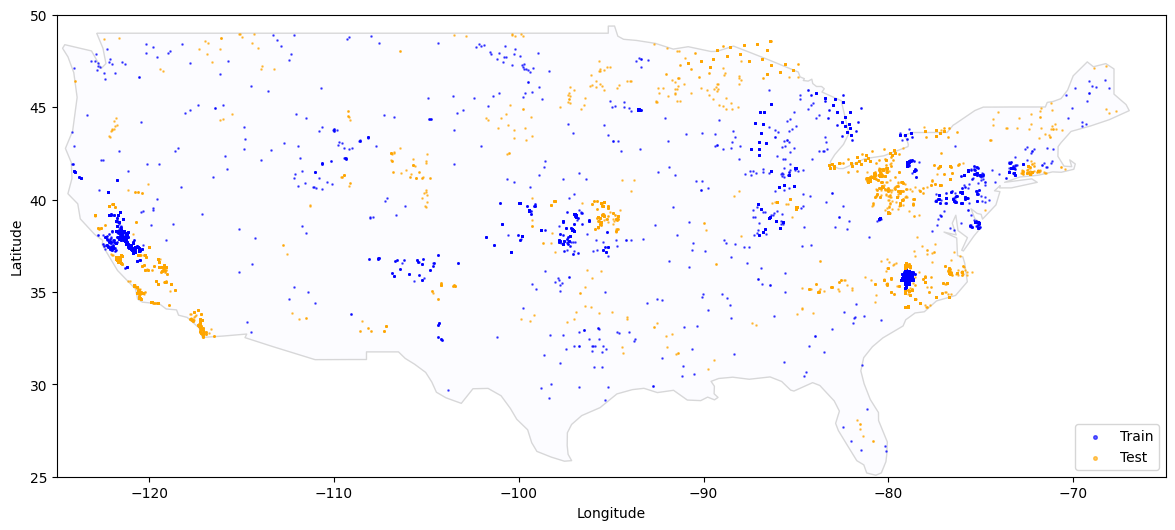

In [242]:
fig, ax = plt.subplots(figsize=(15, 6))

# map the training data
base = world[world.name == "United States of America"].plot(
    edgecolor="gray", color="ghostwhite", figsize=(9, 4), alpha=0.3, ax=ax
)

# map the training data
train_meta = metadata[metadata["split"] == "train"]
geometry = [Point(xy) for xy in zip(train_meta["longitude"], train_meta["latitude"])]
gdf = gpd.GeoDataFrame(train_meta, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="blue", label="Train", alpha=0.6)

# map the test data
test_meta = metadata[metadata["split"] == "test"]
geometry = [Point(xy) for xy in zip(test_meta["longitude"], test_meta["latitude"])]
gdf = gpd.GeoDataFrame(test_meta, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="orange", label="Test", alpha=0.6)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim([-125, -65])
plt.ylim([25, 50])
plt.legend(loc=4, markerscale=3)

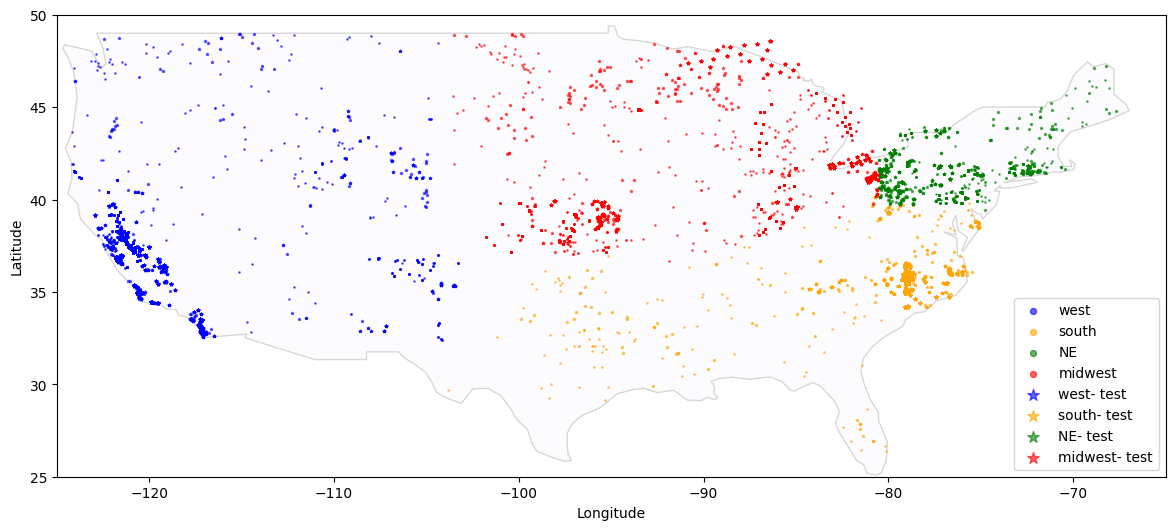

In [251]:
fig, ax = plt.subplots(figsize=(15, 6))

# map the training data
base = world[world.name == "United States of America"].plot(
    edgecolor="gray", color="ghostwhite", figsize=(9, 4), alpha=0.3, ax=ax
)

# map the region wise data
wdf = train_data[train_data["region"] == "west"]
geometry = [Point(xy) for xy in zip(wdf["longitude"], wdf["latitude"])]
gdf = gpd.GeoDataFrame(wdf, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="blue", label="west", alpha=0.6)

sdf = train_data[train_data["region"] == "south"]
geometry = [Point(xy) for xy in zip(sdf["longitude"], sdf["latitude"])]
gdf = gpd.GeoDataFrame(sdf, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="orange", label="south", alpha=0.6)

ndf = train_data[train_data["region"] == "northeast"]
geometry = [Point(xy) for xy in zip(ndf["longitude"], ndf["latitude"])]
gdf = gpd.GeoDataFrame(ndf, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="green", label="NE", alpha=0.6)

mwdf = train_data[train_data["region"] == "midwest"]
geometry = [Point(xy) for xy in zip(mwdf["longitude"], mwdf["latitude"])]
gdf = gpd.GeoDataFrame(mwdf, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="red", label="midwest", alpha=0.6)

# test region wise data
wdf_test = test_data[test_data["region"] == "west"]
geometry = [Point(xy) for xy in zip(wdf_test["longitude"], wdf_test["latitude"])]
gdf = gpd.GeoDataFrame(wdf_test, geometry=geometry)
gdf.plot(ax=base, marker="*", markersize=3, color="blue", label="west- test", alpha=0.6)

sdf_test = test_data[test_data["region"] == "south"]
geometry = [Point(xy) for xy in zip(sdf_test["longitude"], sdf_test["latitude"])]
gdf = gpd.GeoDataFrame(sdf_test, geometry=geometry)
gdf.plot(ax=base, marker="*", markersize=3, color="orange", label="south- test", alpha=0.6)

ndf_test = test_data[test_data["region"] == "northeast"]
geometry = [Point(xy) for xy in zip(ndf_test["longitude"], ndf_test["latitude"])]
gdf = gpd.GeoDataFrame(ndf_test, geometry=geometry)
gdf.plot(ax=base, marker="*", markersize=3, color="green", label="NE- test", alpha=0.6)

mwdf_test = test_data[test_data["region"] == "midwest"]
geometry = [Point(xy) for xy in zip(mwdf_test["longitude"], mwdf_test["latitude"])]
gdf = gpd.GeoDataFrame(mwdf_test, geometry=geometry)
gdf.plot(ax=base, marker="*", markersize=3, color="red", label="midwest- test", alpha=0.6)


plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim([-125, -65])
plt.ylim([25, 50])
plt.legend(loc=4, markerscale=5)

In [317]:
south_line = LineString([(southdata.longitude.max(), southdata.latitude.min()), (southdata.longitude.min(), southdata.latitude.max())])
west_line = LineString([(westdata.longitude.max(), westdata.latitude.min()), (westdata.longitude.min(), westdata.latitude.max())])
midwest_line = LineString([(midwestdata.longitude.max(), midwestdata.latitude.min()), (midwestdata.longitude.min(), midwestdata.latitude.max())])
northeast_line = LineString([(northeastdata.longitude.max(), northeastdata.latitude.min()), (northeastdata.longitude.min(), northeastdata.latitude.max())])

In [367]:
spoly = Polygon([(southdata.longitude.max(), southdata.latitude.min()),  (southdata.longitude.min(), southdata.latitude.min()), (southdata.longitude.min(), southdata.latitude.max()), (southdata.longitude.max(), southdata.latitude.max())])
wpoly = Polygon([(westdata.longitude.max(), westdata.latitude.min()),  (westdata.longitude.min(), westdata.latitude.min()), (westdata.longitude.min(), westdata.latitude.max()), (westdata.longitude.max(), westdata.latitude.max())])
mpoly = Polygon([(midwestdata.longitude.max(), midwestdata.latitude.min()),  (midwestdata.longitude.min(), midwestdata.latitude.min()), (midwestdata.longitude.min(), midwestdata.latitude.max()), (midwestdata.longitude.max(), midwestdata.latitude.max())])
npoly = Polygon([(northeastdata.longitude.max(), northeastdata.latitude.min()),  (northeastdata.longitude.min(), northeastdata.latitude.min()), (northeastdata.longitude.min(), northeastdata.latitude.max()), (northeastdata.longitude.max(), northeastdata.latitude.max())])


In [359]:
smean = southdata[['longitude', 'latitude']].mean()
wmean = westdata[['longitude', 'latitude']].mean()
mmean = midwestdata[['longitude', 'latitude']].mean()
nmean = northeastdata[['longitude', 'latitude']].mean()


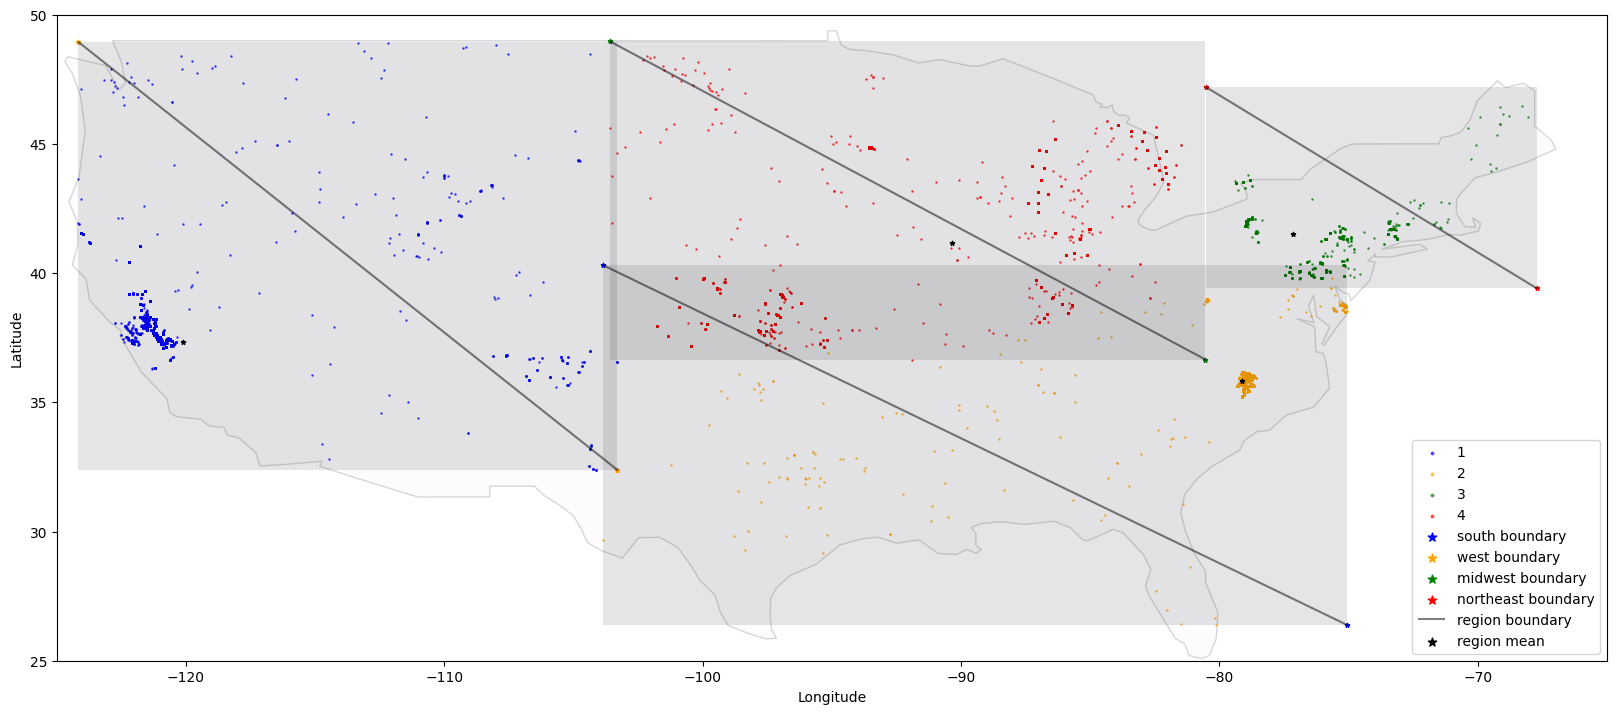

In [371]:
fig, ax = plt.subplots(figsize=(20, 10))

# map the training data
base = world[world.name == "United States of America"].plot(
    edgecolor="gray", color="ghostwhite", figsize=(9, 4), alpha=0.3, ax=ax
)

#  map based on severity
df1 = train_data[train_data["severity"] == 1]
geometry = [Point(xy) for xy in zip(wdf["longitude"], wdf["latitude"])]
gdf = gpd.GeoDataFrame(wdf, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="blue", label="1", alpha=0.6)

df2 = train_data[train_data["severity"] == 2]
geometry = [Point(xy) for xy in zip(sdf["longitude"], sdf["latitude"])]
gdf = gpd.GeoDataFrame(sdf, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="orange", label="2", alpha=0.6)

df3 = train_data[train_data["severity"] == 3]
geometry = [Point(xy) for xy in zip(ndf["longitude"], ndf["latitude"])]
gdf = gpd.GeoDataFrame(ndf, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="green", label="3", alpha=0.6)

df4 = train_data[train_data["severity"] == 4]
geometry = [Point(xy) for xy in zip(mwdf["longitude"], mwdf["latitude"])]
gdf = gpd.GeoDataFrame(mwdf, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="red", label="4", alpha=0.6)



sbs = [Point(xy) for xy in zip(south_line.coords.xy[0], south_line.coords.xy[1])]
gdf = gpd.GeoDataFrame(geometry=sbs)
gdf.plot(ax=base, marker="*", markersize=10, color="blue", label="south boundary")

wbs = [Point(xy) for xy in zip(west_line.coords.xy[0], west_line.coords.xy[1])]
gdf = gpd.GeoDataFrame(geometry=wbs)
gdf.plot(ax=base, marker="*", markersize=10, color="orange", label="west boundary")

mbs = [Point(xy) for xy in zip(midwest_line.coords.xy[0], midwest_line.coords.xy[1])]
gdf = gpd.GeoDataFrame(geometry=mbs)
gdf.plot(ax=base, marker="*", markersize=10, color="green", label="midwest boundary")

nbs = [Point(xy) for xy in zip(northeast_line.coords.xy[0], northeast_line.coords.xy[1])]
gdf = gpd.GeoDataFrame(geometry=nbs)
gdf.plot(ax=base, marker="*", markersize=10, color="red", label="northeast boundary")

gdf = gpd.GeoDataFrame(geometry=[south_line, west_line, midwest_line, northeast_line])
gdf.plot(ax=base, marker="*", markersize=3, color="black", alpha=0.5, label="region boundary")

# add mean locations of regions
gdf = gpd.GeoDataFrame(geometry=[Point(smean), Point(wmean), Point(mmean), Point(nmean)])
gdf.plot(ax=base, marker="*", markersize=10, color="black", label="region mean")

# add region polygons
gdf = gpd.GeoDataFrame(geometry=[spoly, wpoly, mpoly, npoly])
gdf.plot(ax=base, marker="*", markersize=3, color="black", alpha=0.1,  label="region polygon")



plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim([-125, -65])
plt.ylim([25, 50])
plt.legend(loc=4, markerscale=2)

In [ ]:
# we have overlapping regions?

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

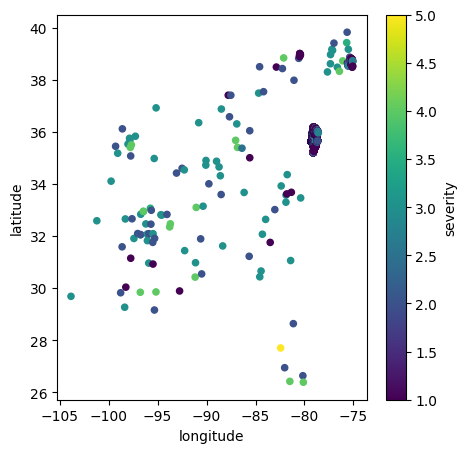

In [255]:
southdata = data[data.region == "south"]
southdata[['longitude', 'latitude', 'severity']].groupby(['longitude', 'latitude']).mean().reset_index().plot.scatter(x='longitude', y='latitude', c='severity', colormap='viridis', figsize=(5, 5))

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

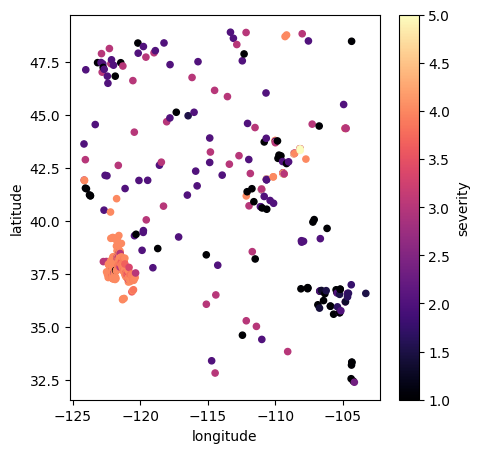

In [257]:
westdata = data[data.region == "west"]
westdata[['longitude', 'latitude', 'severity']].groupby(['longitude', 'latitude']).mean().reset_index().plot.scatter(x='longitude', y='latitude', c='severity', colormap='magma', figsize=(5, 5))

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

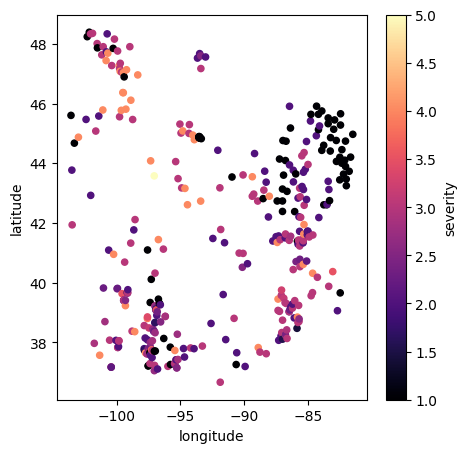

In [258]:
midwestdata = data[data.region == "midwest"]
midwestdata[['longitude', 'latitude', 'severity']].groupby(['longitude', 'latitude']).mean().reset_index().plot.scatter(x='longitude', y='latitude', c='severity', colormap='magma', figsize=(5, 5))

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

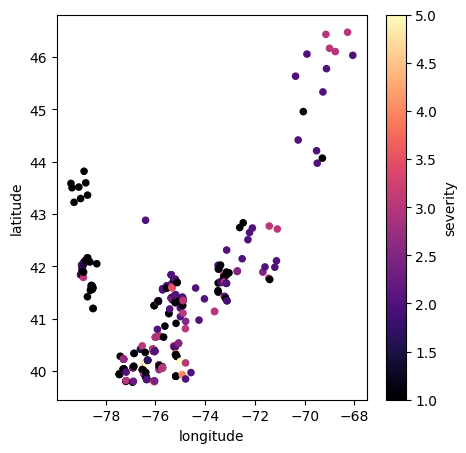

In [259]:
northeastdata = data[data.region == "northeast"]
northeastdata[['longitude', 'latitude', 'severity']].groupby(['longitude', 'latitude']).mean().reset_index().plot.scatter(x='longitude', y='latitude', c='severity', colormap='magma', figsize=(5, 5))

<AxesSubplot:xlabel='date', ylabel='count'>

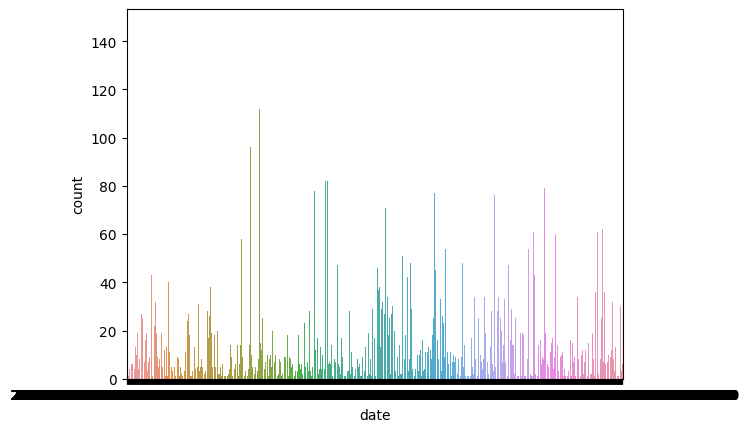

In [323]:
sns.countplot(x="date", data=data)

In [ ]:
sns.countplot(x="date", data=te_data)

In [326]:
tr_data.date.value_counts(normalize=True)

2016-08-10    0.007862
2015-07-07    0.006000
2015-06-22    0.005655
2015-06-10    0.005586
2015-05-20    0.005517
                ...   
2017-03-26    0.000069
2017-03-09    0.000069
2017-02-15    0.000069
2017-02-13    0.000069
2017-08-12    0.000069
Name: date, Length: 1231, dtype: float64

In [327]:
te_data.date.value_counts(normalize=True)

2019-09-17    0.006144
2014-07-30    0.005837
2019-01-17    0.004916
2019-08-27    0.004608
2020-03-18    0.004455
                ...   
2013-12-08    0.000154
2013-12-09    0.000154
2017-04-19    0.000154
2017-04-20    0.000154
2019-01-12    0.000154
Name: date, Length: 1278, dtype: float64

In [328]:
val_data.date.value_counts(normalize=True)

2016-08-10    0.009379
2015-07-07    0.008597
2015-06-22    0.008206
2021-06-17    0.007816
2015-07-23    0.006643
                ...   
2015-12-15    0.000391
2018-12-10    0.000391
2016-01-19    0.000391
2016-01-26    0.000391
2021-12-14    0.000391
Name: date, Length: 822, dtype: float64

In [325]:
data.date.value_counts(normalize=True)

2016-08-10    0.006194
2015-07-07    0.004752
2015-06-22    0.004370
2015-08-24    0.004370
2016-05-24    0.004200
                ...   
2019-04-28    0.000042
2020-11-24    0.000042
2020-11-25    0.000042
2020-12-03    0.000042
2019-08-04    0.000042
Name: date, Length: 1637, dtype: float64

In [336]:
train_data.date.nunique()/len(train_data), test_data.date.nunique()/len(test_data), val_data.date.nunique()/len(val_data)

(0.07356389214536929, 0.19631336405529953, 0.3212192262602579)

# Submission

In [43]:
#  Making submission with guess2 mean

sub_format['severity'] = 0

for row in tqdm(te_data.itertuples(), total=te_data.shape[0]):
    uid_series = te_data[te_data.uid == row.uid]
    severity = make_guess2(uid_series.iloc[0], date=row.date, tr_data=train_data)   # use all train data for making test submission
    sub_format.loc[sub_format.uid == row.uid, 'severity'] = severity

sub_format

  1%|▏         | 92/6510 [00:02<01:17, 83.06it/s]

No previous data for this date filling in 2s .. for igpa
No previous data for this date filling in 2s .. for lkpf


  2%|▏         | 101/6510 [00:02<03:28, 30.81it/s]

No previous data for this date filling in 2s .. for paez


100%|██████████| 6510/6510 [01:40<00:00, 64.90it/s] 


,uid,region,severity
0,aabn,west,2
1,aair,west,4
2,aajw,northeast,2
3,aalr,midwest,3
4,aalw,west,4
...,...,...,...
6505,zzpn,northeast,5
6506,zzrv,west,4
6507,zzsx,south,1
6508,zzvv,west,4


In [124]:
print(sub_format.severity.value_counts(normalize=True))

sub_format.to_csv('../submissions/to submit/guess2_mean_preds.csv', index=False)

4    0.326575
1    0.284178
2    0.214132
3    0.172197
5    0.002919
Name: severity, dtype: float64


# Sooo....

- val data goes for previous dates about 1 in 4 samples. but the test data goes to previous date about 3 dates forward for every sample.!!
- val_data is not like my test_data
- 

# Todos :

- Why that discrepancy?
- How about modelling with boosted trees on these guessed severities?
-  